In [1]:
import pandas as pd
import numpy as np
import math as math
import statistics
from sklearn.linear_model import LogisticRegression
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_decision_regions
import time
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',1000) #
pd.set_option('display.width', 150)

# GLOSSARY

In [2]:
glossaryDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/glossary/glossary.csv')
glossaryDict = {}
for i in range(len(glossaryDF)):
    stringInRow = glossaryDF.iloc[i].values[0]
    if stringInRow == 'Name':
        feature = glossaryDF.iloc[i-1].values[0]
        feature = feature.upper()
        glossaryDict[feature] = {}
        glossaryDict[feature]['Name'] = {}
        glossaryDict[feature]['Name'] = glossaryDF.iloc[i+1].values[0]
        glossaryDict[feature]['Definition'] = {}
        glossaryDict[feature]['Definition'] = glossaryDF.iloc[i+3].values[0]
        glossaryDict[feature]['Type'] = {}
        glossaryDict[feature]['Type'] = glossaryDF.iloc[i+5].values[0]
        glossaryDict[feature]['Contexts'] = {}

In [3]:
## ADDING DEFINITIONS FOR ADDITIONAL FEATURES CREATED TO GLOSSARY
glossaryDict['H/A'] = {}
glossaryDict['H/A']['Name'] = 'IS TEAM PLAYING HOME OR AWAY'
glossaryDict['H/A']['Definition'] = '0:HOME 1:AWAY'

glossaryDict['PTSA'] = {}
glossaryDict['PTSA']['Name'] = 'Points Allowed'
glossaryDict['PTSA']['Definition'] = 'The number of points allowed'

glossaryDict['PTSDELTA'] = {}
glossaryDict['PTSDELTA']['Name'] = 'Points Scored - Points Allowed'
glossaryDict['PTSDELTA']['Definition'] = 'Points Scored - Points Allowed'

glossaryDict['DAYSOFF'] = {}
glossaryDict['DAYSOFF']['Name'] = 'Number of days since last game'
glossaryDict['DAYSOFF']['Definition'] = 'Number of days since last game'

glossaryDict['W%'] = {}
glossaryDict['W%']['Name'] = 'The percentage of games played that a player or team has won'
glossaryDict['W%']['Definition'] = 'The percentage of games played that a player or team has won'

glossaryDict['L%'] = {}
glossaryDict['L%']['Name'] = 'The percentage of games played that a player or team has lost'
glossaryDict['L%']['Definition'] = 'The percentage of games played that a player or team has lost'

In [4]:
def convertDateColumn(df):
    locationToInsert = df.columns.get_loc('DATE')+1
    dates = pd.to_datetime(df['DATE'],format="%m/%d/%y").dt.date
    df = df.drop(columns='DATE')
    df.insert(locationToInsert,'DATE',dates)
    df = df.sort_values(by=['DATE','GAMEID']).reset_index(drop=True)
    return df
def featureEngineering(boxScoreType,df):
    if boxScoreType == 'TRADITIONAL':
        featuresToAddDict = {'OPPT':[],'PTSA':[],'2FGA':[],'2FGM':[],'2FG%':[],
                             'RESULT':[],'PTSDELTA':[],'H/A':[]}
        for i in range(len(df)):
            featuresToAddDict['OPPT'].append(df.iloc[i]['MATCH'][-3:])
            if i % 2 == 0: featuresToAddDict['PTSA'].append(df.iloc[i+1]['PTS'])
            else: featuresToAddDict['PTSA'].append(df.iloc[i-1]['PTS'])
            if df['W/L'][i] == 'L': featuresToAddDict['RESULT'].append(0)
            else: featuresToAddDict['RESULT'].append(1)
            featuresToAddDict['H/A'].append(df['MATCH'][i].count('vs'))
        df.insert(df.columns.get_loc('TEAM')+1,'OPPT',featuresToAddDict['OPPT'])
        df.insert(df.columns.get_loc('PTS')+1,'PTSA',featuresToAddDict['PTSA'])
        df.insert(df.columns.get_loc('FG%')+1,'2FGM',df['FGM'] - df['3PM'])
        df.insert(df.columns.get_loc('FG%')+1,'2FGA',df['FGA'] - df['3PA']) 
        df.insert(df.columns.get_loc('FG%')+1,'2FG%',df['2FGM']/df['2FGA'])
        df.insert(df.columns.get_loc('W/L')+1,'RESULT',featuresToAddDict['RESULT'])
        df = df.drop(columns=['W/L'])
        df.insert(df.columns.get_loc('PTSA')+1,'PTSDELTA',df['PTS']-df['PTSA'])
        df.insert(df.columns.get_loc('DATE')+1,'H/A',featuresToAddDict['H/A'])
        return df
    else:
        featuresToAddDict = {"OPPT":[],"RESULT":[],"H/A":[]}
        for i in range(len(df)):
            featuresToAddDict["OPPT"].append(df.iloc[i]['MATCH'][-3:])
            if df['W/L'][i] == 'L': featuresToAddDict["RESULT"].append(0)
            else: featuresToAddDict["RESULT"].append(1)
            featuresToAddDict["H/A"].append(df['MATCH'][i].count('vs'))
        df.insert(df.columns.get_loc('TEAM')+1,'OPPT',featuresToAddDict["OPPT"])
        df.insert(df.columns.get_loc('W/L')+1,'RESULT',featuresToAddDict["RESULT"])
        df = df.drop(columns=['W/L'])
        df.insert(df.columns.get_loc('DATE')+1,'H/A',featuresToAddDict["H/A"])
        return df
def addDaysOff(teamsDict):
    for team in list(teamsDict.keys()):
        daysOff = []
        daysOff.append(np.nan)
        for i in range(1,len(teamsDict[team]['DATE'])):
            date = teamsDict[team]['DATE'][i]
            prevDate = teamsDict[team]['DATE'][i-1] + datetime.timedelta(1)
            daysOff.append((date - prevDate).days)
        teamsDict[team]['DAYSOFF'] = daysOff
def addAdditionalFeatures(df,teamsDict):
    teams = []
    for team in list(teamsDict.keys()):
        teamDF = df[df['TEAM'] == team]
        startingIndex = len(list(df.columns))
        additionalFeatures = list(teamsDict[team].keys())[startingIndex:]
        for feature in additionalFeatures:
            teamDF = pd.concat([teamDF,
                                pd.DataFrame(teamsDict[team][feature],columns=[feature],index=teamDF.index.values)],axis=1)
        teams.append(teamDF)
    return pd.concat(teams)

def getTeamData(boxScoreType,df):
    teamsDict = {}
    features = df.columns.values
    
    if boxScoreType == 'TRADITIONAL': additionalFeatures = ['Ws','Ls','GP','W%','L%','AVGPTS','AVGPTSA']
    else: additionalFeatures = ['GP']
    for team in np.unique(df['TEAM']):
        teamsDict[team] = {}
    for team in np.unique(df['TEAM']):
        for feature in features:
            teamsDict[team][feature] = []
        for feature in additionalFeatures:
            teamsDict[team][feature] = []
    for i in range(len(df)):
        for feature in features:
            team = df.iloc[i]['TEAM']
            teamsDict[team][feature].append(df.iloc[i][feature])
        for feature in additionalFeatures:
            if feature == 'Ws': teamsDict[team][feature].append(teamsDict[team]['RESULT'].count(1))
            if feature == 'Ls': teamsDict[team][feature].append(teamsDict[team]['RESULT'].count(0))
            if feature == 'GP': teamsDict[team][feature].append(len(teamsDict[team]['RESULT']))
            if feature == 'W%': teamsDict[team][feature].append(teamsDict[team]['Ws'][-1]/teamsDict[team]['GP'][-1])
            if feature == 'L%': teamsDict[team][feature].append(teamsDict[team]['Ls'][-1]/teamsDict[team]['GP'][-1])
            if feature == 'AVGPTS': teamsDict[team][feature].append(np.mean(teamsDict[team]['PTS']))
            if feature == 'AVGPTSA': teamsDict[team][feature].append(np.mean(teamsDict[team]['PTSA']))
    return teamsDict

def addMovingAverageLx(featureStringsDict,teamDict,x):
    for team in list(teamsDict.keys()):
        for feature in featureStringsDict.keys():
            ma = []
            for _ in range(x): ma.append(np.nan)
            for maRange in range(0,len(teamsDict[team][feature])-x):
                ma.append(np.mean(teamsDict[team][feature][maRange:(x+maRange)]))
            teamsDict[team][featureStringsDict[feature].replace('x',str(x))] = ma
                
def addPercentMovingAverageLx(featureStringsDict,teamsDict,x):
    for team in list(teamsDict.keys()):
        for features in featureStringsDict.keys():
            ma = []
            for _ in range(x): ma.append(np.nan)
            for maRange in range(0,len(teamsDict[team][features[0]])-x):
                num = np.sum(teamsDict[team][features[0]][maRange:(x+maRange)])
                dem = np.sum(teamsDict[team][features[1]][maRange:(x+maRange)])
                ma.append(num/dem)
            teamsDict[team][featureStringsDict[features].replace('x',str(x))] = ma

# Traditional.csv

In [5]:
start_time = time.time()
traditionalDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/2023-24/byGame/Traditional.csv')
traditionalDF = convertDateColumn(traditionalDF)
traditionalDF = featureEngineering('TRADITIONAL',traditionalDF)
teamsDict = getTeamData('TRADITIONAL',traditionalDF)
print("%s seconds" % (time.time() - start_time))

34.14887189865112 seconds


In [6]:
start_time = time.time()
features = ['PTS','PTSA','PTSDELTA','FGM','FGA','2FGA','2FGM','3PM','3PA','FTM','FTA','OREB',
            'DREB','REB','AST','STL','BLK','TOV','PF']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA'
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)


features = [('FGM','FGA'),('2FGM','2FGA'),('3PM','3PA'),('FTM','FTA'),('Ws','GP')]
featureStringsDict = {}

for feature in features:
    if feature == ('FGM','FGA'): featureStringsDict[feature] = 'FG%LxMA'
    if feature == ('2FGM','2FGA'): featureStringsDict[feature] = '2FG%LxMA'
    if feature == ('3PM','3PA'): featureStringsDict[feature] = '3P%LxMA'
    if feature == ('FTM','FTA'): featureStringsDict[feature] = 'FT%LxMA'
    if feature == ('Ws','GP'): featureStringsDict[feature] = 'W%LxMA'
        
addPercentMovingAverageLx(featureStringsDict,teamsDict,5)
addPercentMovingAverageLx(featureStringsDict,teamsDict,4)
addPercentMovingAverageLx(featureStringsDict,teamsDict,3)
addPercentMovingAverageLx(featureStringsDict,teamsDict,2)
addPercentMovingAverageLx(featureStringsDict,teamsDict,1)

addDaysOff(teamsDict)
traditionalDF = addAdditionalFeatures(traditionalDF,teamsDict)
traditionalDF = traditionalDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

<ipython-input-4-8b2e36489fd7>:106: RuntimeWarning: invalid value encountered in scalar divide
  ma.append(num/dem)


17.5640230178833 seconds


In [7]:
print('In rare occasion on 4/9/24 Celtics attempted 0 free throws vs Bucks [see below]')
print('Causing a warning while calculating Celtics FT%L1MA')
print('FT%L1MA feature is not used during ... ')
traditionalDF[traditionalDF['FTA'] == 0]

In rare occasion on 4/9/24 Celtics attempted 0 free throws vs Bucks [see below]
Causing a warning while calculating Celtics FT%L1MA
FT%L1MA feature is not used during ... 


TEAM OPPT      TEAMID      MATCH    GAMEID  RESULT        DATE  H/A  SPREAD    O/U  MIN  PTS  PTSA  PTSDELTA  FGM  FGA   FG%      2FG%  2FGA  \
2354  BOS  MIL  1610612738  BOS @ MIL  22301148       0  2024-04-09    0     3.5  231.0  240   91   104       -13   37   93  39.8  0.487805    41   

      2FGM  3PM  3PA   3P%  FTM  FTA  FT%  OREB  DREB  REB  AST  STL  BLK  TOV  PF  +/-  Ws  Ls  GP       W%       L%      AVGPTS     AVGPTSA  \
2354    20   17   52  32.7    0    0  0.0    12    26   38   27   11    4   12   8  -13  62  17  79  0.78481  0.21519  120.443038  109.101266   

      PTSL5MA  PTSAL5MA  PTSDELTAL5MA  FGML5MA  FGAL5MA  2FGAL5MA  2FGML5MA  3PML5MA  3PAL5MA  FTML5MA  FTAL5MA  OREBL5MA  DREBL5MA  REBL5MA  \
2354    116.4     100.6          15.8     43.8     87.8      45.4      28.0     15.8     42.4     13.0     15.6       9.4      38.4     47.8   

      ASTL5MA  STLL5MA  BLKL5MA  TOVL5MA  PFL5MA  PTSL4MA  PTSAL4MA  PTSDELTAL4MA  FGML4MA  FGAL4MA  2FGAL4MA  2FGML4MA  3PML4MA  3PAL4MA  FTML4MA  \
2354     29.4      6.8      6.4     11.2    13.8    119.5    102.75         16.75     45.0    89.25      45.5      29.0     16.0    43.75     13.5   

      FTAL4MA  OREBL4MA  DREBL4MA  REBL4MA  ASTL4MA  STLL4MA  BLKL4MA  TOVL4MA  PFL4MA  PTSL3MA    PTSAL3MA  PTSDELTAL3MA    FGML3MA    FGAL3MA  \
2354     16.5      9.75     37.25     47.0     30.0     6.75     6.25    10.75    14.0    120.0  102.333333     17.666667  45.666667  89.333333   

       2FGAL3MA   2FGML3MA  3PML3MA    3PAL3MA    FTML3MA    FTAL3MA  OREBL3MA   DREBL3MA    REBL3MA    ASTL3MA  STLL3MA   BLKL3MA    TOVL3MA  \
2354  48.666667  30.666667     15.0  40.666667  13.666667  16.666667  9.333333  36.333333  45.666667  30.666667      8.0  7.333333  10.666667   

         PFL3MA  PTSL2MA  PTSAL2MA  PTSDELTAL2MA  FGML2MA  FGAL2MA  2FGAL2MA  2FGML2MA  3PML2MA  3PAL2MA  FTML2MA  FTAL2MA  OREBL2MA  DREBL2MA  \
2354  13.666667    112.5     103.5           9.0     43.5     88.0      47.0      29.5     14.0     41.0     11.5     15.5       8.5      37.0   

      REBL2MA  ASTL2MA  STLL2MA  BLKL2MA  TOVL2MA  PFL2MA  PTSL1MA  PTSAL1MA  PTSDELTAL1MA  FGML1MA  FGAL1MA  2FGAL1MA  2FGML1MA  3PML1MA  3PAL1MA  \
2354     45.5     29.5      8.5      6.0     10.5    11.5    124.0     107.0          17.0     49.0     87.0      49.0      33.0     16.0     38.0   

      FTML1MA  FTAL1MA  OREBL1MA  DREBL1MA  REBL1MA  ASTL1MA  STLL1MA  BLKL1MA  TOVL1MA  PFL1MA   FG%L5MA  2FG%L5MA   3P%L5MA   FT%L5MA    W%L5MA  \
2354     10.0     13.0       5.0      35.0     40.0     34.0     11.0      8.0     13.0    12.0  0.498861   0.61674  0.372642  0.833333  0.789474   

       FG%L4MA  2FG%L4MA   3P%L4MA   FT%L4MA   W%L4MA   FG%L3MA  2FG%L3MA   3P%L3MA  FT%L3MA    W%L3MA   FG%L2MA  2FG%L2MA   3P%L2MA   FT%L2MA  \
2354  0.504202  0.637363  0.365714  0.818182  0.79085  0.511194  0.630137  0.368852     0.82  0.792208  0.494318   0.62766  0.341463  0.741935   

        W%L2MA   FG%L1MA  2FG%L1MA   3P%L1MA   FT%L1MA    W%L1MA  DAYSOFF  
2354  0.793548  0.563218  0.673469  0.421053  0.769231  0.794872      1.0

In [8]:
traditionalFeatures = list(traditionalDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE',
                            'SPREAD','O/U','MIN','PTS','PTSA','PTSDELTA','FGM','FGA','FG%',
                            '2FG%','2FGA','2FGM','3PM','3PA','3P%','FTM','FTA','FT%','OREB',
                            'DREB','REB','AST','STL','BLK','TOV','PF','+/-','Ws','Ls', 'GP',
                            'W%', 'L%', 'AVGPTS','AVGPTSA'])
for feature in columnsToRemove: traditionalFeatures.remove(feature)
print(traditionalFeatures)

['H/A', 'PTSL5MA', 'PTSAL5MA', 'PTSDELTAL5MA', 'FGML5MA', 'FGAL5MA', '2FGAL5MA', '2FGML5MA', '3PML5MA', '3PAL5MA', 'FTML5MA', 'FTAL5MA', 'OREBL5MA', 'DREBL5MA', 'REBL5MA', 'ASTL5MA', 'STLL5MA', 'BLKL5MA', 'TOVL5MA', 'PFL5MA', 'PTSL4MA', 'PTSAL4MA', 'PTSDELTAL4MA', 'FGML4MA', 'FGAL4MA', '2FGAL4MA', '2FGML4MA', '3PML4MA', '3PAL4MA', 'FTML4MA', 'FTAL4MA', 'OREBL4MA', 'DREBL4MA', 'REBL4MA', 'ASTL4MA', 'STLL4MA', 'BLKL4MA', 'TOVL4MA', 'PFL4MA', 'PTSL3MA', 'PTSAL3MA', 'PTSDELTAL3MA', 'FGML3MA', 'FGAL3MA', '2FGAL3MA', '2FGML3MA', '3PML3MA', '3PAL3MA', 'FTML3MA', 'FTAL3MA', 'OREBL3MA', 'DREBL3MA', 'REBL3MA', 'ASTL3MA', 'STLL3MA', 'BLKL3MA', 'TOVL3MA', 'PFL3MA', 'PTSL2MA', 'PTSAL2MA', 'PTSDELTAL2MA', 'FGML2MA', 'FGAL2MA', '2FGAL2MA', '2FGML2MA', '3PML2MA', '3PAL2MA', 'FTML2MA', 'FTAL2MA', 'OREBL2MA', 'DREBL2MA', 'REBL2MA', 'ASTL2MA', 'STLL2MA', 'BLKL2MA', 'TOVL2MA', 'PFL2MA', 'PTSL1MA', 'PTSAL1MA', 'PTSDELTAL1MA', 'FGML1MA', 'FGAL1MA', '2FGAL1MA', '2FGML1MA', '3PML1MA', '3PAL1MA', 'FTML1MA', 'F

# Advanced.csv

In [9]:
start_time = time.time()
advancedDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/2023-24/byGame/Advanced.csv')
advancedDF = convertDateColumn(advancedDF)
advancedDF = featureEngineering('ADVANCED',advancedDF)
teamsDict = getTeamData('ADVANCED',advancedDF)
print("%s seconds" % (time.time() - start_time))

24.451960802078247 seconds


In [10]:
start_time = time.time()
features = ['OFFRTG','DEFRTG','NETRTG','AST%','AST/TO','AST RATIO','OREB%','DREB%','REB%','TOV%',
            'EFG%','TS%','PACE','PIE']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

advancedDF = addAdditionalFeatures(advancedDF,teamsDict)
advancedDF = advancedDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

8.503874063491821 seconds


In [11]:
advancedFeatures = list(advancedDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE',
                            'H/A','SPREAD','O/U','MIN','OFFRTG','DEFRTG','NETRTG',
                            'AST%','AST/TO','AST RATIO','OREB%','DREB%','REB%','TOV%',
                            'EFG%','TS%','PACE','PIE','GP'])
for feature in columnsToRemove: advancedFeatures.remove(feature)
print(advancedFeatures)

['OFFRTGL5MA', 'DEFRTGL5MA', 'NETRTGL5MA', 'AST%L5MA', 'AST/TOL5MA', 'AST RATIOL5MA', 'OREB%L5MA', 'DREB%L5MA', 'REB%L5MA', 'TOV%L5MA', 'EFG%L5MA', 'TS%L5MA', 'PACEL5MA', 'PIEL5MA', 'OFFRTGL4MA', 'DEFRTGL4MA', 'NETRTGL4MA', 'AST%L4MA', 'AST/TOL4MA', 'AST RATIOL4MA', 'OREB%L4MA', 'DREB%L4MA', 'REB%L4MA', 'TOV%L4MA', 'EFG%L4MA', 'TS%L4MA', 'PACEL4MA', 'PIEL4MA', 'OFFRTGL3MA', 'DEFRTGL3MA', 'NETRTGL3MA', 'AST%L3MA', 'AST/TOL3MA', 'AST RATIOL3MA', 'OREB%L3MA', 'DREB%L3MA', 'REB%L3MA', 'TOV%L3MA', 'EFG%L3MA', 'TS%L3MA', 'PACEL3MA', 'PIEL3MA', 'OFFRTGL2MA', 'DEFRTGL2MA', 'NETRTGL2MA', 'AST%L2MA', 'AST/TOL2MA', 'AST RATIOL2MA', 'OREB%L2MA', 'DREB%L2MA', 'REB%L2MA', 'TOV%L2MA', 'EFG%L2MA', 'TS%L2MA', 'PACEL2MA', 'PIEL2MA', 'OFFRTGL1MA', 'DEFRTGL1MA', 'NETRTGL1MA', 'AST%L1MA', 'AST/TOL1MA', 'AST RATIOL1MA', 'OREB%L1MA', 'DREB%L1MA', 'REB%L1MA', 'TOV%L1MA', 'EFG%L1MA', 'TS%L1MA', 'PACEL1MA', 'PIEL1MA']


# FourFactors.csv

In [12]:
start_time = time.time()
fourFactorsDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/2023-24/byGame/FourFactors.csv')
fourFactorsDF = convertDateColumn(fourFactorsDF)
fourFactorsDF = featureEngineering('FOURFACTORS',fourFactorsDF)
teamsDict = getTeamData('FOURFACTORS',fourFactorsDF)
print("%s seconds" % (time.time() - start_time))

15.994400978088379 seconds


In [13]:
start_time = time.time()
features = ['EFG%','FTA RATE','TOV%','OREB%','OPP EFG%','OPP FTA RATE','OPP TOV%','OPP OREB%']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

fourFactorsDF = addAdditionalFeatures(fourFactorsDF,teamsDict)
fourFactorsDF = fourFactorsDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

4.666632890701294 seconds


In [14]:
fourFactorsFeatures = list(fourFactorsDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A',
                            'SPREAD','O/U','MIN','EFG%','FTA RATE','TOV%','OREB%','OPP EFG%',
                            'OPP FTA RATE','OPP TOV%','OPP OREB%','GP'])
for feature in columnsToRemove: fourFactorsFeatures.remove(feature)
print(fourFactorsFeatures)

['EFG%L5MA', 'FTA RATEL5MA', 'TOV%L5MA', 'OREB%L5MA', 'OPP EFG%L5MA', 'OPP FTA RATEL5MA', 'OPP TOV%L5MA', 'OPP OREB%L5MA', 'EFG%L4MA', 'FTA RATEL4MA', 'TOV%L4MA', 'OREB%L4MA', 'OPP EFG%L4MA', 'OPP FTA RATEL4MA', 'OPP TOV%L4MA', 'OPP OREB%L4MA', 'EFG%L3MA', 'FTA RATEL3MA', 'TOV%L3MA', 'OREB%L3MA', 'OPP EFG%L3MA', 'OPP FTA RATEL3MA', 'OPP TOV%L3MA', 'OPP OREB%L3MA', 'EFG%L2MA', 'FTA RATEL2MA', 'TOV%L2MA', 'OREB%L2MA', 'OPP EFG%L2MA', 'OPP FTA RATEL2MA', 'OPP TOV%L2MA', 'OPP OREB%L2MA', 'EFG%L1MA', 'FTA RATEL1MA', 'TOV%L1MA', 'OREB%L1MA', 'OPP EFG%L1MA', 'OPP FTA RATEL1MA', 'OPP TOV%L1MA', 'OPP OREB%L1MA']


# Misc.csv

In [15]:
start_time = time.time()
miscDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/2023-24/byGame/Misc.csv')
miscDF = convertDateColumn(miscDF)
miscDF = featureEngineering('MISC',miscDF)
teamsDict = getTeamData('MISC',miscDF)
print("%s seconds" % (time.time() - start_time))

15.846877098083496 seconds


In [16]:
start_time = time.time()
features = ['PTS OFF TO','2ND PTS','FBPS','PITP','OPP PTS OFF TO','OPP 2ND PTS','OPP FBPS','OPP PITP']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
featureStringsDict    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

miscDF = addAdditionalFeatures(miscDF,teamsDict)
miscDF = miscDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

4.312172889709473 seconds


In [17]:
miscFeatures = list(miscDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A','SPREAD',
                            'O/U','MIN','PTS OFF TO','2ND PTS','FBPS','PITP','OPP PTS OFF TO',
                            'OPP 2ND PTS','OPP FBPS','OPP PITP','GP'])
for feature in columnsToRemove: miscFeatures.remove(feature)
print(miscFeatures)

['PTS OFF TOL5MA', '2ND PTSL5MA', 'FBPSL5MA', 'PITPL5MA', 'OPP PTS OFF TOL5MA', 'OPP 2ND PTSL5MA', 'OPP FBPSL5MA', 'OPP PITPL5MA', 'PTS OFF TOL4MA', '2ND PTSL4MA', 'FBPSL4MA', 'PITPL4MA', 'OPP PTS OFF TOL4MA', 'OPP 2ND PTSL4MA', 'OPP FBPSL4MA', 'OPP PITPL4MA', 'PTS OFF TOL3MA', '2ND PTSL3MA', 'FBPSL3MA', 'PITPL3MA', 'OPP PTS OFF TOL3MA', 'OPP 2ND PTSL3MA', 'OPP FBPSL3MA', 'OPP PITPL3MA', 'PTS OFF TOL2MA', '2ND PTSL2MA', 'FBPSL2MA', 'PITPL2MA', 'OPP PTS OFF TOL2MA', 'OPP 2ND PTSL2MA', 'OPP FBPSL2MA', 'OPP PITPL2MA', 'PTS OFF TOL1MA', '2ND PTSL1MA', 'FBPSL1MA', 'PITPL1MA', 'OPP PTS OFF TOL1MA', 'OPP 2ND PTSL1MA', 'OPP FBPSL1MA', 'OPP PITPL1MA']


# Scoring.csv

In [18]:
start_time = time.time()
scoringDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/2023-24/byGame/Scoring.csv')
scoringDF = convertDateColumn(scoringDF)
scoringDF = featureEngineering('SCORING',scoringDF)
teamsDict = getTeamData('SCORING',scoringDF)
print("%s seconds" % (time.time() - start_time))

24.148153066635132 seconds


In [19]:
start_time = time.time()
features = ['%FGA 2PT','%FGA 3PT','%PTS 2PT','%PTS 2PT MR','%PTS 3PT','%PTS FBPS','%PTS FT',
            '%PTS OFF TO','%PTS PITP','2FGM %AST','2FGM %UAST','3FGM %AST','3FGM %UAST','FGM %AST','FGM %UAST']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
featureStringsDict    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

scoringDF = addAdditionalFeatures(scoringDF,teamsDict)
scoringDF = scoringDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

11.98450779914856 seconds


In [20]:
scoringFeatures = list(scoringDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A','SPREAD',
                            'O/U','MIN','%FGA 2PT','%FGA 3PT','%PTS 2PT','%PTS 2PT MR','%PTS 3PT',
                            '%PTS FBPS','%PTS FT','%PTS OFF TO','%PTS PITP','2FGM %AST','2FGM %UAST',
                            '3FGM %AST','3FGM %UAST','FGM %AST','FGM %UAST','GP'])
for feature in columnsToRemove: scoringFeatures.remove(feature)
print(scoringFeatures)

['%FGA 2PTL5MA', '%FGA 3PTL5MA', '%PTS 2PTL5MA', '%PTS 2PT MRL5MA', '%PTS 3PTL5MA', '%PTS FBPSL5MA', '%PTS FTL5MA', '%PTS OFF TOL5MA', '%PTS PITPL5MA', '2FGM %ASTL5MA', '2FGM %UASTL5MA', '3FGM %ASTL5MA', '3FGM %UASTL5MA', 'FGM %ASTL5MA', 'FGM %UASTL5MA', '%FGA 2PTL4MA', '%FGA 3PTL4MA', '%PTS 2PTL4MA', '%PTS 2PT MRL4MA', '%PTS 3PTL4MA', '%PTS FBPSL4MA', '%PTS FTL4MA', '%PTS OFF TOL4MA', '%PTS PITPL4MA', '2FGM %ASTL4MA', '2FGM %UASTL4MA', '3FGM %ASTL4MA', '3FGM %UASTL4MA', 'FGM %ASTL4MA', 'FGM %UASTL4MA', '%FGA 2PTL3MA', '%FGA 3PTL3MA', '%PTS 2PTL3MA', '%PTS 2PT MRL3MA', '%PTS 3PTL3MA', '%PTS FBPSL3MA', '%PTS FTL3MA', '%PTS OFF TOL3MA', '%PTS PITPL3MA', '2FGM %ASTL3MA', '2FGM %UASTL3MA', '3FGM %ASTL3MA', '3FGM %UASTL3MA', 'FGM %ASTL3MA', 'FGM %UASTL3MA', '%FGA 2PTL2MA', '%FGA 3PTL2MA', '%PTS 2PTL2MA', '%PTS 2PT MRL2MA', '%PTS 3PTL2MA', '%PTS FBPSL2MA', '%PTS FTL2MA', '%PTS OFF TOL2MA', '%PTS PITPL2MA', '2FGM %ASTL2MA', '2FGM %UASTL2MA', '3FGM %ASTL2MA', '3FGM %UASTL2MA', 'FGM %ASTL2MA', 

In [25]:
def trainOnPreviousGames(NBAdf,features,date,standardize):
    trainDF = NBAdf[(NBAdf['DATE'] < date) & (NBAdf['GP'] > 5)]
    teamsPlayingToday = list(NBAdf[NBAdf['DATE'] == date]['TEAM'])
    trainResultsDict = {}
    trainResultsDict[date] = {}
    for team in teamsPlayingToday:
        trainResultsDict[date][team] = {'DATE':datetime.date,'TEAM':str,'TRAIN SIZE':int,
                                        'FEATURE':[],'INTERCEPT':[],'COEF':[],'ODDS RATIO':[],
                                        'LOG LOSS':[]}
    for team in teamsPlayingToday:
        for feature in features:
            X_train = trainDF[trainDF['TEAM'] == team][feature]
            if X_train.isnull().values.any() == True:
                continue #skips the current iteration and proceeds to the next one
            X_train = np.array(X_train)
            X_train = np.reshape(X_train,(len(X_train),1))
            if (standardize): X_train = StandardScaler().fit_transform(X_train)
            y_train = trainDF[trainDF['TEAM'] == team]['RESULT']
            model = LogisticRegression(random_state=0)
            model.fit(X_train,y_train)
            trainResultsDict[date][team]['DATE'] = date
            trainResultsDict[date][team]['TEAM'] = team
            trainResultsDict[date][team]['TRAIN SIZE'] = len(X_train)
            trainResultsDict[date][team]['FEATURE'].append(feature),
            trainResultsDict[date][team]['INTERCEPT'].append(model.intercept_[0])
            trainResultsDict[date][team]['COEF'].append(model.coef_[0][0])
            trainResultsDict[date][team]['ODDS RATIO'].append(np.exp(model.coef_[0][0]))
            trainResultsDict[date][team]['LOG LOSS'].append(log_loss(y_train,model.predict_proba(X_train)))
    return trainResultsDict
def getHighestOddsRatioFeatures(trainResultsDict):
    highestOddsRatiosDF = pd.DataFrame()
    date = list(trainResultsDict.keys())[0]
    for key in trainResultsDict[date].keys():
        highestOddsRatiosDF = highestOddsRatiosDF.append(pd.DataFrame(trainResultsDict[date][key]).sort_values(by='ODDS RATIO',ascending=False).head(1).reset_index(drop=True))
    highestOddsRatiosDF = highestOddsRatiosDF.reset_index(drop=True)
    return highestOddsRatiosDF
def getLowestLogLossFeatures(trainResultsDict):
    lowestLogLossDF = pd.DataFrame()
    date = list(trainResultsDict.keys())[0]
    for key in trainResultsDict[date].keys():
         lowestLogLossDF = lowestLogLossDF.append(pd.DataFrame(trainResultsDict[date][key]).sort_values(by='LOG LOSS').head(1).reset_index(drop=True))
    lowestLogLossDF = lowestLogLossDF.reset_index(drop=True)
    return lowestLogLossDF.reset_index(drop=True)
def addTestDetails(NBAdf,date,testDetailsDF):
    NBAtest = NBAdf[NBAdf['DATE'] == date].reset_index(drop=True)
    teamsPlayingToday = NBAtest['TEAM'].values
    matchDetails = {'GAMEID':[],'TRUE X_test':[],'SPREAD':[],'ACTUAL RESULT':[]}
    for i in range(len(testDetailsDF)):
        matchDetails['GAMEID'].append(NBAtest.iloc[i]['GAMEID'])
        matchDetails['TRUE X_test'].append(NBAtest.iloc[i][testDetailsDF.iloc[i]['FEATURE']])
        matchDetails['SPREAD'].append(NBAtest.iloc[i]['SPREAD'])
        matchDetails['ACTUAL RESULT'].append(NBAtest.iloc[i]['RESULT'])
    testDetailsDF = pd.concat([testDetailsDF,
                    pd.DataFrame(matchDetails['GAMEID'],columns=['GAMEID']),
                    pd.DataFrame(matchDetails['TRUE X_test'],columns=['TRUE X_test']),
                    pd.DataFrame(matchDetails['SPREAD'],columns=['SPREAD']),
                    pd.DataFrame(matchDetails['ACTUAL RESULT'],columns=['ACTUAL RESULT']),],axis=1)
    testDetailsDF.insert(testDetailsDF.columns.get_loc('DATE')+1,'GAMEID',testDetailsDF.pop('GAMEID'))
    return testDetailsDF
def testGamesToday(NBAdf,testDetailsDF,date,standardize):
    NBAtrain = NBAdf[NBAdf['DATE'] < date].dropna()
    NBAtest = NBAdf[NBAdf['DATE'] == date].reset_index(drop=True)
    testDetails = {'PREDICT X_test':[],'PROBABILITY ESTIMATE':[],'T/S':[]}
    for i in range(len(testDetailsDF)):
        team = testDetailsDF.iloc[i]['TEAM']
        feature = testDetailsDF.iloc[i]['FEATURE']
        X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
        X_train = np.array(X_train)
        X_train = np.reshape(X_train,(len(X_train),1))
        if (standardize): 
            X_train = StandardScaler().fit_transform(X_train)
            testDetails['T/S'].append('S')
        else: testDetails['T/S'].append('T')
        y_train = NBAtrain[NBAtrain['TEAM'] == team]['RESULT']
        model = LogisticRegression(random_state=0)
        model.fit(X_train,y_train)
        X_test = np.array([testDetailsDF.iloc[i]['TRUE X_test']])
        if (standardize):
            X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
            X_test = (X_test - np.mean(X_train)) / np.std(X_train)
        testDetails['PREDICT X_test'].append(X_test)
        X_test = np.reshape(X_test,(len(X_test),1))
        testDetails['PROBABILITY ESTIMATE'].append(model.predict_proba(X_test)[0][1])
    testDetailsDF = pd.concat([testDetailsDF,
                    pd.DataFrame(testDetails['PREDICT X_test'],columns=['PREDICT X_test']),
                    pd.DataFrame(testDetails['T/S'],columns=['T/S']),
                    pd.DataFrame(testDetails['PROBABILITY ESTIMATE'],columns=['PROBABILITY ESTIMATE'])],axis=1)
    return testDetailsDF

In [62]:
def trainTest(df,features):
    dateOfNBAAllStarGame = datetime.date(2024,2,18)
    datesPostAllStarGame = np.unique(df[df['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
    
    modelTypeResults = {}
    for date in datesPostAllStarGame:
        start_time = time.time()
        modelTypeResults[date] = {}
        modelTypeResults[date]['true'] = {}
        modelTypeResults[date]['true']['oddsRatio'] = {}
        modelTypeResults[date]['true']['logLoss'] = {}
        modelTypeResults[date]['standardized'] = {}
        modelTypeResults[date]['standardized']['oddsRatio'] = {}
        modelTypeResults[date]['standardized']['logLoss'] = {}

        trainResultsDict = trainOnPreviousGames(df,features,date,standardize=0)
        highestOddsRatiosDF = getHighestOddsRatioFeatures(trainResultsDict)
        testDetailsDF = addTestDetails(df,date,highestOddsRatiosDF)
        testDetailsDF = testGamesToday(df,testDetailsDF,date,standardize=0)               
        modelTypeResults[date]['true']['oddsRatio']['testDetailsDF'] = testDetailsDF
        
        lowestLogLossDF = getLowestLogLossFeatures(trainResultsDict)
        testDetailsDF = addTestDetails(df,date,lowestLogLossDF)
        testDetailsDF = testGamesToday(df,testDetailsDF,date,standardize=0)                
        modelTypeResults[date]['true']['logLoss']['testDetailsDF'] = testDetailsDF

        trainResultsDict = trainOnPreviousGames(df,features,date,standardize=1)           
        highestOddsRatiosDF = getHighestOddsRatioFeatures(trainResultsDict)
        testDetailsDF = addTestDetails(df,date,highestOddsRatiosDF)
        testDetailsDF = testGamesToday(df,testDetailsDF,date,standardize=1)                
        modelTypeResults[date]['standardized']['oddsRatio']['testDetailsDF'] = testDetailsDF
        
        lowestLogLossDF = getLowestLogLossFeatures(trainResultsDict)
        testDetailsDF = addTestDetails(df,date,lowestLogLossDF)
        testDetailsDF = testGamesToday(df,testDetailsDF,date,standardize=1)                
        modelTypeResults[date]['standardized']['logLoss']['testDetailsDF'] = testDetailsDF
        
        print(date,"%s seconds" % (time.time() - start_time))
    return modelTypeResults

# TRAIN & TEST

In [63]:
traditionalTestDetails = trainTest(traditionalDF,traditionalFeatures)

2024-02-22 41.66090202331543 seconds
2024-02-23 34.832661867141724 seconds
2024-02-24 10.778143882751465 seconds
2024-02-25 38.3097243309021 seconds
2024-02-26 13.79838490486145 seconds
2024-02-27 38.13239789009094 seconds
2024-02-28 20.769683122634888 seconds
2024-02-29 29.236692905426025 seconds
2024-03-01 55.79633831977844 seconds
2024-03-02 19.42597794532776 seconds
2024-03-03 31.885719060897827 seconds
2024-03-04 23.718734979629517 seconds
2024-03-05 40.67060089111328 seconds
2024-03-06 34.89416813850403 seconds
2024-03-07 31.196550846099854 seconds
2024-03-08 32.86097598075867 seconds
2024-03-09 32.986595153808594 seconds
2024-03-10 39.07992196083069 seconds
2024-03-11 25.044646978378296 seconds
2024-03-12 27.92754602432251 seconds
2024-03-13 34.586177825927734 seconds
2024-03-14 22.817172050476074 seconds
2024-03-15 26.50453281402588 seconds
2024-03-16 39.83517003059387 seconds
2024-03-17 27.03448796272278 seconds
2024-03-18 31.894767999649048 seconds
2024-03-19 21.1277077198028

In [94]:
advancedTestDetails = trainTest(advancedDF,advancedFeatures)

2024-02-22 28.155813694000244 seconds
2024-02-23 23.78950786590576 seconds
2024-02-24 6.754600763320923 seconds
2024-02-25 24.089762926101685 seconds
2024-02-26 8.53055191040039 seconds
2024-02-27 25.64067316055298 seconds
2024-02-28 13.693887948989868 seconds
2024-02-29 16.99539566040039 seconds
2024-03-01 20.536792993545532 seconds
2024-03-02 10.70213007926941 seconds
2024-03-03 19.539443969726562 seconds
2024-03-04 12.964899778366089 seconds
2024-03-05 22.050209045410156 seconds
2024-03-06 19.628649950027466 seconds
2024-03-07 16.363972902297974 seconds
2024-03-08 17.69388198852539 seconds
2024-03-09 15.14683198928833 seconds
2024-03-10 22.41529417037964 seconds
2024-03-11 13.964051008224487 seconds
2024-03-12 17.62001609802246 seconds
2024-03-13 19.785377025604248 seconds
2024-03-14 14.337541818618774 seconds
2024-03-15 14.333808898925781 seconds
2024-03-16 25.319940090179443 seconds
2024-03-17 17.216033935546875 seconds
2024-03-18 18.14649796485901 seconds
2024-03-19 12.1884388923

In [95]:
fourFactorsTestDetails = trainTest(fourFactorsDF,fourFactorsFeatures)

2024-02-22 14.768802165985107 seconds
2024-02-23 12.455825805664062 seconds
2024-02-24 5.200937986373901 seconds
2024-02-25 16.14360809326172 seconds
2024-02-26 5.71000337600708 seconds
2024-02-27 15.527072191238403 seconds
2024-02-28 7.367502212524414 seconds
2024-02-29 9.857249975204468 seconds
2024-03-01 12.968662023544312 seconds
2024-03-02 6.781459093093872 seconds
2024-03-03 10.86186408996582 seconds
2024-03-04 8.816829919815063 seconds
2024-03-05 11.551337957382202 seconds
2024-03-06 9.690885782241821 seconds
2024-03-07 9.585271120071411 seconds
2024-03-08 10.159205198287964 seconds
2024-03-09 8.704133033752441 seconds
2024-03-10 11.692693948745728 seconds
2024-03-11 7.5004191398620605 seconds
2024-03-12 8.608999967575073 seconds
2024-03-13 10.939729928970337 seconds
2024-03-14 8.208012104034424 seconds
2024-03-15 7.558572769165039 seconds
2024-03-16 11.205525875091553 seconds
2024-03-17 9.596075057983398 seconds
2024-03-18 10.967142343521118 seconds
2024-03-19 6.223045825958252

In [96]:
miscTestDetails = trainTest(miscDF,miscFeatures)

2024-02-22 15.951644897460938 seconds
2024-02-23 12.251591205596924 seconds
2024-02-24 4.467422962188721 seconds
2024-02-25 17.924957990646362 seconds
2024-02-26 6.195941209793091 seconds
2024-02-27 16.747164011001587 seconds
2024-02-28 7.453093767166138 seconds
2024-02-29 9.842710018157959 seconds
2024-03-01 13.699244976043701 seconds
2024-03-02 6.822848081588745 seconds
2024-03-03 11.376681089401245 seconds
2024-03-04 10.107341051101685 seconds
2024-03-05 14.222284078598022 seconds
2024-03-06 13.022958040237427 seconds
2024-03-07 10.900630235671997 seconds
2024-03-08 11.388976097106934 seconds
2024-03-09 12.827452898025513 seconds
2024-03-10 13.509205102920532 seconds
2024-03-11 9.005486726760864 seconds
2024-03-12 12.00607705116272 seconds
2024-03-13 14.27119493484497 seconds
2024-03-14 10.295394897460938 seconds
2024-03-15 10.6178879737854 seconds
2024-03-16 16.166282892227173 seconds
2024-03-17 10.055744886398315 seconds
2024-03-18 9.754271030426025 seconds
2024-03-19 6.4788012504

In [97]:
scoringTestDetails = trainTest(scoringDF,scoringFeatures)

2024-02-22 26.596911668777466 seconds
2024-02-23 26.64171528816223 seconds
2024-02-24 6.6650848388671875 seconds
2024-02-25 27.054834127426147 seconds
2024-02-26 8.707712888717651 seconds
2024-02-27 24.4694561958313 seconds
2024-02-28 13.693507194519043 seconds
2024-02-29 18.096616983413696 seconds
2024-03-01 21.44137191772461 seconds
2024-03-02 11.387430906295776 seconds
2024-03-03 18.924880266189575 seconds
2024-03-04 13.909539937973022 seconds
2024-03-05 20.533813953399658 seconds
2024-03-06 18.738430976867676 seconds
2024-03-07 16.71343207359314 seconds
2024-03-08 19.64142084121704 seconds
2024-03-09 16.329147815704346 seconds
2024-03-10 21.01505470275879 seconds
2024-03-11 14.635788917541504 seconds
2024-03-12 17.748165130615234 seconds
2024-03-13 19.578672885894775 seconds
2024-03-14 12.954917192459106 seconds
2024-03-15 12.931759119033813 seconds
2024-03-16 20.45993423461914 seconds
2024-03-17 15.777559995651245 seconds
2024-03-18 18.117009162902832 seconds
2024-03-19 12.6587882

# #MODEL ACCURACY

In [226]:
# temp = []
# dateOfNBAAllStarGame = datetime.date(2024,2,18)
# datesPostAllStarGame = np.unique(traditionalDF[traditionalDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
# for date in datesPostAllStarGame:
#     temp.append(miscModelTypeResults[date]['standardized']['oddsRatio']['matchResultsDF'])
# temp[0]

In [65]:
def getMatchResults(testDetailsDF):
    matchResultsDict = {'DATE':datetime.date,'MATCH':[],'GAMEID':[],
                        'MODEL PREDICTS':[],'ACTUAL WINNER':[],
                        'BETTING FAVORITE':[]}
    for i in range (0,len(testDetailsDF),2):
        matchResultsDict['DATE'] = testDetailsDF.iloc[i]['DATE']
        matchResultsDict['MATCH'].append(testDetailsDF.iloc[i]['TEAM']+' @ '+testDetailsDF.iloc[i+1]['TEAM'])
        matchResultsDict['GAMEID'].append(testDetailsDF.iloc[i]['GAMEID'])
        matchResultsDict['MODEL PREDICTS'].append(getModelMatchPredicts(testDetailsDF.iloc[i],testDetailsDF.iloc[i+1]))
        matchResultsDict['ACTUAL WINNER'].append(getActualWinner(testDetailsDF.iloc[i],testDetailsDF.iloc[i+1]))
        matchResultsDict['BETTING FAVORITE'].append(getBettingFavorite(testDetailsDF.iloc[i],testDetailsDF.iloc[i+1]))
    matchResultsDict['DATE'] = (testDetailsDF.iloc[i]['DATE'])
    matchResultsDict['MATCH'].append(' ')
    matchResultsDict['GAMEID'].append(' ')
    matchResultsDict['MODEL PREDICTS'].append(' ')
    totalPredictions = len(matchResultsDict['ACTUAL WINNER'])
    correctPredictions = 0
    for i in range(len(matchResultsDict['ACTUAL WINNER'])):
        if matchResultsDict['ACTUAL WINNER'][i][1] == '✅': correctPredictions = correctPredictions + 1
    accuracy = correctPredictions / totalPredictions
    matchResultsDict['ACTUAL WINNER'].append(f'{accuracy:.1%}')
    
    
    totalPredictions = len(matchResultsDict['BETTING FAVORITE'])
    correctPredictions = 0
    for i in range(len(matchResultsDict['BETTING FAVORITE'])):
        if matchResultsDict['BETTING FAVORITE'][i][2] == '✅': correctPredictions = correctPredictions + 1
    accuracy = correctPredictions / totalPredictions
    matchResultsDict['BETTING FAVORITE'].append(f'{accuracy:.1%}')
    matchResultsDF = pd.DataFrame(matchResultsDict)
    
    return matchResultsDF
def getModelMatchPredicts(awayTeam,homeTeam):
    if awayTeam['PROBABILITY ESTIMATE'] > homeTeam['PROBABILITY ESTIMATE']: return awayTeam['TEAM']
    if awayTeam['PROBABILITY ESTIMATE'] < homeTeam['PROBABILITY ESTIMATE']: return homeTeam['TEAM']
def getActualWinner(awayTeam,homeTeam):
    if awayTeam['ACTUAL RESULT'] == 1 and awayTeam['PROBABILITY ESTIMATE'] > homeTeam['PROBABILITY ESTIMATE']:
        return awayTeam['TEAM'],'✅'
    if awayTeam['ACTUAL RESULT'] == 1 and awayTeam['PROBABILITY ESTIMATE'] < homeTeam['PROBABILITY ESTIMATE']:
        return awayTeam['TEAM'],'❌'
    if homeTeam['ACTUAL RESULT'] == 1 and awayTeam['PROBABILITY ESTIMATE'] < homeTeam['PROBABILITY ESTIMATE']:
        return homeTeam['TEAM'],'✅'
    if homeTeam['ACTUAL RESULT'] == 1 and awayTeam['PROBABILITY ESTIMATE'] > homeTeam['PROBABILITY ESTIMATE']:
        return homeTeam['TEAM'],'❌'
def getBettingFavorite(awayTeam,homeTeam): 
    if awayTeam['SPREAD'] < 0:
        if awayTeam['PROBABILITY ESTIMATE'] > homeTeam['PROBABILITY ESTIMATE']:
            return awayTeam['TEAM'],awayTeam['SPREAD'],'✅'
        else: return awayTeam['TEAM'],awayTeam['SPREAD'],'❌'
    else:
        if homeTeam['PROBABILITY ESTIMATE'] > awayTeam['PROBABILITY ESTIMATE']:
            return homeTeam['TEAM'],homeTeam['SPREAD'],'✅'
        else: return homeTeam['TEAM'],homeTeam['SPREAD'],'❌'

In [169]:
traditionalTestDetails[datetime.date(2024,2,22)].keys()

dict_keys(['true', 'standardized'])

In [170]:
traditionalTrueOddsRatioMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(traditionalDF[traditionalDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: traditionalTrueOddsRatioMatchResults[date] = {}
for key in traditionalTestDetails.keys():
    df = pd.DataFrame(traditionalTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    traditionalTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
traditionalTrueLogLossMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(traditionalDF[traditionalDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: traditionalTrueLogLossMatchResults[date] = {}
for key in traditionalTestDetails.keys():
    df = pd.DataFrame(traditionalTestDetails[key]['true']['logLoss']['testDetailsDF'])
    traditionalTrueLogLossMatchResults[key] = getMatchResults(df)
    
traditionalStandardizedOddsRatioMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(traditionalDF[traditionalDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: traditionalStandardizedOddsRatioMatchResults[date] = {}
for key in traditionalTestDetails.keys():
    df = pd.DataFrame(traditionalTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    traditionalStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
traditionalStandardizedLogLossMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(traditionalDF[traditionalDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: traditionalStandardizedLogLossMatchResults [date] = {}
for key in traditionalTestDetails.keys():
    df = pd.DataFrame(traditionalTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    traditionalStandardizedLogLossMatchResults[key] = getMatchResults(df)

In [171]:
advancedTrueOddsRatioMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(advancedDF[advancedDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: advancedTrueOddsRatioMatchResults[date] = {}
for key in advancedTestDetails.keys():
    df = pd.DataFrame(advancedTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    advancedTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
advancedTrueLogLossMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(advancedDF[advancedDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: advancedTrueLogLossMatchResults[date] = {}
for key in advancedTestDetails.keys():
    df = pd.DataFrame(advancedTestDetails[key]['true']['logLoss']['testDetailsDF'])
    advancedTrueLogLossMatchResults[key] = getMatchResults(df)
    
advancedStandardizedOddsRatioMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(advancedDF[advancedDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: advancedStandardizedOddsRatioMatchResults[date] = {}
for key in advancedTestDetails.keys():
    df = pd.DataFrame(advancedTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    advancedStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
advancedStandardizedLogLossMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(advancedDF[advancedDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: advancedStandardizedLogLossMatchResults [date] = {}
for key in advancedTestDetails.keys():
    df = pd.DataFrame(advancedTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    advancedStandardizedLogLossMatchResults[key] = getMatchResults(df)

In [172]:
fourFactorsTrueOddsRatioMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(fourFactorsDF[fourFactorsDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: fourFactorsTrueOddsRatioMatchResults[date] = {}
for key in fourFactorsTestDetails.keys():
    df = pd.DataFrame(fourFactorsTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    fourFactorsTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
fourFactorsTrueLogLossMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(fourFactorsDF[fourFactorsDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: fourFactorsTrueLogLossMatchResults[date] = {}
for key in fourFactorsTestDetails.keys():
    df = pd.DataFrame(fourFactorsTestDetails[key]['true']['logLoss']['testDetailsDF'])
    fourFactorsTrueLogLossMatchResults[key] = getMatchResults(df)
    
fourFactorsStandardizedOddsRatioMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(fourFactorsDF[fourFactorsDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: fourFactorsStandardizedOddsRatioMatchResults[date] = {}
for key in fourFactorsTestDetails.keys():
    df = pd.DataFrame(fourFactorsTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    fourFactorsStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
fourFactorsStandardizedLogLossMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(fourFactorsDF[fourFactorsDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: fourFactorsStandardizedLogLossMatchResults [date] = {}
for key in fourFactorsTestDetails.keys():
    df = pd.DataFrame(fourFactorsTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    fourFactorsStandardizedLogLossMatchResults[key] = getMatchResults(df)

In [173]:
miscTrueOddsRatioMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(miscDF[miscDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: miscTrueOddsRatioMatchResults[date] = {}
for key in miscTestDetails.keys():
    df = pd.DataFrame(miscTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    miscTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
miscTrueLogLossMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(miscDF[miscDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: miscTrueLogLossMatchResults[date] = {}
for key in miscTestDetails.keys():
    df = pd.DataFrame(miscTestDetails[key]['true']['logLoss']['testDetailsDF'])
    miscTrueLogLossMatchResults[key] = getMatchResults(df)
    
miscStandardizedOddsRatioMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(miscDF[miscDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: miscStandardizedOddsRatioMatchResults[date] = {}
for key in miscTestDetails.keys():
    df = pd.DataFrame(miscTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    miscStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
miscStandardizedLogLossMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(miscDF[miscDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: miscStandardizedLogLossMatchResults [date] = {}
for key in miscTestDetails.keys():
    df = pd.DataFrame(miscTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    miscStandardizedLogLossMatchResults[key] = getMatchResults(df)

In [174]:
scoringTrueOddsRatioMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(scoringDF[scoringDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: scoringTrueOddsRatioMatchResults[date] = {}
for key in scoringTestDetails.keys():
    df = pd.DataFrame(scoringTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    scoringTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
scoringTrueLogLossMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(scoringDF[scoringDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: scoringTrueLogLossMatchResults[date] = {}
for key in scoringTestDetails.keys():
    df = pd.DataFrame(scoringTestDetails[key]['true']['logLoss']['testDetailsDF'])
    scoringTrueLogLossMatchResults[key] = getMatchResults(df)
    
scoringStandardizedOddsRatioMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(scoringDF[scoringDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: scoringStandardizedOddsRatioMatchResults[date] = {}
for key in scoringTestDetails.keys():
    df = pd.DataFrame(scoringTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    scoringStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
scoringStandardizedLogLossMatchResults = {}
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(scoringDF[scoringDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
for date in datesPostAllStarGame: scoringStandardizedLogLossMatchResults [date] = {}
for key in scoringTestDetails.keys():
    df = pd.DataFrame(scoringTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    scoringStandardizedLogLossMatchResults[key] = getMatchResults(df)

In [199]:
miscStandardizedOddsRatioMatchResults[datetime.date(2024, 2, 22)]

DATE      MATCH    GAMEID MODEL PREDICTS ACTUAL WINNER BETTING FAVORITE
0   2024-02-22  ORL @ CLE  22300792            ORL      (ORL, ✅)   (CLE, -5.0, ❌)
1   2024-02-22  DET @ IND  22300793            IND      (IND, ✅)  (IND, -12.0, ✅)
2   2024-02-22  NYK @ PHI  22300794            NYK      (NYK, ✅)   (PHI, -1.5, ❌)
3   2024-02-22  BKN @ TOR  22300795            BKN      (TOR, ❌)   (TOR, -1.5, ❌)
4   2024-02-22  PHX @ DAL  22300796            PHX      (DAL, ❌)   (DAL, -2.5, ❌)
5   2024-02-22  BOS @ CHI  22300797            BOS      (BOS, ✅)   (BOS, -8.5, ✅)
6   2024-02-22  HOU @ NOP  22300798            NOP      (NOP, ✅)   (NOP, -6.5, ✅)
7   2024-02-22  LAC @ OKC  22300799            OKC      (OKC, ✅)   (OKC, -1.5, ✅)
8   2024-02-22  WAS @ DEN  22300800            DEN      (DEN, ✅)  (DEN, -15.5, ✅)
9   2024-02-22  CHA @ UTA  22300801            UTA      (CHA, ❌)   (UTA, -9.5, ✅)
10  2024-02-22  LAL @ GSW  22300802            GSW      (GSW, ✅)   (GSW, -6.0, ✅)
11  2024-02-22  SAS @ SAC  22300803            SAC      (SAC, ✅)  (SAC, -10.5, ✅)
12  2024-02-22                                             75.0%            66.7%

In [198]:
pd.concat(miscStandardizedOddsRatioMatchResults)

DATE      MATCH    GAMEID MODEL PREDICTS ACTUAL WINNER BETTING FAVORITE
2024-02-22 0   2024-02-22  ORL @ CLE  22300792            ORL      (ORL, ✅)   (CLE, -5.0, ❌)
           1   2024-02-22  DET @ IND  22300793            IND      (IND, ✅)  (IND, -12.0, ✅)
           2   2024-02-22  NYK @ PHI  22300794            NYK      (NYK, ✅)   (PHI, -1.5, ❌)
           3   2024-02-22  BKN @ TOR  22300795            BKN      (TOR, ❌)   (TOR, -1.5, ❌)
           4   2024-02-22  PHX @ DAL  22300796            PHX      (DAL, ❌)   (DAL, -2.5, ❌)
           5   2024-02-22  BOS @ CHI  22300797            BOS      (BOS, ✅)   (BOS, -8.5, ✅)
           6   2024-02-22  HOU @ NOP  22300798            NOP      (NOP, ✅)   (NOP, -6.5, ✅)
           7   2024-02-22  LAC @ OKC  22300799            OKC      (OKC, ✅)   (OKC, -1.5, ✅)
           8   2024-02-22  WAS @ DEN  22300800            DEN      (DEN, ✅)  (DEN, -15.5, ✅)
           9   2024-02-22  CHA @ UTA  22300801            UTA      (CHA, ❌)   (UTA, -9.5, ✅)
           10  2024-02-22  LAL @ GSW  22300802            GSW      (GSW, ✅)   (GSW, -6.0, ✅)
           11  2024-02-22  SAS @ SAC  22300803            SAC      (SAC, ✅)  (SAC, -10.5, ✅)
           12  2024-02-22                                             75.0%            66.7%
2024-02-23 0   2024-02-23  TOR @ ATL  22300804            ATL      (TOR, ❌)   (ATL, -7.5, ✅)
           1   2024-02-23  CLE @ PHI  22300805            CLE      (PHI, ❌)   (CLE, -2.0, ✅)
           2   2024-02-23  PHX @ HOU  22300806            PHX      (HOU, ❌)   (PHX, -3.0, ✅)
           3   2024-02-23  LAC @ MEM  22300807            LAC      (LAC, ✅)   (LAC, -9.5, ✅)
           4   2024-02-23  MIL @ MIN  22300808            MIN      (MIL, ❌)   (MIN, -4.5, ✅)
           5   2024-02-23  WAS @ OKC  22300809            OKC      (OKC, ✅)  (OKC, -16.0, ✅)
           6   2024-02-23  MIA @ NOP  22300810            NOP      (MIA, ❌)   (NOP, -2.0, ✅)
           7   2024-02-23  CHA @ GSW  22300811            GSW      (GSW, ✅)  (GSW, -12.5, ✅)
           8   2024-02-23  DEN @ POR  22300812            DEN      (DEN, ✅)   (DEN, -8.5, ✅)
           9   2024-02-23  SAS @ LAL  22300813            LAL      (LAL, ✅)  (LAL, -11.0, ✅)
           10  2024-02-23                                             50.0%           100.0%
2024-02-24 0   2024-02-24  ORL @ DET  22300814            ORL      (ORL, ✅)   (ORL, -8.0, ✅)
           1   2024-02-24  BKN @ MIN  22300815            MIN      (MIN, ✅)   (MIN, -8.0, ✅)
           2   2024-02-24  BOS @ NYK  22300816            BOS      (BOS, ✅)   (BOS, -6.0, ✅)
           3   2024-02-24                                            100.0%           100.0%
2024-02-25 0   2024-02-25  MIL @ PHI  22300817            MIL      (MIL, ✅)   (MIL, -4.5, ✅)
           1   2024-02-25  LAL @ PHX  22300818            PHX      (PHX, ✅)   (PHX, -3.5, ✅)
           2   2024-02-25  DAL @ IND  22300819            DAL      (IND, ❌)   (DAL, -2.0, ✅)
           3   2024-02-25  CLE @ WAS  22300820            CLE      (CLE, ✅)  (CLE, -13.5, ✅)
           4   2024-02-25  ORL @ ATL  22300821            ATL      (ATL, ✅)   (ATL, -2.0, ✅)
           5   2024-02-25  OKC @ HOU  22300822            OKC      (OKC, ✅)   (OKC, -6.5, ✅)
           6   2024-02-25  CHI @ NOP  22300823            CHI      (CHI, ✅)   (NOP, -5.0, ❌)
           7   2024-02-25  DEN @ GSW  22300824            DEN      (DEN, ✅)   (GSW, -1.5, ❌)
           8   2024-02-25  SAS @ UTA  22300825            UTA      (UTA, ✅)   (UTA, -6.5, ✅)
           9   2024-02-25  CHA @ POR  22300826            CHA      (CHA, ✅)   (POR, -3.5, ❌)
           10  2024-02-25  SAC @ LAC  22300827            LAC      (SAC, ❌)   (LAC, -4.0, ✅)
           11  2024-02-25                                             81.8%            72.7%
2024-02-26 0   2024-02-26  DET @ NYK  22300828            NYK      (NYK, ✅)  (NYK, -11.0, ✅)
           1   2024-02-26  TOR @ IND  22300829            IND      (TOR, ❌)   (IND, -5.5, ✅)
           2   2024-02

In [178]:
getActualAccuracy(pd.concat(traditionalTrueOddsRatioMatchResults))

'63.7%'

In [179]:
getActualAccuracy(pd.concat(traditionalTrueOddsRatioMatchResults))

'63.7%'

In [1740]:
modelTypes = [traditionalTrueOddsRatioMatchResults,traditionalTrueLogLossMatchResults,
              traditionalStandardizedOddsRatioMatchResults,traditionalStandardizedLogLossMatchResults,
              advancedTrueOddsRatioMatchResults,advancedTrueLogLossMatchResults,
              advancedStandardizedOddsRatioMatchResults,advancedStandardizedLogLossMatchResults,
              fourFactorsTrueOddsRatioMatchResults,fourFactorsTrueLogLossMatchResults,
              fourFactorsStandardizedOddsRatioMatchResults,fourFactorsStandardizedLogLossMatchResults,
              miscTrueOddsRatioMatchResults,miscTrueLogLossMatchResults,
              miscStandardizedOddsRatioMatchResults,miscStandardizedLogLossMatchResults,
              scoringTrueOddsRatioMatchResults,scoringTrueLogLossMatchResults,
              scoringStandardizedOddsRatioMatchResults,scoringStandardizedLogLossMatchResults]
actualAccuracies = []
bettingFavoriteAccuracies = []
for modelType in modelTypes :
    actualAccuracies.append(getActualAccuracy(pd.concat(getModelPredictions(modelType))))
    bettingFavoriteAccuracies.append(getBettingFavoriteAccuracy(pd.concat(getModelPredictions(modelType))))

In [1741]:
boxScoreTypes = ['TRADITIONAL','ADVANCED','FOUR FACTORS','MISC','SCORING']
modelAccuracies = pd.concat([pd.DataFrame(actualAccuracies,columns=['ACTUAL ACCURACY']),
                             pd.DataFrame(bettingFavoriteAccuracies,columns=['BETTING FAVORITE ACCURACY'])],axis=1)

modelAccuracies = pd.concat([pd.DataFrame(boxScoreTypes,columns=['BOX SCORE']),
                            modelAccuracies],axis=1)

In [1742]:
modelTypes = ['traditionalTrueOddsRatio',
              'traditionalTrueLogLoss',
              'traditionalStandardizedOddsRatio',
              'traditionalStandardizedLogLoss',
              'advancedTrueOddsRatio',
              'advancedTrueLogLoss',
              'advancedStandardizedOddsRatio',
              'advancedStandardizedLogLoss',
              'fourFactorsTrueOddsRatio',
              'fourFactorsTrueLogLoss',
              'fourFactorsStandardizedOddsRatio',
              'fourFactorsStandardizedLogLoss',
              'miscTrueOddsRatio',
              'miscTrueLogLoss',
              'miscStandardizedOddsRatio',
              'miscStandardizedLogLoss',
              'scoringTrueOddsRatio',
              'scoringTrueLogLoss',
              'scoringStandardizedOddsRatio',
              'scoringStandardizedLogLoss']
modelAccuracies = pd.concat([pd.DataFrame(actualAccuracies,columns=['ACTUAL ACCURACY']),
                             pd.DataFrame(bettingFavoriteAccuracies,columns=['BETTING FAVORITE ACCURACY'])],axis=1)
modelAccuracies = pd.concat([pd.DataFrame(modelTypes,columns=['MODEL TYPE']),
                            modelAccuracies],axis=1)

In [1743]:
print(modelAccuracies.sort_values(by=['ACTUAL ACCURACY','BETTING FAVORITE ACCURACY'],ascending=False).reset_index(drop=True))

                          MODEL TYPE ACTUAL ACCURACY BETTING FAVORITE ACCURACY
0              advancedTrueOddsRatio           65.4%                     73.4%
1      advancedStandardizedOddsRatio           64.1%                     67.8%
2           traditionalTrueOddsRatio           63.7%                     74.6%
3     traditionalStandardizedLogLoss           63.7%                     67.3%
4               scoringTrueOddsRatio           63.4%                     72.0%
5     fourFactorsStandardizedLogLoss           63.2%                     73.2%
6          miscStandardizedOddsRatio           62.9%                     74.4%
7             fourFactorsTrueLogLoss           62.9%                     72.9%
8         scoringStandardizedLogLoss           62.9%                     72.0%
9            miscStandardizedLogLoss           62.4%                     73.4%
10          fourFactorsTrueOddsRatio           62.4%                     72.9%
11                scoringTrueLogLoss           62.4%

In [1744]:
print(modelAccuracies.sort_values(by=['ACTUAL ACCURACY'],ascending=False).reset_index(drop=True))

                          MODEL TYPE ACTUAL ACCURACY BETTING FAVORITE ACCURACY
0              advancedTrueOddsRatio           65.4%                     73.4%
1      advancedStandardizedOddsRatio           64.1%                     67.8%
2           traditionalTrueOddsRatio           63.7%                     74.6%
3     traditionalStandardizedLogLoss           63.7%                     67.3%
4               scoringTrueOddsRatio           63.4%                     72.0%
5     fourFactorsStandardizedLogLoss           63.2%                     73.2%
6             fourFactorsTrueLogLoss           62.9%                     72.9%
7          miscStandardizedOddsRatio           62.9%                     74.4%
8         scoringStandardizedLogLoss           62.9%                     72.0%
9           fourFactorsTrueOddsRatio           62.4%                     72.9%
10           miscStandardizedLogLoss           62.4%                     73.4%
11                scoringTrueLogLoss           62.4%

In [1745]:
print(modelAccuracies.sort_values(by=['BETTING FAVORITE ACCURACY'],ascending=False).reset_index(drop=True))

                          MODEL TYPE ACTUAL ACCURACY BETTING FAVORITE ACCURACY
0           traditionalTrueOddsRatio           63.7%                     74.6%
1          miscStandardizedOddsRatio           62.9%                     74.4%
2            miscStandardizedLogLoss           62.4%                     73.4%
3              advancedTrueOddsRatio           65.4%                     73.4%
4                  miscTrueOddsRatio           61.5%                     73.4%
5                    miscTrueLogLoss           62.2%                     73.2%
6     fourFactorsStandardizedLogLoss           63.2%                     73.2%
7             fourFactorsTrueLogLoss           62.9%                     72.9%
8           fourFactorsTrueOddsRatio           62.4%                     72.9%
9   fourFactorsStandardizedOddsRatio           61.7%                     72.7%
10  traditionalStandardizedOddsRatio           61.7%                     72.7%
11              scoringTrueOddsRatio           63.4%

In [1746]:
# def getModelPredictions(modelTypeResults):
#     datesPostAllStarGame = list(modelTypeResults.keys())
#     predictions = {'trueOddsRatio':[],'standardizedOddsRatio':[],'trueLogLoss':[],'standardizedLogLoss':[]}
#     for date in datesPostAllStarGame:
#         predictions['trueOddsRatio'].append(modelTypeResults[date]['true']['oddsRatio']['matchResultsDF'])
#         predictions['standardizedOddsRatio'].append(modelTypeResults[date]['standardized']['oddsRatio']['matchResultsDF'])
#         predictions['trueLogLoss'].append(modelTypeResults[date]['true']['logLoss']['matchResultsDF'])
#         predictions['standardizedLogLoss'].append(modelTypeResults[date]['standardized']['logLoss']['matchResultsDF'])
#     return predictions

def getModelPredictions(matchResults):
    datesPostAllStarGame = list(matchResults.keys())
    predictions = []
    for date in datesPostAllStarGame:
        predictions.append(matchResults[date])
    return predictions

def getActualAccuracy(df):
    correct = 0
    incorrect = 0
    for i in range(len(df.reset_index(drop=True))):
        if df.iloc[i]['MODEL PREDICTS'] != ' ':
            if df.iloc[i]['ACTUAL WINNER'][1] == '❌': incorrect = incorrect + 1
            if df.iloc[i]['ACTUAL WINNER'][1] == '✅': correct = correct + 1
    accuracy = correct/(correct+incorrect)
    return f'{accuracy:.1%}'
def getBettingFavoriteAccuracy(df):
    correct = 0
    incorrect = 0
    for i in range(len(df.reset_index(drop=True))):
        if df.iloc[i]['MODEL PREDICTS'] != ' ':
            if df.iloc[i]['BETTING FAVORITE'][2] == '❌': incorrect = incorrect + 1
            if df.iloc[i]['BETTING FAVORITE'][2] == '✅': correct = correct + 1
    accuracy = correct/(correct+incorrect)
    return f'{accuracy:.1%}'

In [1747]:
getModelPredictions(miscStandardizedOddsRatioMatchResults)

[          DATE      MATCH    GAMEID MODEL PREDICTS ACTUAL WINNER BETTING FAVORITE
 0   2024-02-22  ORL @ CLE  22300792            ORL      (ORL, ✅)   (CLE, -5.0, ❌)
 1   2024-02-22  DET @ IND  22300793            IND      (IND, ✅)  (IND, -12.0, ✅)
 2   2024-02-22  NYK @ PHI  22300794            NYK      (NYK, ✅)   (PHI, -1.5, ❌)
 3   2024-02-22  BKN @ TOR  22300795            BKN      (TOR, ❌)   (TOR, -1.5, ❌)
 4   2024-02-22  PHX @ DAL  22300796            PHX      (DAL, ❌)   (DAL, -2.5, ❌)
 5   2024-02-22  BOS @ CHI  22300797            BOS      (BOS, ✅)   (BOS, -8.5, ✅)
 6   2024-02-22  HOU @ NOP  22300798            NOP      (NOP, ✅)   (NOP, -6.5, ✅)
 7   2024-02-22  LAC @ OKC  22300799            OKC      (OKC, ✅)   (OKC, -1.5, ✅)
 8   2024-02-22  WAS @ DEN  22300800            DEN      (DEN, ✅)  (DEN, -15.5, ✅)
 9   2024-02-22  CHA @ UTA  22300801            UTA      (CHA, ❌)   (UTA, -9.5, ✅)
 10  2024-02-22  LAL @ GSW  22300802            GSW      (GSW, ✅)   (GSW, -6.0, ✅)
 11 

In [203]:
# modelTypeResultsDict = {}
# modelTypeResultsDict.clear()
# boxScoreTypes = ['traditional','advanced','fourFactors','misc','scoring']
# for boxScoreType in boxScoreTypes:
#     modelTypeResultsDict[boxScoreType] = {}
# modelTypeResultsDict['traditional']['typeResults'] = traditionalModelTypeResults
# modelTypeResultsDict['advanced']['typeResults'] = advancedModelTypeResults
# modelTypeResultsDict['fourFactors']['typeResults'] = fourFactorsModelTypeResults
# modelTypeResultsDict['misc']['typeResults'] = miscModelTypeResults
# modelTypeResultsDict['scoring']['typeResults'] = scoringModelTypeResults
# for key in modelTypeResultsDict.keys():
#     modelTypeResultsDict[key]['predictions'] = getModelPredictions(modelTypeResultsDict[key]['typeResults'])

In [205]:
# boxScoreTypes = ['traditional','advanced','fourFactors','misc','scoring']
# modelTypes = {'trueOddsRatio','standardizedOddsRatio','trueLogLoss','standardizedLogLoss'}

# modelAccuracy = {}
# for boxScoreType in boxScoreTypes:
#     modelAccuracy[boxScoreType] = {}
#     for modelType in modelTypes:
#         modelAccuracy[boxScoreType][modelType] = {}

# for boxScore in boxScoreTypes:
#     for modelType in modelTypes:
#         modelAccuracy[boxScore][modelType]['ACTUAL ACCURACY'] = getActualAccuracy(pd.concat(modelTypeResultsDict[boxScore]['predictions'][modelType]))
#         modelAccuracy[boxScore][modelType]['BETTING FAVORITE ACCURACY'] = getBettingFavoriteAccuracy(pd.concat(modelTypeResultsDict[boxScore]['predictions'][modelType]))

In [208]:
# boxScoreTypes = ['traditional','advanced','fourFactors','misc','scoring']
# modelAccuracies = pd.DataFrame()
# for boxScore in boxScoreTypes:
#     modelAccuracies = pd.concat([modelAccuracies,pd.DataFrame(modelAccuracy[boxScore]).T.rename(index={'trueOddsRatio':boxScore+'+trueOddsRatio',
#                                                                                                        'standardizedOddsRatio':boxScore+'+standardizedOddsRatio',
#                                                                                                        'trueLogLoss':boxScore+'+trueLogLoss',
#                                                                                                        'standardizedLogLoss':boxScore+'+standardizedLogLoss'})])

In [1739]:
 getActualAccuracy(pd.concat(getModelPredictions(miscStandardizedOddsRatioMatchResults)))

'62.9%'

In [1737]:
modelAccuracies.sort_values(by='ACTUAL ACCURACY',ascending=False)

KeyError: 'ACTUAL ACCURACY'

In [1734]:
print('SORTED BY LAREST ACTUAL ACCURACY:')
print(modelAccuracies.sort_values(by='ACTUAL ACCURACY',ascending=False))
print('\nSORTED BY BETTING FAVORITE ACCURACY:')
print(modelAccuracies.sort_values(by='BETTING FAVORITE ACCURACY',ascending=False))

SORTED BY LAREST ACTUAL ACCURACY:


KeyError: 'ACTUAL ACCURACY'

# miscDF+standardizedOddsRatio <br> FIRST MATCH PREDICTIONS <br> FEB. 22, 2024, FIRST GAMES POST 2024 NBA ALL STAR GAME )



<b> LINK TO ACTUAL MACTH RESULTS ON 2/22/2024: 
<a href="https://www.nba.com/games?date=2024-02-22"> https://www.nba.com/games?date=2024-02-22</a></b>

In [988]:
def proveFeatureSelections(NBAdf,team,features,date,standardize,sortBy):
    resultsDict = {}
    resultsDict[team] = {'date':[],'trainSize':[],'feature':[],'intercept':[],'coef':[],'oddsRatio':[],'logLoss':[],'sd':[]}
    for feature in features:
        NBAtrain = NBAdf[NBAdf['DATE'] < date].dropna()
        NBAtest = NBAdf[NBAdf['DATE'] == date].reset_index(drop=True)
        X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
        X_train = np.array(X_train)
        X_train = np.reshape(X_train,(len(X_train),1))
        if (standardize):
            X_train = StandardScaler().fit_transform(X_train)
        y_train = NBAtrain[NBAtrain['TEAM'] == team]['RESULT']
        model = LogisticRegression(random_state=0)
        model.fit(X_train,y_train)
        model = model.fit(X_train,y_train)
        resultsDict[team]['date'].append(date),
        resultsDict[team]['trainSize'].append(len(X_train))
        resultsDict[team]['feature'].append(feature),
        resultsDict[team]['intercept'].append(model.intercept_[0])
        resultsDict[team]['coef'].append(model.coef_[0][0])
        resultsDict[team]['oddsRatio'].append(np.exp(model.coef_[0][0]))
        resultsDict[team]['logLoss'].append(log_loss(y_train, model.predict_proba(X_train)))
        resultsDict[team]['sd'].append(np.std(X_train))
    if sortBy == 'oddsRatio':
        return pd.DataFrame(resultsDict[team]).sort_values(by='oddsRatio',ascending=False).reset_index(drop=True)
    if sortBy == 'logLoss':
        return pd.DataFrame(resultsDict[team]).sort_values(by='logLoss',ascending=True).reset_index(drop=True)

def sigmoid(hypo): return 1/(1+np.exp(-hypo))
def getHypo(X_train,model):
    theta = getTheta(model)
    ones = np.ones(len(X_train)).reshape(len(X_train),1)
    _1X_train = np.append(ones,X_train,axis=1)
    hypo = sigmoid(np.dot(_1X_train,theta))
    return hypo
def getCost(X_train,y_train,model):
    hypo = getHypo(X_train,model)
    cost = -y_train*(np.log(hypo)) - (1-y_train)*(np.log(1-hypo))
    return cost
def getTheta(model):
    theta = []
    theta.append(model.intercept_[0])
    for i in range(len(model.coef_[0])): theta.append(model.coef_[0][0])
    return theta
def getModel(X_train,y_train):
    model = LogisticRegression(random_state=0)
    return model.fit(X_train,y_train)
def getTrainData(NBAdf,team,date,feature):
    NBAtrain = NBAdf[(NBAdf['DATE'] < date) & (NBAdf['GP'] > 5)]
    X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
    X_train = np.array(X_train)
    X_train = np.reshape(X_train,(len(X_train),1))
    y_train = NBAtrain[NBAtrain['TEAM'] == team]['RESULT']
    y_train = np.array(y_train)
    return X_train, y_train
def getStandardizedTrainData(NBAdf,team,date,feature):
    NBAtrain = NBAdf[(NBAdf['DATE'] < date) & (NBAdf['GP'] > 5)]
    NBAtest = NBAdf[NBAdf['DATE'] == date].reset_index(drop=True)
    X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
    X_train = np.array(X_train)
    X_train = np.reshape(X_train,(len(X_train),1))
    X_train = StandardScaler().fit_transform(X_train)
    y_train = NBAtrain[NBAtrain['TEAM'] == team]['RESULT']
    y_train = np.array(y_train)
    return X_train, y_train
def buildFeatureDF(NBAdf,team,date,feature):
    X_trainRaw = getTrainData(NBAdf,team,date,feature)[0]
    y_train = getTrainData(NBAdf,team,date,feature)[1]
    X_trainStandardized = getStandardizedTrainData(NBAdf,team,date,feature)[0]
    model = getModel(X_trainRaw,y_train)
    smodel = getModel(X_trainStandardized,y_train)
    return pd.concat([pd.DataFrame(X_trainRaw,columns=[feature]),
                      pd.DataFrame(getHypo(X_trainRaw,model),columns=['HYPO']),
                      pd.DataFrame(getCost(X_trainRaw,y_train,model),columns=['COST']),
                      pd.DataFrame(X_trainStandardized,columns=['SS'+feature]),
                      pd.DataFrame(getHypo(X_trainStandardized,smodel),columns=['SSHYPO']),
                      pd.DataFrame(getCost(X_trainStandardized,y_train,smodel),columns=['SSCOST']),
                      pd.DataFrame(y_train,columns=['RESULT']),
                      pd.DataFrame(pd.DataFrame(model.predict(X_trainRaw),columns=['PREDICTS'])),
                      pd.DataFrame(pd.DataFrame(smodel.predict(X_trainStandardized),columns=['SPREDICT']))],axis=1)
def getTestDetailsDF(modelTypeResults,rawOrStandardized,oddsRatioOrlogLoss):
    testDetailsDF = pd.DataFrame()
    return modelTypeResults[rawOrStandardized][oddsRatioOrlogLoss]['testDetailsDF']
def getFeaturesByTeam(NBAdf,modelTypeResults,rawOrStandardized,oddsRatioOrlogLoss):
    dateTestDetailsDF  = pd.DataFrame()
    dateOfNBAAllStarGame = datetime.date(2024,2,18)
    datesPostAllStarGame = np.unique(NBAdf[NBAdf['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
    for date in datesPostAllStarGame:
        dateTestDetailsDF = pd.concat([dateTestDetailsDF ,
                                   modelTypeResults[date][rawOrStandardized][oddsRatioOrlogLoss]['testDetailsDF']],axis=0)
    leagueDF = pd.DataFrame()
    for team in np.unique(NBAdf['TEAM']):
        teamDF = pd.DataFrame(np.unique(dateTestDetailsDF [dateTestDetailsDF ['TEAM'] == team]['FEATURE'],return_counts=True)).T.rename(columns={0:'FEATURE',1:'COUNT'})
        teamDF = pd.concat([pd.DataFrame(np.full(len(teamDF),team),columns=['TEAM']),teamDF],axis=1).sort_values(by='COUNT',ascending=False)
        leagueDF = pd.concat([leagueDF,teamDF],axis=0)
    leagueDF = leagueDF.reset_index(drop=True)
    return leagueDF 
def featureByLeague(NBAdf,modelTypeResults,rawOrStandardized,oddsRatioOrlogLoss):
    testDetailsDF = pd.DataFrame()
    for date in datesPostAllStarGame:
        testDetailsDF = pd.concat([testDetailsDF,
                                   modelTypeResults[date][rawOrStandardized][oddsRatioOrlogLoss]['testDetailsDF']],axis=0)
    leagueDF = pd.DataFrame()
    for team in np.unique(NBAdf['TEAM']):
        teamDF = pd.DataFrame(np.unique(testDetailsDF[testDetailsDF['TEAM'] == team]['FEATURE'],return_counts=True)).T.rename(columns={0:'FEATURE',1:'COUNT'})
        teamDF = pd.concat([pd.DataFrame(np.full(len(teamDF),team),columns=['TEAM']),teamDF],axis=1).sort_values(by='COUNT',ascending=False)
        leagueDF = pd.concat([leagueDF,teamDF],axis=0)
    leagueDF = leagueDF.reset_index(drop=True)
    leagueDF = pd.DataFrame(np.unique(leagueDF['FEATURE'],return_counts=True)).T.rename(columns={0:'FEATURE',1:'COUNT'}).sort_values(by='COUNT',ascending=False).reset_index(drop=True)
    return leagueDF 
def getSeasonTestDetailsDF(NBAdf,modelTypeResults,rawOrStandardized,oddsRatioOrlogLoss):
    seasonTestDetailsDF  = pd.DataFrame()
    dateOfNBAAllStarGame = datetime.date(2024,2,18)
    datesPostAllStarGame = np.unique(NBAdf[NBAdf['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
    for date in datesPostAllStarGame:
        seasonTestDetailsDF = pd.concat([seasonTestDetailsDF ,
                                   modelTypeResults[date][rawOrStandardized][oddsRatioOrlogLoss]['testDetailsDF']],axis=0)
    return seasonTestDetailsDF

In [1162]:
# def getFeatureDefintionWrapped(feature):
#     import textwrap
#     subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
#     for subString in subStringsToRemove:
#         feature = feature.replace(subString, '')
#     definition = glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
#     #return definition
#     return textwrap.fill(definition,60)

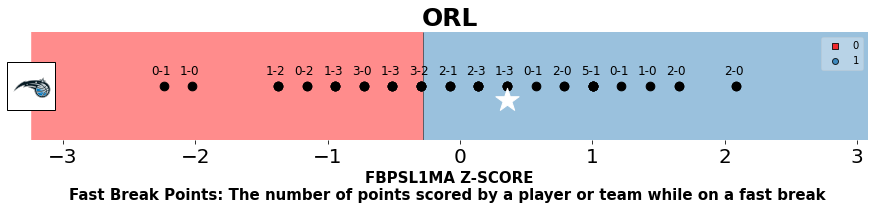

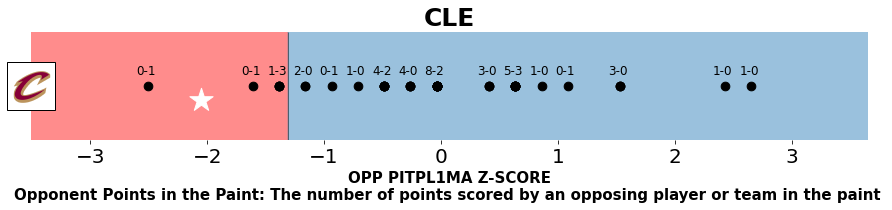

In [1649]:
def showStandardizedMactchPredictions(NBAdf,testDetailsDF,awayTeam,homeTeam,date):  #if Standardized
    awayTeamTestDetails = testDetailsDF[testDetailsDF['TEAM'] == awayTeam]
    awayTeamFeature = awayTeamTestDetails['FEATURE'].values[0]
    fig,ax = plt.subplots(figsize=(15,2)) #plt.figure(figsize=(15,2))
    awayTeamFeatureLabel = awayTeamFeature+' Z-SCORE'+'\n'+getFeatureDefintion(awayTeamFeature)
    plt.title(awayTeam,size=25,fontweight='bold')
    plt.xlabel(awayTeamFeatureLabel,size=15,fontweight='bold')
    plot_decision_regions(getStandardizedTrainData(NBAdf,awayTeam,date,awayTeamFeature)[0],
                          np.array(getStandardizedTrainData(NBAdf,awayTeam,date,awayTeamFeature)[1]).astype('int'),
                          getModel(getStandardizedTrainData(NBAdf,awayTeam,date,awayTeamFeature)[0],
                                   getStandardizedTrainData(NBAdf,awayTeam,date,awayTeamFeature)[1]),markers='so',colors='red,#1f77b4',legend=1)
    modelPredicts = getModel(getStandardizedTrainData(NBAdf,awayTeam,date,awayTeamFeature)[0],
                             getStandardizedTrainData(NBAdf,awayTeam,date,awayTeamFeature)[1]).predict(getStandardizedTrainData(NBAdf,awayTeam,date,awayTeamFeature)[0])
    
    df = pd.concat([pd.DataFrame(getStandardizedTrainData(NBAdf,awayTeam,date,awayTeamFeature)[0],columns=['FEATURE']),
                    pd.DataFrame(getStandardizedTrainData(NBAdf,awayTeam,date,awayTeamFeature)[1],columns=['RESULT']),
                    pd.DataFrame(modelPredicts,columns=['MODEL PREDICTS'])]
                   ,axis=1)
    df = df.sort_values(by='FEATURE')
    
    ax.scatter(df[df['RESULT'] ==0]['FEATURE'],np.full_like(df[df['RESULT'] ==0]['FEATURE'],0),marker='.',c='black',s=300)
    ax.scatter(df[df['RESULT'] ==1]['FEATURE'],np.full_like(df[df['RESULT'] ==1]['FEATURE'],0),marker='.',c='black',s=300)
    ax.scatter(awayTeamTestDetails['PREDICT X_test'],-.25,marker="*",s=600,c='white')
    
    path = '/Users/olutosinfashusi/jupyter/git/predict2023-24NBARegularSeasonGames_LogisticRegression/images/'+awayTeam+'.png'
    ab = AnnotationBbox(getImage(path),
                        (plt.axis()[0],0),
                        frameon=True)
    ax.add_artist(ab)
    
    for i in range (len(np.unique(df['FEATURE'],return_counts=True)[0])):
        df2 = df[df['FEATURE'] == np.unique(df['FEATURE'],return_counts=True)[0][i]]['RESULT']
        numberOfLosses = list(df2.values).count(0)
        numberOfWins = list(df2.values).count(1)
        numberOfGames = numberOfLosses + numberOfWins
        ax.annotate(str(numberOfWins)+'-'+str(numberOfLosses),
                    xy=(np.unique(df['FEATURE'],return_counts=True)[0][i],0),
                    xytext=(-1,1),
                    textcoords='offset fontsize',c='black',
                    fontsize=12)
    plt.xticks(fontsize=20)
    plt.show()
    
    #########################################
    homeTeamTestDetails = testDetailsDF[testDetailsDF['TEAM'] == homeTeam]
    homeTeamFeature = homeTeamTestDetails['FEATURE'].values[0]
    fig,ax = plt.subplots(figsize=(15,2))
    homeTeamFeatureLabel = homeTeamFeature+' Z-SCORE'+'\n'+getFeatureDefintion(homeTeamFeature)
    plt.title(homeTeam,size=25,fontweight='bold')
    plt.xlabel(homeTeamFeatureLabel,size=15,fontweight='bold')
    plot_decision_regions(getStandardizedTrainData(NBAdf,homeTeam,date,homeTeamFeature)[0],
                          np.array(getStandardizedTrainData(NBAdf,homeTeam,date,homeTeamFeature)[1]).astype('int'),
                          getModel(getStandardizedTrainData(NBAdf,homeTeam,date,homeTeamFeature)[0],
                                   getStandardizedTrainData(NBAdf,homeTeam,date,homeTeamFeature)[1]),markers='o',colors='red,#1f77b4',legend=0);
    modelPredicts = getModel(getStandardizedTrainData(NBAdf,homeTeam,date,homeTeamFeature)[0],
                             getStandardizedTrainData(NBAdf,homeTeam,date,homeTeamFeature)[1]).predict(getStandardizedTrainData(NBAdf,homeTeam,date,homeTeamFeature)[0])
    
    df = pd.concat([pd.DataFrame(getStandardizedTrainData(NBAdf,homeTeam,date,homeTeamFeature)[0],columns=['FEATURE']),
                    pd.DataFrame(getStandardizedTrainData(NBAdf,homeTeam,date,homeTeamFeature)[1],columns=['RESULT']),
                    pd.DataFrame(modelPredicts,columns=['MODEL PREDICTS'])]
                   ,axis=1)
    
    df = df.sort_values(by='FEATURE')
    ax.scatter(df[df['RESULT'] ==0]['FEATURE'],np.full_like(df[df['RESULT'] ==0]['FEATURE'],0),marker='.',c='black',s=300)
    ax.scatter(df[df['RESULT'] ==1]['FEATURE'],np.full_like(df[df['RESULT'] ==1]['FEATURE'],0),marker='.',c='black',s=300)
    ax.scatter(homeTeamTestDetails['PREDICT X_test'],-.25,marker="*",s=600,c='white')
    
    path = '/Users/olutosinfashusi/jupyter/git/predict2023-24NBARegularSeasonGames_LogisticRegression/images/'+homeTeam+'.png'
    ab = AnnotationBbox(getImage(path),(plt.axis()[0],0), frameon=True)
    plt.xticks(fontsize=20)
    ax.add_artist(ab)
    for i in range (len(np.unique(df['FEATURE'],return_counts=True)[0])):
        df2 = df[df['FEATURE'] == np.unique(df['FEATURE'],return_counts=True)[0][i]]['RESULT']
        numberOfLosses = list(df2.values).count(0)
        numberOfWins = list(df2.values).count(1)
        ax.annotate(str(numberOfWins)+'-'+str(numberOfLosses),
                    xy=(np.unique(df['FEATURE'],return_counts=True)[0][i],0),
                    xytext=(-1,1),
                    textcoords='offset fontsize',c='black',
                    fontsize=12)
    plt.xticks(fontsize=20)
    plt.show()

for i in range(0,2,2):
    if i%2 == 0:
        showStandardizedMactchPredictions(miscDF,testDetailsDF,
                                          testDetailsDF.iloc[i]['TEAM'],
                                          testDetailsDF.iloc[i+1]['TEAM'],
                                          datetime.date(2024,2,22))

In [ ]:
# ax.annotate(np.unique(df['FEATURE'],return_counts=True)[1][i],
#                     xy=(np.unique(df['FEATURE'],return_counts=True)[0][i],0),
#                     xytext=(0,1),
#                     textcoords='offset fontsize',c='black',
#                     fontsize=15)

In [1414]:
# # for i in range(0,len(testDetailsDF),2):
# for i in range(0,2,2):
#     if i%2 == 0:
# #         print('MACTH UP:',testDetailsDF.iloc[i]['TEAM'],'@',testDetailsDF.iloc[i+1]['TEAM'])
# #         print('DATE',testDetailsDF.iloc[i]['DATE'])
# #         print('AWAY TEAM:',testDetailsDF.iloc[i]['TEAM'])
# #         print('FEATURE:',testDetailsDF.iloc[i]['FEATURE'])
# #         print('X_test:',testDetailsDF.iloc[i]['PREDICT X_test'])
# #         print('PROBABILITY ESTIMATE:',testDetailsDF.iloc[i]['PROBABILITY ESTIMATE'])
# #         printFeatureDefintion(testDetailsDF.iloc[i]['FEATURE'])
# #         print()
# #         print('HOME TEAM:',testDetailsDF.iloc[i+1]['TEAM'],'FEATURE:',testDetailsDF.iloc[i+1]['FEATURE'],'X_test:',testDetailsDF.iloc[i+1]['PREDICT X_test'])
# #         print('PROBABILITY ESTIMATE:',testDetailsDF.iloc[i+1]['PROBABILITY ESTIMATE'])
# #         printFeatureDefintion(testDetailsDF.iloc[i+1]['FEATURE'])
# #         print()
# #         probabilityEstimates = np.array([testDetailsDF.iloc[i]['PROBABILITY ESTIMATE'],testDetailsDF.iloc[i+1]['PROBABILITY ESTIMATE']])
# #         actualWinner = np.array([testDetailsDF.iloc[i]['ACTUAL RESULT'],testDetailsDF.iloc[i+1]['ACTUAL RESULT']])
# #         print('MODEL PREDICTS:',testDetailsDF.iloc[np.argmax(probabilityEstimates)+i]['TEAM'])
# #         print('ACTUAL WINNNER:',testDetailsDF.iloc[np.argmax(actualWinner)+i]['TEAM'])
#         showStandardizedMactchPredictions(miscDF,testDetailsDF,
#                                       testDetailsDF.iloc[i]['TEAM'],testDetailsDF.iloc[i+1]['TEAM'],
#                                       datetime.date(2024,2,22))

In [1424]:
print( ((12-3)/12)*100)

75.0


In [1547]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.ticker as mtick 
from matplotlib.ticker import PercentFormatter 

def getImage(path, zoom=1): return OffsetImage(plt.imread(path), zoom=zoom)
NBATeams =['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL','MEM',
           'MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WAS']

paths = []
for team in NBATeams:
    paths.append('/Users/olutosinfashusi/jupyter/git/predict2023-24NBARegularSeasonGames_LogisticRegression/images/'+team+'.png')

In [1548]:
import copy
testDetailsDF = copy.deepcopy(miscTestDetails[datetime.date(2024,2,22)]['standardized']['oddsRatio']['testDetailsDF'])

In [1549]:
#testDetailsDF
miscTestDetails

In [1550]:
# defintions = []
# for feature in testDetailsDF[0:2]['FEATURE'].values:
#     defintions.append(getFeatureDefintion(feature))
# defintionsDF = pd.DataFrame(testDetailsDF[0:2]['FEATURE'].values)
# defintionsDF['DEFINTION'] = defintions
# defintionsDF

In [1551]:
# NBAdf = miscDF
# defintion = []
# for i in range (len(testDetailsDF)):
#     defintion.append(getFeatureDefintion(testDetailsDF.iloc[i]['FEATURE']))
# testDetailsDF['DEFINTION'] = defintion      

In [1552]:
# testDetailsDF.insert(5,'DEFINTION',pd.DataFrame(defintion))

# #testDetailsDF = testDetailsDF.rename=['DEFINTION'])

In [1553]:
#pd.concat(['standardizedOddsRatio'])[0:12]

## miscDF+standardizedOddsRatio, FEATURES BY ALL TEAMS

In [1554]:
seasonTestDetailsDF = copy.deepcopy(getSeasonTestDetailsDF(miscDF,miscModelTypeResults,'standardized','oddsRatio'))

NameError: name 'miscModelTypeResults' is not defined

In [1555]:
miscTestDetailsCopy = copy.deepcopy(miscTestDetails)

In [1544]:
#seasonTestDetailsDF[seasonTestDetailsDF['TEAM'] == 'ORL'].reset_index(drop=True)

In [1545]:
seasonTestDetailsDF[seasonTestDetailsDF['TEAM'] == 'CLE'].reset_index(drop=True).head(1)

NameError: name 'seasonTestDetailsDF' is not defined

In [1757]:
leagueFeaturesDF = getFeaturesByTeam(miscDF,miscTestDetailsCopy,'standardized','oddsRatio')
leagueFeaturesDF.sort_values(by=['COUNT','FEATURE'],ascending=False).reset_index(drop=True)
leagueFeaturesDF

TEAM             FEATURE COUNT
0   ATL         2ND PTSL3MA    27
1   BKN     OPP 2ND PTSL5MA    23
2   BKN     OPP 2ND PTSL3MA     5
3   BOS     OPP 2ND PTSL2MA     8
4   BOS         2ND PTSL5MA     7
5   BOS        OPP FBPSL5MA     6
6   BOS         2ND PTSL1MA     5
7   BOS            FBPSL1MA     1
8   CHA  OPP PTS OFF TOL1MA    28
9   CHI  OPP PTS OFF TOL5MA    11
10  CHI  OPP PTS OFF TOL1MA     6
11  CHI  OPP PTS OFF TOL4MA     5
12  CHI  OPP PTS OFF TOL3MA     4
13  CHI        OPP FBPSL4MA     1
14  CLE        OPP PITPL1MA    27
15  CLE            PITPL1MA     2
16  DAL     OPP 2ND PTSL1MA    21
17  DAL            FBPSL2MA     6
18  DEN        OPP FBPSL4MA    24
19  DEN     OPP 2ND PTSL2MA     2
20  DEN         2ND PTSL1MA     1
21  DET         2ND PTSL2MA     9
22  DET     OPP 2ND PTSL1MA     9
23  DET        OPP PITPL3MA     4
24  DET        OPP PITPL4MA     4
25  DET  OPP PTS OFF TOL1MA     2
26  GSW        OPP FBPSL1MA    17
27  GSW     OPP 2ND PTSL2MA    11
28  GSW        OPP FBPSL2MA     1
29  HOU     OPP 2ND PTSL5MA    20
30  HOU            FBPSL1MA     4
31  HOU      PTS OFF TOL3MA     3
32  HOU  OPP PTS OFF TOL4MA     1
33  IND        OPP PITPL1MA    16
34  IND     OPP 2ND PTSL1MA     8
35  IND      PTS OFF TOL1MA     2
36  LAC      PTS OFF TOL1MA    29
37  LAL        OPP FBPSL1MA    19
38  LAL        OPP FBPSL3MA     5
39  LAL        OPP FBPSL2MA     2
40  MEM            FBPSL1MA    26
41  MIA      PTS OFF TOL5MA    12
42  MIA        OPP FBPSL5MA    10
43  MIA        OPP FBPSL4MA     5
44  MIL  OPP PTS OFF TOL4MA    21
45  MIL            PITPL5MA     3
46  MIL     OPP 2ND PTSL2MA     2
47  MIN     OPP 2ND PTSL1MA    15
48  MIN     OPP 2ND PTSL4MA     7
49  MIN  OPP PTS OFF TOL2MA     5
50  NOP      PTS OFF TOL1MA    20
51  NOP        OPP FBPSL5MA     7
52  NYK      PTS OFF TOL2MA    11
53  NYK         2ND PTSL1MA     8
54  NYK  OPP PTS OFF TOL5MA     8
55  OKC            FBPSL1MA    28
56  ORL            FBPSL1MA    26
57  ORL  OPP PTS OFF TOL1MA     1
58  PHI  OPP PTS OFF TOL5MA    19
59  PHI  OPP PTS OFF TOL4MA     7
60  PHI        OPP FBPSL5MA     1
61  PHI  OPP PTS OFF TOL3MA     1
62  PHX     OPP 2ND PTSL1MA    14
63  PHX     OPP 2ND PTSL3MA     8
64  PHX     OPP 2ND PTSL2MA     5
65  POR         2ND PTSL4MA    21
66  POR         2ND PTSL5MA     7
67  SAC     OPP 2ND PTSL1MA    20
68  SAC         2ND PTSL1MA     7
69  SAC        OPP PITPL2MA     1
70  SAS        OPP FBPSL2MA    18
71  SAS            FBPSL1MA     6
72  SAS            FBPSL3MA     2
73  SAS        OPP FBPSL1MA     1
74  TOR            FBPSL2MA    15
75  TOR            PITPL4MA     8
76  TOR     OPP 2ND PTSL2MA     2
77  TOR     OPP 2ND PTSL1MA     1
78  TOR        OPP FBPSL4MA     1
79  UTA            PITPL5MA    22
80  UTA      PTS OFF TOL5MA     4
81  WAS  OPP PTS OFF TOL3MA    13
82  WAS  OPP PTS OFF TOL5MA    11
83  WAS        OPP FBPSL3MA     2
84  WAS            PITPL4MA     2

In [1756]:
total = []
for team in leagueFeaturesDF['TEAM']:
    teamDF = leagueFeaturesDF[leagueFeaturesDF['TEAM'] == team]
    total.append(np.sum(teamDF['COUNT'].values))
leagueFeaturesDF['TOTAL'] = total
leagueFeaturesDF

TEAM             FEATURE COUNT  TOTAL
0   ATL         2ND PTSL3MA    27     27
1   BKN     OPP 2ND PTSL5MA    23     28
2   BKN     OPP 2ND PTSL3MA     5     28
3   BOS     OPP 2ND PTSL2MA     8     27
4   BOS         2ND PTSL5MA     7     27
5   BOS        OPP FBPSL5MA     6     27
6   BOS         2ND PTSL1MA     5     27
7   BOS            FBPSL1MA     1     27
8   CHA  OPP PTS OFF TOL1MA    28     28
9   CHI  OPP PTS OFF TOL5MA    11     27
10  CHI  OPP PTS OFF TOL1MA     6     27
11  CHI  OPP PTS OFF TOL4MA     5     27
12  CHI  OPP PTS OFF TOL3MA     4     27
13  CHI        OPP FBPSL4MA     1     27
14  CLE        OPP PITPL1MA    27     29
15  CLE            PITPL1MA     2     29
16  DAL     OPP 2ND PTSL1MA    21     27
17  DAL            FBPSL2MA     6     27
18  DEN        OPP FBPSL4MA    24     27
19  DEN     OPP 2ND PTSL2MA     2     27
20  DEN         2ND PTSL1MA     1     27
21  DET         2ND PTSL2MA     9     28
22  DET     OPP 2ND PTSL1MA     9     28
23  DET        OPP PITPL3MA     4     28
24  DET        OPP PITPL4MA     4     28
25  DET  OPP PTS OFF TOL1MA     2     28
26  GSW        OPP FBPSL1MA    17     29
27  GSW     OPP 2ND PTSL2MA    11     29
28  GSW        OPP FBPSL2MA     1     29
29  HOU     OPP 2ND PTSL5MA    20     28
30  HOU            FBPSL1MA     4     28
31  HOU      PTS OFF TOL3MA     3     28
32  HOU  OPP PTS OFF TOL4MA     1     28
33  IND        OPP PITPL1MA    16     26
34  IND     OPP 2ND PTSL1MA     8     26
35  IND      PTS OFF TOL1MA     2     26
36  LAC      PTS OFF TOL1MA    29     29
37  LAL        OPP FBPSL1MA    19     26
38  LAL        OPP FBPSL3MA     5     26
39  LAL        OPP FBPSL2MA     2     26
40  MEM            FBPSL1MA    26     26
41  MIA      PTS OFF TOL5MA    12     27
42  MIA        OPP FBPSL5MA    10     27
43  MIA        OPP FBPSL4MA     5     27
44  MIL  OPP PTS OFF TOL4MA    21     26
45  MIL            PITPL5MA     3     26
46  MIL     OPP 2ND PTSL2MA     2     26
47  MIN     OPP 2ND PTSL1MA    15     27
48  MIN     OPP 2ND PTSL4MA     7     27
49  MIN  OPP PTS OFF TOL2MA     5     27
50  NOP      PTS OFF TOL1MA    20     27
51  NOP        OPP FBPSL5MA     7     27
52  NYK      PTS OFF TOL2MA    11     27
53  NYK         2ND PTSL1MA     8     27
54  NYK  OPP PTS OFF TOL5MA     8     27
55  OKC            FBPSL1MA    28     28
56  ORL            FBPSL1MA    26     27
57  ORL  OPP PTS OFF TOL1MA     1     27
58  PHI  OPP PTS OFF TOL5MA    19     28
59  PHI  OPP PTS OFF TOL4MA     7     28
60  PHI        OPP FBPSL5MA     1     28
61  PHI  OPP PTS OFF TOL3MA     1     28
62  PHX     OPP 2ND PTSL1MA    14     27
63  PHX     OPP 2ND PTSL3MA     8     27
64  PHX     OPP 2ND PTSL2MA     5     27
65  POR         2ND PTSL4MA    21     28
66  POR         2ND PTSL5MA     7     28
67  SAC     OPP 2ND PTSL1MA    20     28
68  SAC         2ND PTSL1MA     7     28
69  SAC        OPP PITPL2MA     1     28
70  SAS        OPP FBPSL2MA    18     27
71  SAS            FBPSL1MA     6     27
72  SAS            FBPSL3MA     2     27
73  SAS        OPP FBPSL1MA     1     27
74  TOR            FBPSL2MA    15     27
75  TOR            PITPL4MA     8     27
76  TOR     OPP 2ND PTSL2MA     2     27
77  TOR     OPP 2ND PTSL1MA     1     27
78  TOR        OPP FBPSL4MA     1     27
79  UTA            PITPL5MA    22     26
80  UTA      PTS OFF TOL5MA     4     26
81  WAS  OPP PTS OFF TOL3MA    13     28
82  WAS  OPP PTS OFF TOL5MA    11     28
83  WAS        OPP FBPSL3MA     2     28
84  WAS            PITPL4MA     2     28

In [1558]:
pd.DataFrame(np.unique(leagueFeaturesDF['FEATURE'],return_counts=True)).T.rename(columns={0:'FEATURE',1:'COUNT'}).sort_values(by='COUNT',ascending=False).head()

FEATURE COUNT
8      OPP 2ND PTSL1MA     7
5             FBPSL1MA     6
9      OPP 2ND PTSL2MA     6
0          2ND PTSL1MA     4
26  OPP PTS OFF TOL5MA     4

In [1559]:
sameFeatureDF = pd.DataFrame()
for i in range(len(leagueFeaturesDF)):
    if leagueFeaturesDF.iloc[i]['COUNT'] == leagueFeaturesDF.iloc[i]['TOTAL']:
        #df = df.append(leagueFeaturesDF.iloc[i])
        sameFeatureDF = pd.concat([sameFeatureDF,
                      leagueFeaturesDF.iloc[i].to_frame().T],axis=0)
sameFeatureDF = sameFeatureDF.reset_index(drop=True)
sameFeatureDF

TEAM             FEATURE COUNT TOTAL
0  ATL         2ND PTSL3MA    27    27
1  CHA  OPP PTS OFF TOL1MA    28    28
2  LAC      PTS OFF TOL1MA    29    29
3  MEM            FBPSL1MA    26    26
4  OKC            FBPSL1MA    28    28

In [1560]:
sameFeatureDF = pd.DataFrame()
for i in range(len(leagueFeaturesDF)):
    if leagueFeaturesDF.iloc[i]['COUNT'] == leagueFeaturesDF.iloc[i]['TOTAL']:
        #df = df.append(leagueFeaturesDF.iloc[i])
        sameFeatureDF = pd.concat([sameFeatureDF,
                      leagueFeaturesDF.iloc[i].to_frame().T],axis=0)
sameFeatureDF = sameFeatureDF.reset_index(drop=True)
sameFeatureDF

TEAM             FEATURE COUNT TOTAL
0  ATL         2ND PTSL3MA    27    27
1  CHA  OPP PTS OFF TOL1MA    28    28
2  LAC      PTS OFF TOL1MA    29    29
3  MEM            FBPSL1MA    26    26
4  OKC            FBPSL1MA    28    28

In [1755]:
maxFeatureDF = pd.DataFrame()
total = []
defintions = []
string_ = []
for team in np.unique(miscDF['TEAM']):
    teamDF = leagueFeaturesDF[leagueFeaturesDF['TEAM'] == team]
    total.append(np.sum(teamDF['COUNT'].values))
    
    maxFeatureDF = pd.concat([maxFeatureDF,teamDF.head(1)],axis=0)
#    maxFeatureDF = maxFeatureDF.reset_index(drop=True)
#     defintions.append(getFeatureDefintion(teamDF['FEATURE'].values[0]))
#     string_.append(str(teamDF['COUNT'].values[0]) +'/'+str(total[-1]))

# maxFeatureDF['FREQUENCY'] = string_
# maxFeatureDF['FEATURE DEFINTION'] =  defintions
# #maxFeatureDF = maxFeatureDF.rename(columns={'FEATURE':'MAX FEATURE'})
# maxFeatureDF = maxFeatureDF.drop(columns='COUNT')
# maxFeatureDF = maxFeatureDF.drop(columns='TOTAL')
maxFeatureDF

TEAM             FEATURE COUNT  TOTAL
0   ATL         2ND PTSL3MA    27     27
1   BKN     OPP 2ND PTSL5MA    23     28
3   BOS     OPP 2ND PTSL2MA     8     27
8   CHA  OPP PTS OFF TOL1MA    28     28
9   CHI  OPP PTS OFF TOL5MA    11     27
14  CLE        OPP PITPL1MA    27     29
16  DAL     OPP 2ND PTSL1MA    21     27
18  DEN        OPP FBPSL4MA    24     27
21  DET         2ND PTSL2MA     9     28
26  GSW        OPP FBPSL1MA    17     29
29  HOU     OPP 2ND PTSL5MA    20     28
33  IND        OPP PITPL1MA    16     26
36  LAC      PTS OFF TOL1MA    29     29
37  LAL        OPP FBPSL1MA    19     26
40  MEM            FBPSL1MA    26     26
41  MIA      PTS OFF TOL5MA    12     27
44  MIL  OPP PTS OFF TOL4MA    21     26
47  MIN     OPP 2ND PTSL1MA    15     27
50  NOP      PTS OFF TOL1MA    20     27
52  NYK      PTS OFF TOL2MA    11     27
55  OKC            FBPSL1MA    28     28
56  ORL            FBPSL1MA    26     27
58  PHI  OPP PTS OFF TOL5MA    19     28
62  PHX     OPP 2ND PTSL1MA    14     27
65  POR         2ND PTSL4MA    21     28
67  SAC     OPP 2ND PTSL1MA    20     28
70  SAS        OPP FBPSL2MA    18     27
74  TOR            FBPSL2MA    15     27
79  UTA            PITPL5MA    22     26
81  WAS  OPP PTS OFF TOL3MA    13     28

In [1564]:
maxFeatureDF = pd.DataFrame()
total = []
defintions = []
string_ = []
for team in np.unique(miscDF['TEAM']):
    teamDF = leagueFeaturesDF[leagueFeaturesDF['TEAM'] == team]
    total.append(np.sum(teamDF['COUNT'].values))
    
    maxFeatureDF = pd.concat([maxFeatureDF,teamDF.head(1)],axis=0)
    maxFeatureDF = maxFeatureDF.reset_index(drop=True)
    defintions.append(getFeatureDefintion(teamDF['FEATURE'].values[0]))
    string_.append(str(teamDF['COUNT'].values[0]) +'/'+str(total[-1]))

maxFeatureDF['FREQUENCY'] = string_
maxFeatureDF['FEATURE DEFINTION'] =  defintions
# maxFeatureDF = maxFeatureDF.rename(columns={'FEATURE':'MAX FEATURE'})
maxFeatureDF

sameFeatureDF = pd.DataFrame()
for i in range(len(maxFeatureDF)):
    if maxFeatureDF.iloc[i]['COUNT'] == maxFeatureDF.iloc[i]['TOTAL']:
        sameFeatureDF = pd.concat([sameFeatureDF,
                                   maxFeatureDF.iloc[i].to_frame().T],axis=0)
sameFeatureDF = sameFeatureDF.reset_index(drop=True)
sameFeatureDF = sameFeatureDF.drop(columns='COUNT')
sameFeatureDF = sameFeatureDF.drop(columns='TOTAL')
sameFeatureDF

TEAM             FEATURE FREQUENCY  \
0  ATL         2ND PTSL3MA     27/27   
1  CHA  OPP PTS OFF TOL1MA     28/28   
2  LAC      PTS OFF TOL1MA     29/29   
3  MEM            FBPSL1MA     26/26   
4  OKC            FBPSL1MA     28/28   

                                                                                                                     FEATURE DEFINTION  
0  Second Chance Points: The percentage of isolation plays where a player or team shoots free throws as the result of a shooting foul   
1                       Opponent Points off Turnovers: The number of points scored by an opposing player or team following a turnover   
2                              Points off Turnovers: The number of points scored by a player or team following an opponent's turnover   
3                                            Fast Break Points: The number of points scored by a player or team while on a fast break   
4                                            Fast Break Points: The number of points scored by a player or team while on a fast break

In [1565]:
# plt.scatter(teamDF[teamDF['RESULT'] == 1]['X_test'].values,
#            np.zeros(len(teamDF[teamDF['RESULT'] == 1]['X_test'].values)),
#             color='blue',marker='o',s=200,alpha=.3)

In [1566]:
# import copy
# miscDF_copy = copy.deepcopy(miscDF)

In [1567]:
# miscDF['SPREAD'].describe()

In [1568]:
# results = {}
# feature = '2ND PTSL3MA'

# for team in np.unique(miscDF['TEAM']):
#     results[team] = {'describeL':pd.Series,'describeW':pd.Series}
# descriptiveStatistics = ['mean','std','min','25%','50%','75%','max']
# for team in np.unique(miscDF['TEAM']):
#     results[team] = {}
#     for statistic in descriptiveStatistics:
#         results[team] = []
        
# for team in np.unique(miscDF['TEAM']):
    
#     for statistic in descriptiveStatistics:
#         results[team].append(miscDF[(miscDF['TEAM'] == team) & (miscDF['RESULT'] == 0)][feature].describe()[statistic])
#         results[team].append(miscDF[(miscDF['TEAM'] == team) & (miscDF['RESULT'] == 1)][feature].describe()[statistic])
# df = pd.DataFrame(results).T.rename(columns= {0:'meanL',
#                                               1:'stdL',
#                                               2:'minL',
#                                               3:'25L%',
#                                               4:'50%L',
#                                               5:'75%L',
#                                               6:'maxL',
                                              
#                                               7:'meanW',
#                                               8:'stdW',
#                                               9:'minW',
#                                               10:'25W%',
#                                               11:'50%W',
#                                               12:'75%W',
#                                               13:'maxW',
#                                              })
# df

In [1569]:
#teamDF[teamDF['RESULT'] == 0]['X_test']

In [1570]:
# results = {}
# feature = '2ND PTSL3MA'

# for team in np.unique(miscDF['TEAM']):
#     results[team] = {'describeL':pd.Series,'describeW':pd.Series}
# descriptiveStatistics = ['mean','std','min','25%','50%','75%','max']
# for team in np.unique(miscDF['TEAM']):
#     results[team] = {}
#     for statistic in descriptiveStatistics:
#         results[team] = []
        
# for team in np.unique(miscDF['TEAM']):
#     teamDF = miscDF[miscDF['TEAM'] == team]
#     teamDF = teamDF[teamDF['DATE'] < datetime.date(2024,4,15)]
#     teamDF = teamDF.reset_index(drop=True)
#     teamDF = teamDF.dropna()
#     teamDF['X_test'] = stats.zscore(teamDF[feature])
#     for statistic in descriptiveStatistics:
#         results[team].append(teamDF[teamDF['RESULT'] == 0]['X_test'].describe()[statistic])
#         results[team].append(teamDF[teamDF['RESULT'] == 1]['X_test'].describe()[statistic])
# df = pd.DataFrame(results).T.rename(columns= {0:'meanL',
#                                               1:'stdL',
#                                               2:'minL',
#                                               3:'25L%',
#                                               4:'50%L',
#                                               5:'75%L',
#                                               6:'maxL',
                                              
#                                               7:'meanW',
#                                               8:'stdW',
#                                               9:'minW',
#                                               10:'25W%',
#                                               11:'50%W',
#                                               12:'75%W',
#                                               13:'maxW',
#                                              })

In [1571]:
# df.head(1)

In [1572]:
# df.head(1)

In [1573]:
# df
# # deltaDF = pd.DataFrame(df['meanW'] - df['meanL'],columns=['delta'])
# # deltaDF
# #deltaDF.sort_values(by='delta',ascending=False)
# #df.sort_values(by='meanW',ascending=False).head()

In [1574]:
# resultsDF = pd.DataFrame()
# for team in np.unique(miscDF['TEAM']):
#     df = pd.DataFrame(results[]).T
#     #df.insert(0,'TEAM',[team,team])
#     STOP
# #     resultsDF = pd.concat([resultsDF,
# #                           df],axis=0)

In [1575]:
#df

In [1576]:
# plt.figure(figsize=(30,10))
# miscDF_copy = miscDF_copy.dropna()
# miscDF_copy = miscDF_copy.reset_index(drop=True)

# feature = 'PTS OFF TO'
# #miscDF_copy['X_test'] = stats.zscore(miscDF_copy[feature])
# miscDF_copy['X_test'] = miscDF_copy[feature]

# # res = stats.linregress(teamDF[teamDF['RESULT'] == 0].index,teamDF[teamDF['RESULT'] == 0]['X_test'])
# # plt.plot(teamDF[teamDF['RESULT'] == 0].index, res.intercept + res.slope*teamDF[teamDF['RESULT'] == 0].index, 'r-.')

# # res = stats.linregress(teamDF[teamDF['RESULT'] == 1].index,teamDF[teamDF['RESULT'] == 1]['X_test'])
# # plt.plot(teamDF[teamDF['RESULT'] == 1].index, res.intercept + res.slope*teamDF[teamDF['RESULT'] == 1].index, 'b-.')


# plt.scatter(miscDF_copy[miscDF_copy['RESULT'] == 0].index,
#             miscDF_copy[miscDF_copy['RESULT'] == 0]['X_test'].values,color='red',marker='.',s=100)

# plt.scatter(miscDF_copy[miscDF_copy['RESULT'] == 1].index,
#             miscDF_copy[miscDF_copy['RESULT'] == 1]['X_test'].values,color='blue',marker='.',s=100)

In [1577]:
# miscDF_copy[miscDF_copy['RESULT'] == 0]['X_test']

In [1609]:
sameFeatureDF

TEAM             FEATURE FREQUENCY  \
0  ATL         2ND PTSL3MA     27/27   
1  CHA  OPP PTS OFF TOL1MA     28/28   
2  LAC      PTS OFF TOL1MA     29/29   
3  MEM            FBPSL1MA     26/26   
4  OKC            FBPSL1MA     28/28   

                                                                                                                     FEATURE DEFINTION  
0  Second Chance Points: The percentage of isolation plays where a player or team shoots free throws as the result of a shooting foul   
1                       Opponent Points off Turnovers: The number of points scored by an opposing player or team following a turnover   
2                              Points off Turnovers: The number of points scored by a player or team following an opponent's turnover   
3                                            Fast Break Points: The number of points scored by a player or team while on a fast break   
4                                            Fast Break Points: The number of points scored by a player or team while on a fast break

In [1636]:
feature = '2ND PTSL3MA'
results = {}
for team in NBATeams:
    results[team] = {'2ND PTSL3MA AVG IN Ws':float,'2ND PTSL3MA AVG IN Ls':float}
for team in NBATeams:
    teamDF = miscDF[miscDF['TEAM'] == team]
    results[team]['2ND PTSL3MA AVG IN Ws'] = teamDF[teamDF['RESULT'] == 1][feature].mean()
    results[team]['2ND PTSL3MA AVG IN Ls'] = teamDF[teamDF['RESULT'] == 0][feature].mean()
df = pd.DataFrame(results).T
df['∆'] = df['2ND PTSL3MA AVG IN Ws'] - df['2ND PTSL3MA AVG IN Ls']

df.sort_values(by='∆',ascending=False)
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df.sort_values(by='∆',ascending=False).reset_index(drop=True)

TEAM  2ND PTSL3MA AVG IN Ws  2ND PTSL3MA AVG IN Ls         ∆
0   ATL              17.552381              14.750000  2.802381
1   MIL              13.645390              12.552083  1.093307
2   CLE              13.950355              12.864583  1.085771
3   POR              16.412698              15.522989  0.889710
4   SAC              14.848485              14.257143  0.591342
5   MIA              11.585185              11.078431  0.506754
6   BOS              14.655738              14.203704  0.452034
7   CHI              13.780702              13.463415  0.317287
8   MIN              13.515152              13.236111  0.279040
9   DET              13.277778              13.049751  0.228027
10  WAS              11.571429              11.425641  0.145788
11  UTA              16.377778              16.387755 -0.009977
12  DEN              13.487654              13.533333 -0.045679
13  MEM              13.172840              13.371795 -0.198955
14  CHA              11.966667              12.237288 -0.270621
15  PHI              14.874074              15.245098 -0.371024
16  LAL              10.369565              10.808081 -0.438516
17  GSW              15.446970              15.885714 -0.438745
18  TOR              13.444444              13.921212 -0.476768
19  DAL              13.141844              13.729167 -0.587323
20  SAS              12.190476              12.850575 -0.660099
21  LAC              12.285714              13.011111 -0.725397
22  PHX              12.411348              13.166667 -0.755319
23  OKC              11.466667              12.263889 -0.797222
24  NOP              13.794326              14.677083 -0.882757
25  BKN              13.913978              14.826389 -0.912410
26  NYK              15.687075              16.800000 -1.112925
27  ORL              13.940741              15.196078 -1.255338
28  HOU              13.780488              15.140351 -1.359863
29  IND              14.170370              15.656863 -1.486492

In [1640]:
feature = 'OPP PTS OFF TOL1MA'
results = {}
for team in NBATeams:
    results[team] = {'OPP PTS OFF TOL1MA AVG IN Ws':float ,'OPP PTS OFF TOL1MA AVG IN Ls':float}
for team in NBATeams:
    teamDF = miscDF[miscDF['TEAM'] == team]
    results[team]['OPP PTS OFF TOL1MA AVG IN Ws'] = teamDF[teamDF['RESULT'] == 1][feature].mean()
    results[team]['OPP PTS OFF TOL1MA AVG IN Ls'] = teamDF[teamDF['RESULT'] == 0][feature].mean()
df = pd.DataFrame(results).T
df['∆'] = df['OPP PTS OFF TOL1MA AVG IN Ws'] - df['OPP PTS OFF TOL1MA AVG IN Ls']

df.sort_values(by='∆',ascending=False)
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df.sort_values(by='∆',ascending=False).reset_index(drop=True)

TEAM  OPP PTS OFF TOL1MA AVG IN Ws  OPP PTS OFF TOL1MA AVG IN Ls         ∆
0   DET                     22.500000                     19.029851  3.470149
1   ORL                     17.565217                     15.114286  2.450932
2   SAS                     20.363636                     18.050847  2.312789
3   CHA                     18.900000                     16.590164  2.309836
4   GSW                     18.217391                     16.171429  2.045963
5   PHI                     15.021277                     13.382353  1.638924
6   WAS                     18.000000                     16.803030  1.196970
7   CHI                     15.871795                     14.738095  1.133700
8   MIN                     16.410714                     15.320000  1.090714
9   BKN                     15.906250                     15.122449  0.783801
10  DAL                     15.224490                     14.687500  0.536990
11  CLE                     17.531915                     17.088235  0.443680
12  MEM                     18.703704                     18.370370  0.333333
13  DEN                     15.857143                     15.560000  0.297143
14  SAC                     16.488889                     16.333333  0.155556
15  PHX                     18.270833                     18.151515  0.119318
16  IND                     15.847826                     15.771429  0.076398
17  ATL                     16.472222                     16.577778 -0.105556
18  MIA                     15.666667                     15.861111 -0.194444
19  NOP                     15.375000                     15.606061 -0.231061
20  TOR                     16.750000                     17.210526 -0.460526
21  NYK                     14.680000                     15.161290 -0.481290
22  MIL                     14.645833                     15.151515 -0.505682
23  LAL                     16.723404                     17.558824 -0.835419
24  UTA                     18.483871                     19.580000 -1.096129
25  LAC                     15.280000                     16.483871 -1.203871
26  HOU                     14.219512                     15.525000 -1.305488
27  OKC                     14.125000                     16.080000 -1.955000
28  POR                     17.333333                     19.600000 -2.266667
29  BOS                     12.682540                     15.000000 -2.317460

In [1642]:
feature = 'PTS OFF TOL1MA'
results = {}
for team in NBATeams:
    results[team] = {'PTS OFF TOL1MA AVG IN Ws':float ,'PTS OFF TOL1MA AVG IN Ls':float}
for team in NBATeams:
    teamDF = miscDF[miscDF['TEAM'] == team]
    results[team]['PTS OFF TOL1MA AVG IN Ws'] = teamDF[teamDF['RESULT'] == 1][feature].mean()
    results[team]['PTS OFF TOL1MA AVG IN Ls'] = teamDF[teamDF['RESULT'] == 0][feature].mean()
df = pd.DataFrame(results).T
df['∆'] = df['PTS OFF TOL1MA AVG IN Ws'] - df['PTS OFF TOL1MA AVG IN Ls']

df.sort_values(by='∆',ascending=False)
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df.sort_values(by='∆',ascending=False).reset_index(drop=True)

TEAM  PTS OFF TOL1MA AVG IN Ws  PTS OFF TOL1MA AVG IN Ls         ∆
0   LAC                 17.260000                 14.354839  2.905161
1   ORL                 19.434783                 17.314286  2.120497
2   NOP                 18.500000                 16.454545  2.045455
3   DAL                 17.224490                 15.312500  1.911990
4   CHI                 18.076923                 16.309524  1.767399
5   PHI                 18.340426                 17.058824  1.281602
6   IND                 18.065217                 16.971429  1.093789
7   SAS                 15.772727                 15.118644  0.654083
8   DEN                 15.732143                 15.080000  0.652143
9   ATL                 17.444444                 16.911111  0.533333
10  CLE                 16.808511                 16.470588  0.337922
11  BOS                 15.444444                 15.166667  0.277778
12  BKN                 14.968750                 14.877551  0.091199
13  POR                 15.523810                 15.850000 -0.326190
14  PHX                 15.416667                 15.757576 -0.340909
15  MIA                 16.155556                 16.500000 -0.344444
16  MIN                 16.892857                 17.280000 -0.387143
17  SAC                 16.155556                 16.666667 -0.511111
18  TOR                 15.708333                 16.298246 -0.589912
19  MEM                 16.851852                 17.500000 -0.648148
20  UTA                 14.516129                 15.300000 -0.783871
21  OKC                 20.125000                 21.040000 -0.915000
22  LAL                 15.808511                 16.764706 -0.956195
23  HOU                 15.902439                 17.000000 -1.097561
24  NYK                 16.240000                 17.548387 -1.308387
25  WAS                 15.600000                 17.454545 -1.854545
26  GSW                 14.978261                 17.142857 -2.164596
27  MIL                 13.604167                 16.000000 -2.395833
28  DET                 12.142857                 15.000000 -2.857143
29  CHA                 12.400000                 16.114754 -3.714754

In [1643]:
feature = 'FBPSL1MA'
results = {}
for team in NBATeams:
    results[team] = {'FBPSL1MA AVG IN Ws':float ,'FBPSL1MA AVG IN Ls':float}
for team in NBATeams:
    teamDF = miscDF[miscDF['TEAM'] == team]
    results[team]['FBPSL1MA AVG IN Ws'] = teamDF[teamDF['RESULT'] == 1][feature].mean()
    results[team]['FBPSL1MA AVG IN Ls'] = teamDF[teamDF['RESULT'] == 0][feature].mean()
df = pd.DataFrame(results).T
df['∆'] = df['FBPSL1MA AVG IN Ws'] - df['FBPSL1MA AVG IN Ls']

df.sort_values(by='∆',ascending=False)
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df.sort_values(by='∆',ascending=False).reset_index(drop=True)

TEAM  FBPSL1MA AVG IN Ws  FBPSL1MA AVG IN Ls         ∆
0   OKC           16.625000           13.920000  2.705000
1   ORL           13.282609           10.971429  2.311180
2   SAS           17.090909           14.881356  2.209553
3   MEM           12.962963           11.018519  1.944444
4   HOU           16.658537           14.825000  1.833537
5   DEN           14.589286           13.400000  1.189286
6   GSW           12.869565           11.742857  1.126708
7   CHI           12.974359           11.952381  1.021978
8   TOR           19.500000           18.508772  0.991228
9   CLE           15.170213           14.264706  0.905507
10  BOS           15.285714           14.722222  0.563492
11  NOP           15.291667           14.939394  0.352273
12  SAC           14.355556           14.055556  0.300000
13  IND           16.391304           16.514286 -0.122981
14  DAL           15.469388           15.843750 -0.374362
15  MIA           12.555556           13.000000 -0.444444
16  ATL           13.111111           13.622222 -0.511111
17  LAC           14.480000           15.032258 -0.552258
18  CHA           11.950000           12.573770 -0.623770
19  NYK           14.360000           15.354839 -0.994839
20  PHI           15.106383           16.382353 -1.275970
21  MIN           11.928571           13.640000 -1.711429
22  MIL           12.104167           13.848485 -1.744318
23  POR           11.380952           13.283333 -1.902381
24  BKN           11.937500           13.918367 -1.980867
25  UTA           12.612903           14.680000 -2.067097
26  PHX           12.187500           14.878788 -2.691288
27  WAS           15.133333           18.000000 -2.866667
28  LAL           15.617021           18.823529 -3.206508
29  DET           11.642857           14.910448 -3.267591

In [1608]:
# for team in NBATeams:
#     teamDF = miscDF[miscDF['TEAM'] == team]

#     print(team)
#     print(teamDF[teamDF['RESULT'] == 0]['2ND PTSL3MA'].mean())
#     print(teamDF[teamDF['RESULT'] == 1]['2ND PTSL3MA'].mean())

In [1596]:
#2ND PTSL3MA


14.750000000000002
17.757575757575758


In [1578]:
ticks = []
for i in range (0,len(list(teamDF.index)),10):
    ticks.append(list(teamDF.index)[i])
ticks

[81]

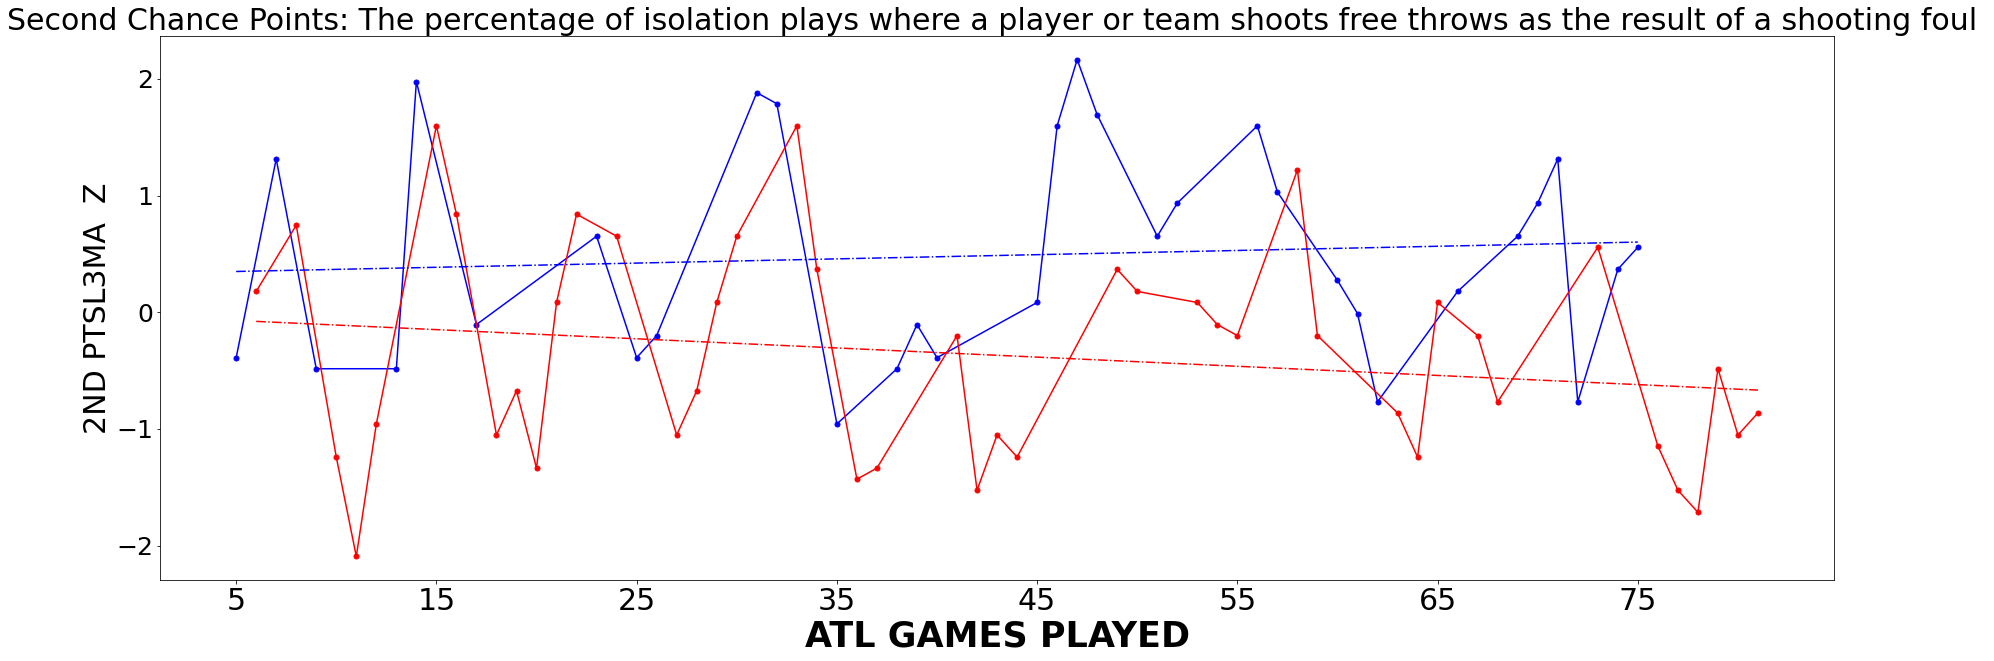

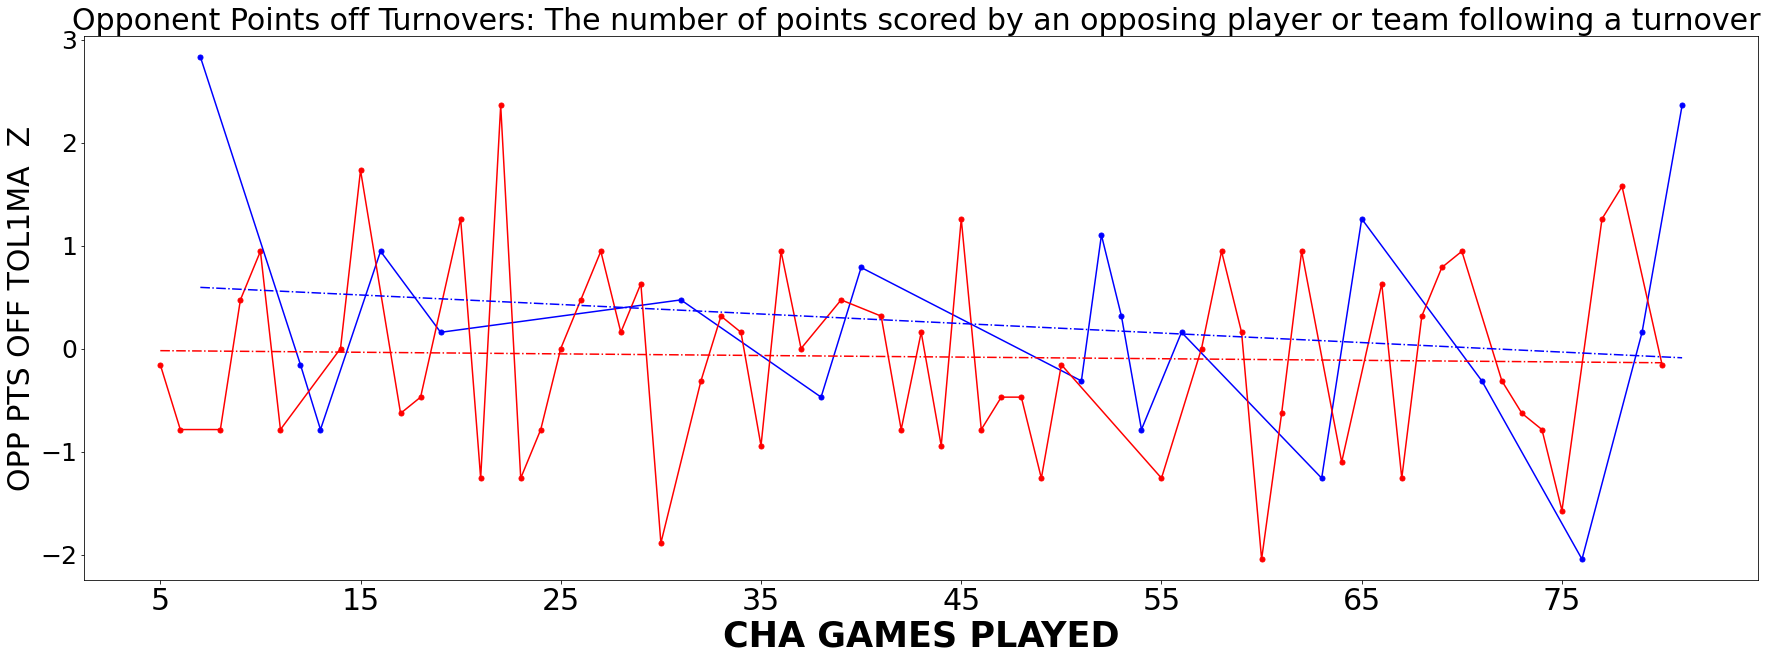

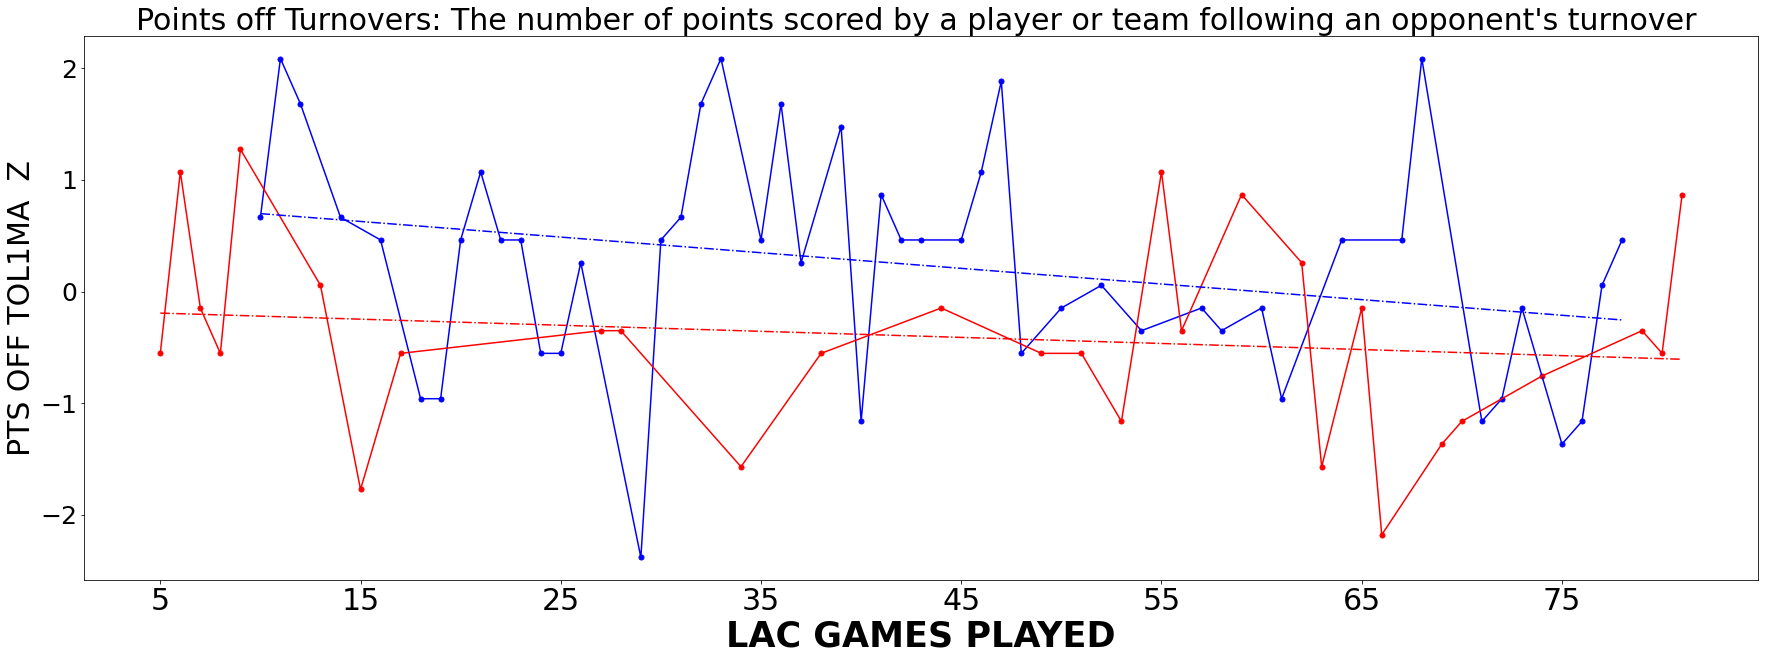

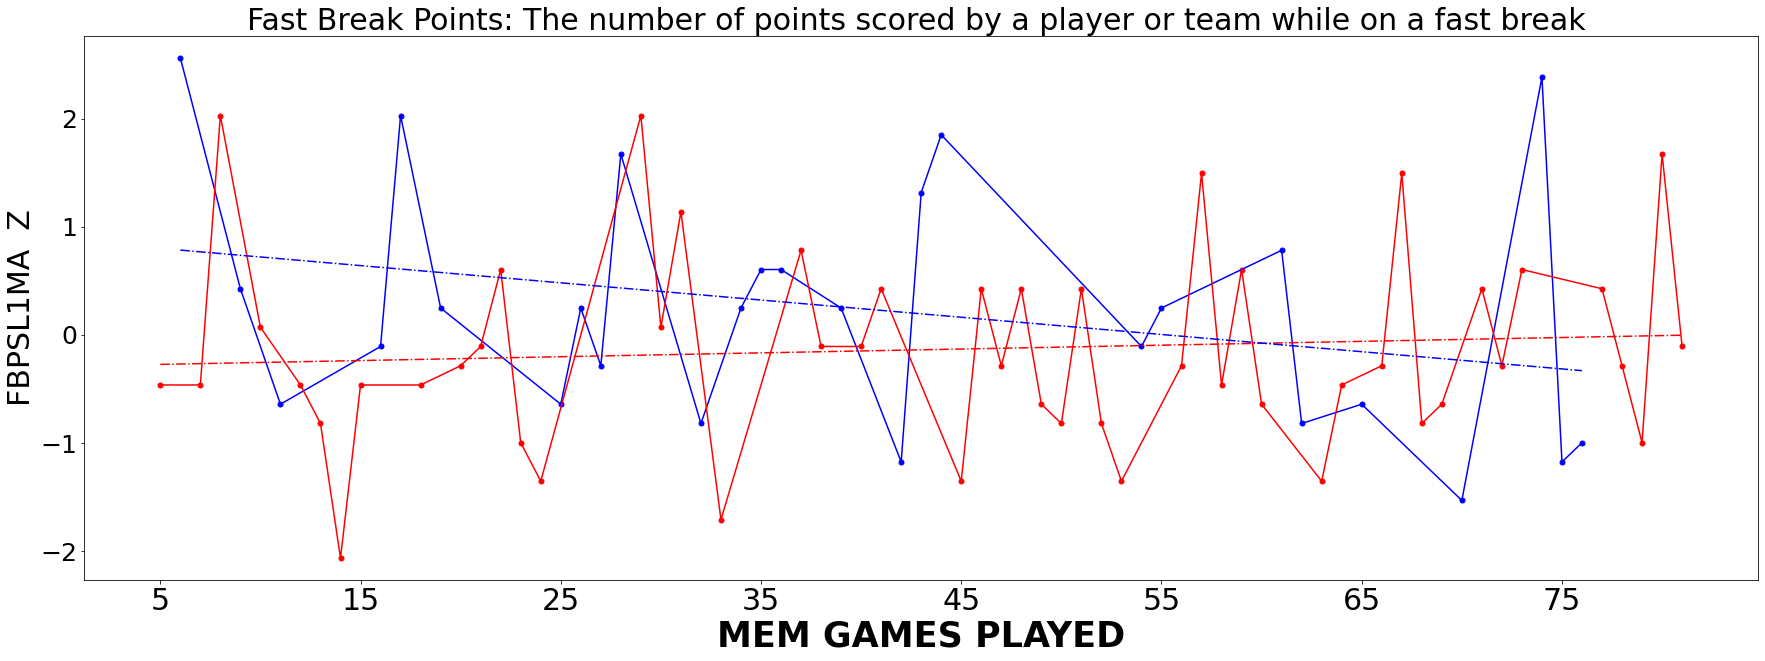

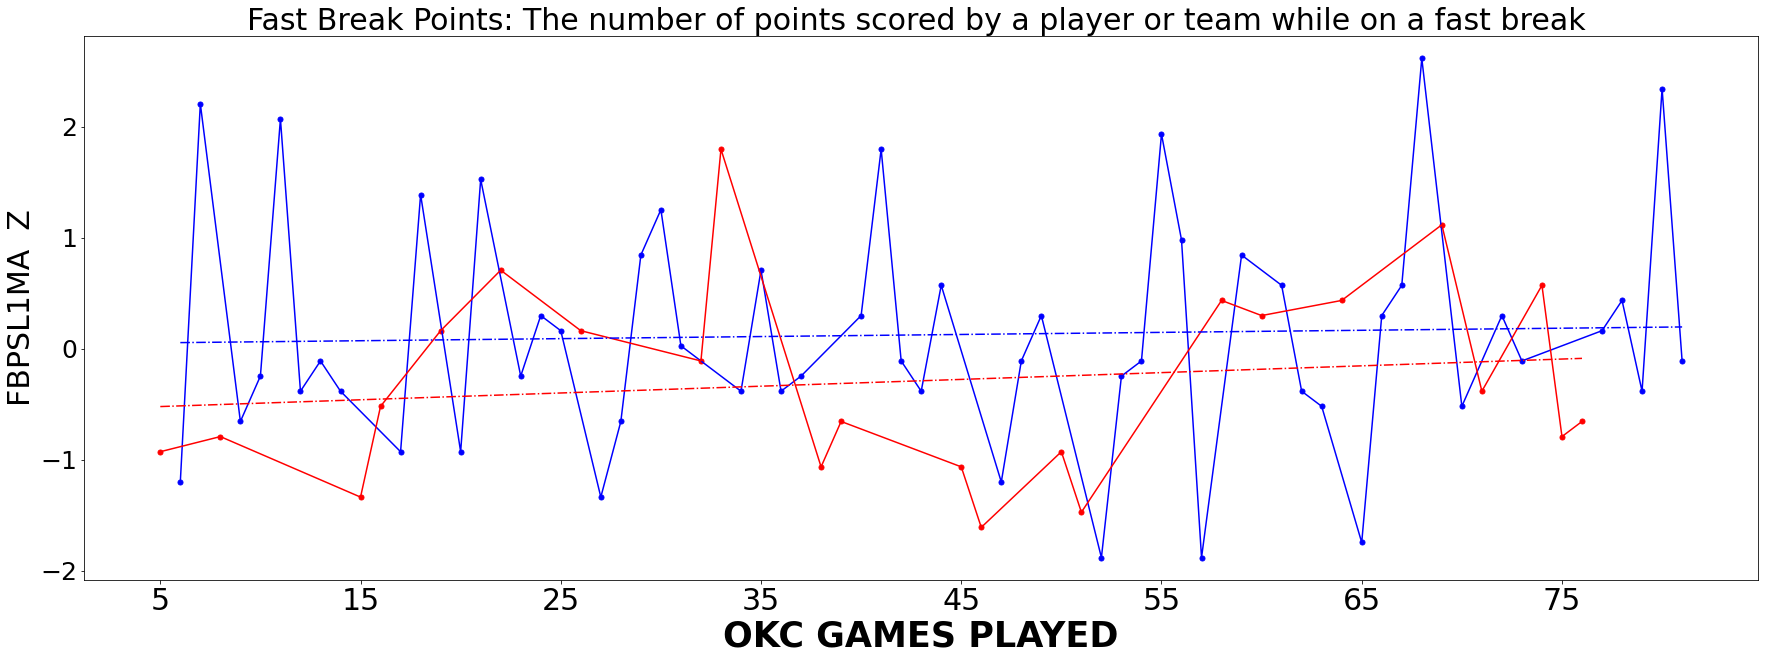

In [1579]:
from scipy import stats
for i in range(len(sameFeatureDF)):
    plt.figure(figsize=(30,10))
    
    team = sameFeatureDF.iloc[i]['TEAM']
    feature = sameFeatureDF.iloc[i]['FEATURE']
    teamDF = miscDF[miscDF['TEAM'] == team]
    teamDF = teamDF[teamDF['DATE'] < datetime.date(2024,4,15)]
    teamDF = teamDF.reset_index(drop=True)
    teamDF = teamDF.dropna()
    
    teamDF['X_test'] = stats.zscore(teamDF[feature])
    
    plt.scatter(teamDF[teamDF['RESULT'] == 0].index,
                teamDF[teamDF['RESULT'] == 0]['X_test'].values,color='red',marker='.',s=100)

    plt.scatter(teamDF[teamDF['RESULT'] == 1].index,
                teamDF[teamDF['RESULT'] == 1]['X_test'].values,color='blue',marker='.',s=100)
    
    plt.plot(teamDF[teamDF['RESULT'] == 1].index, teamDF[teamDF['RESULT'] == 1]['X_test'].values,color='b')
    plt.plot(teamDF[teamDF['RESULT'] == 0].index, teamDF[teamDF['RESULT'] == 0]['X_test'].values,color='r')
    
    res = stats.linregress(teamDF[teamDF['RESULT'] == 0].index,teamDF[teamDF['RESULT'] == 0]['X_test'])
    plt.plot(teamDF[teamDF['RESULT'] == 0].index, res.intercept + res.slope*teamDF[teamDF['RESULT'] == 0].index, 'r-.')
    
    res = stats.linregress(teamDF[teamDF['RESULT'] == 1].index,teamDF[teamDF['RESULT'] == 1]['X_test'])
    plt.plot(teamDF[teamDF['RESULT'] == 1].index, res.intercept + res.slope*teamDF[teamDF['RESULT'] == 1].index, 'b-.')
    
    defintion = getFeatureDefintion(feature)
    plt.title(defintion,fontsize=30)
    plt.xlabel(team+' GAMES PLAYED',fontsize=35,fontweight='bold')
    plt.ylabel(feature+'  Z',fontsize=30)
    
    plt.ylim(top=np.max(teamDF['X_test'])+.2)     # adjust the top leaving bottom unchanged
    plt.ylim(bottom=np.min(teamDF['X_test'])-.2)  # adjust the bottom leaving top unchanged
   
    plt.yticks(fontsize=25)
    
    ticks = []
    for i in range (0,len(list(teamDF.index)),10): ticks.append(list(teamDF.index)[i])
        
    plt.xticks(ticks)
    plt.xticks(fontsize=30)
    plt.show()
#https://stackoverflow.com/questions/2176424/hiding-axis-text-in-matplotlib-plots

In [69]:
#teamDF['DATE']

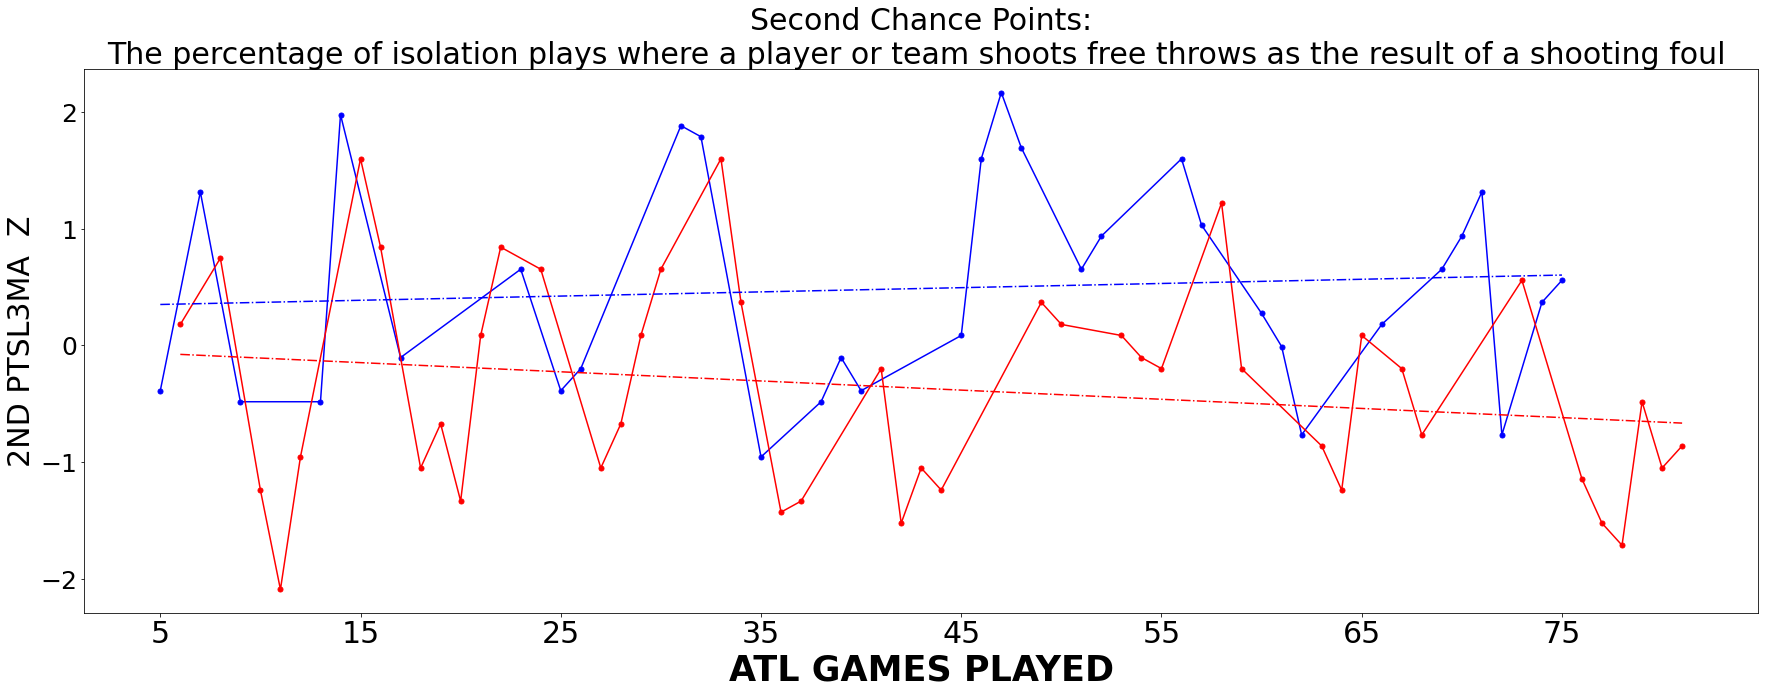

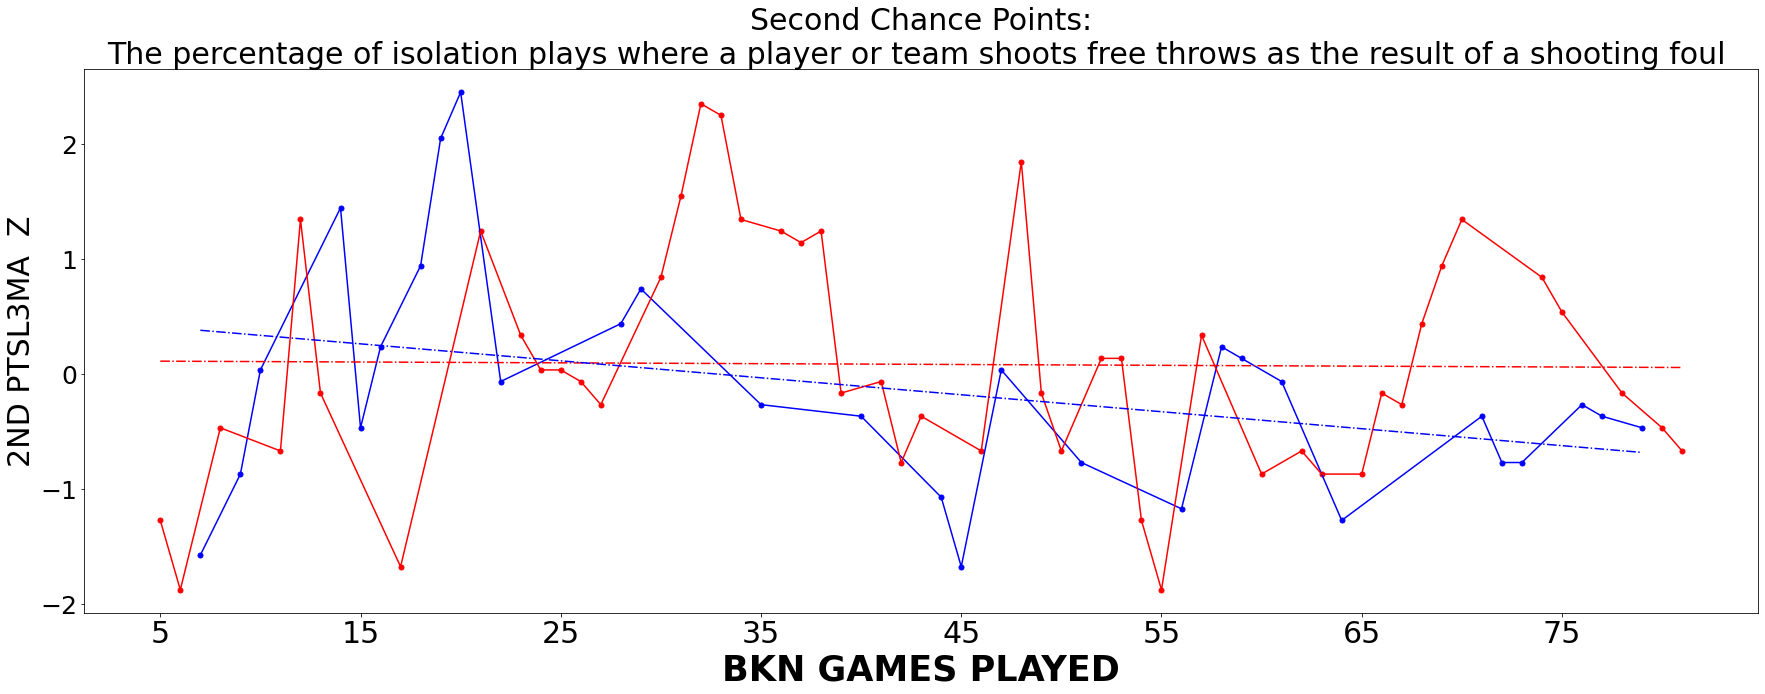

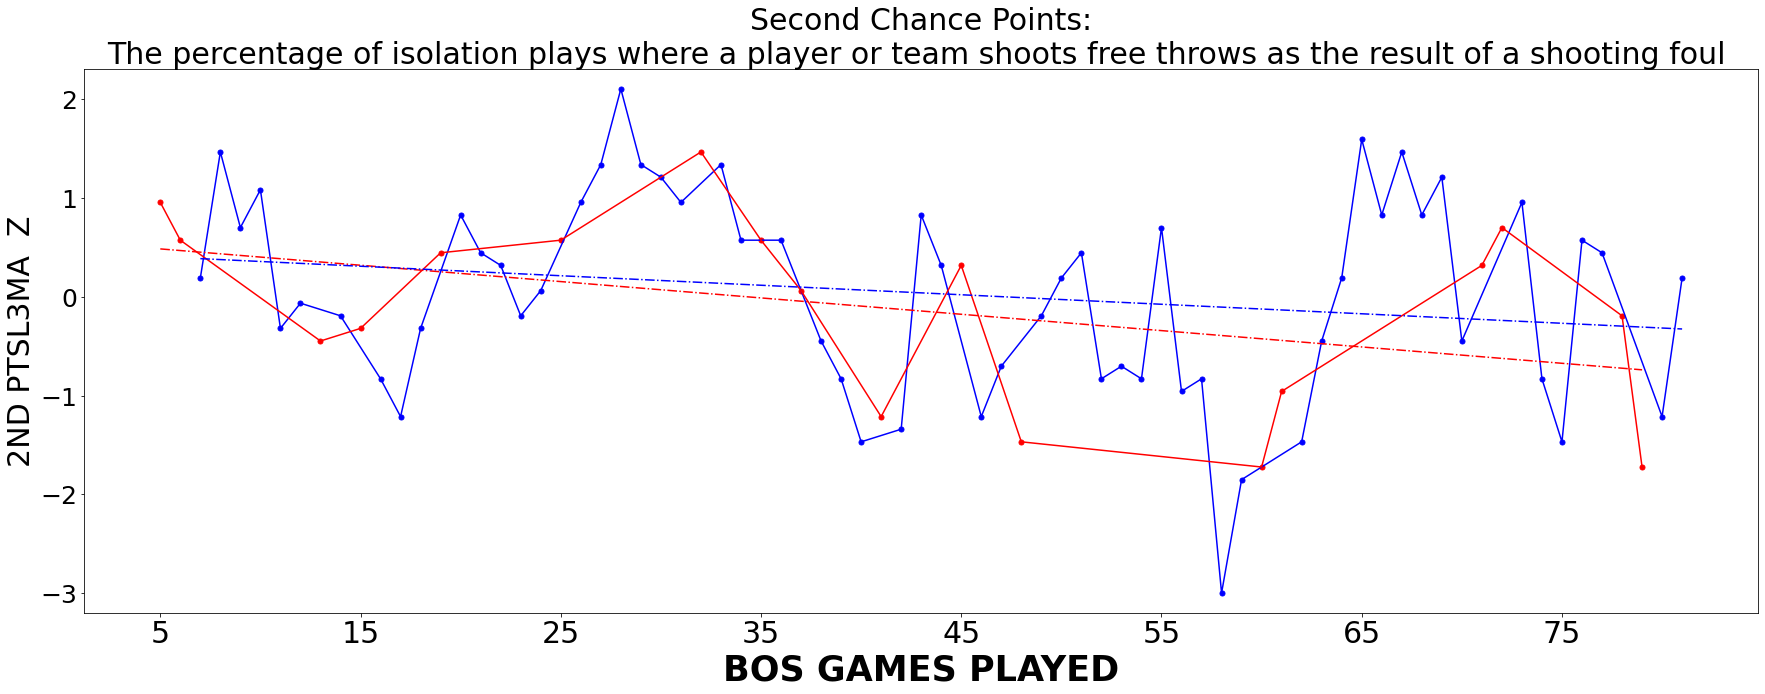

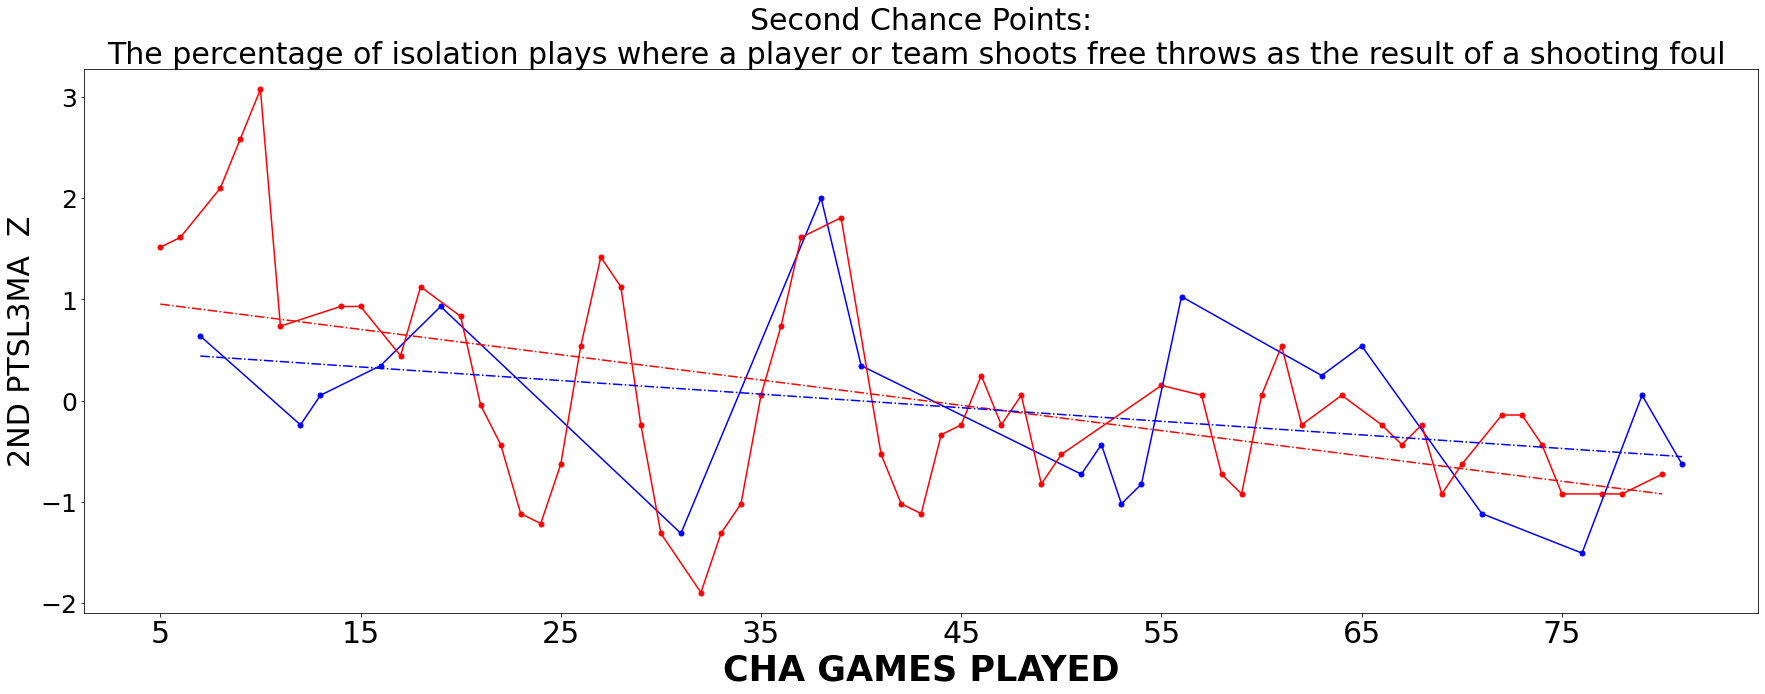

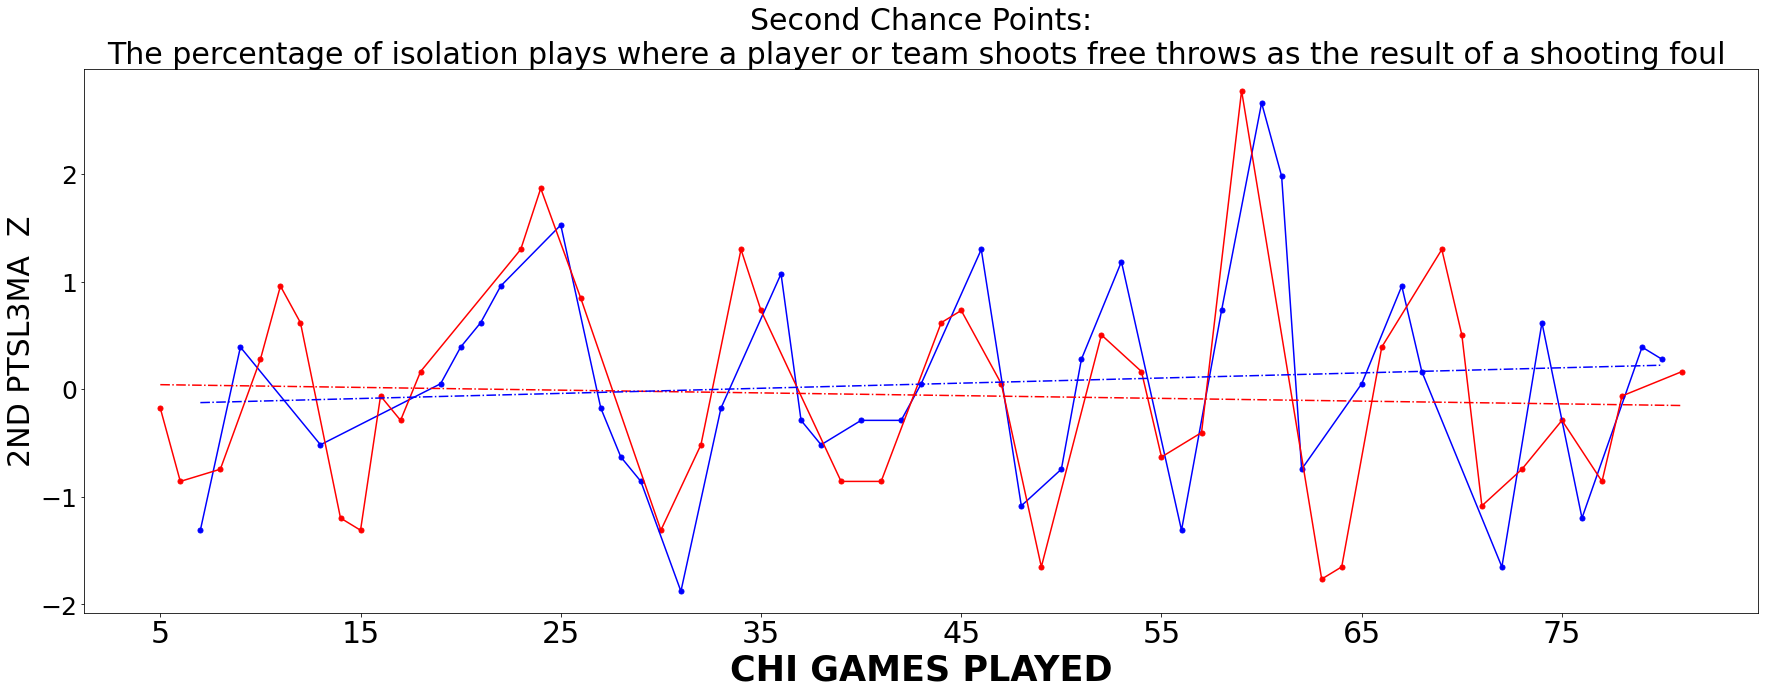

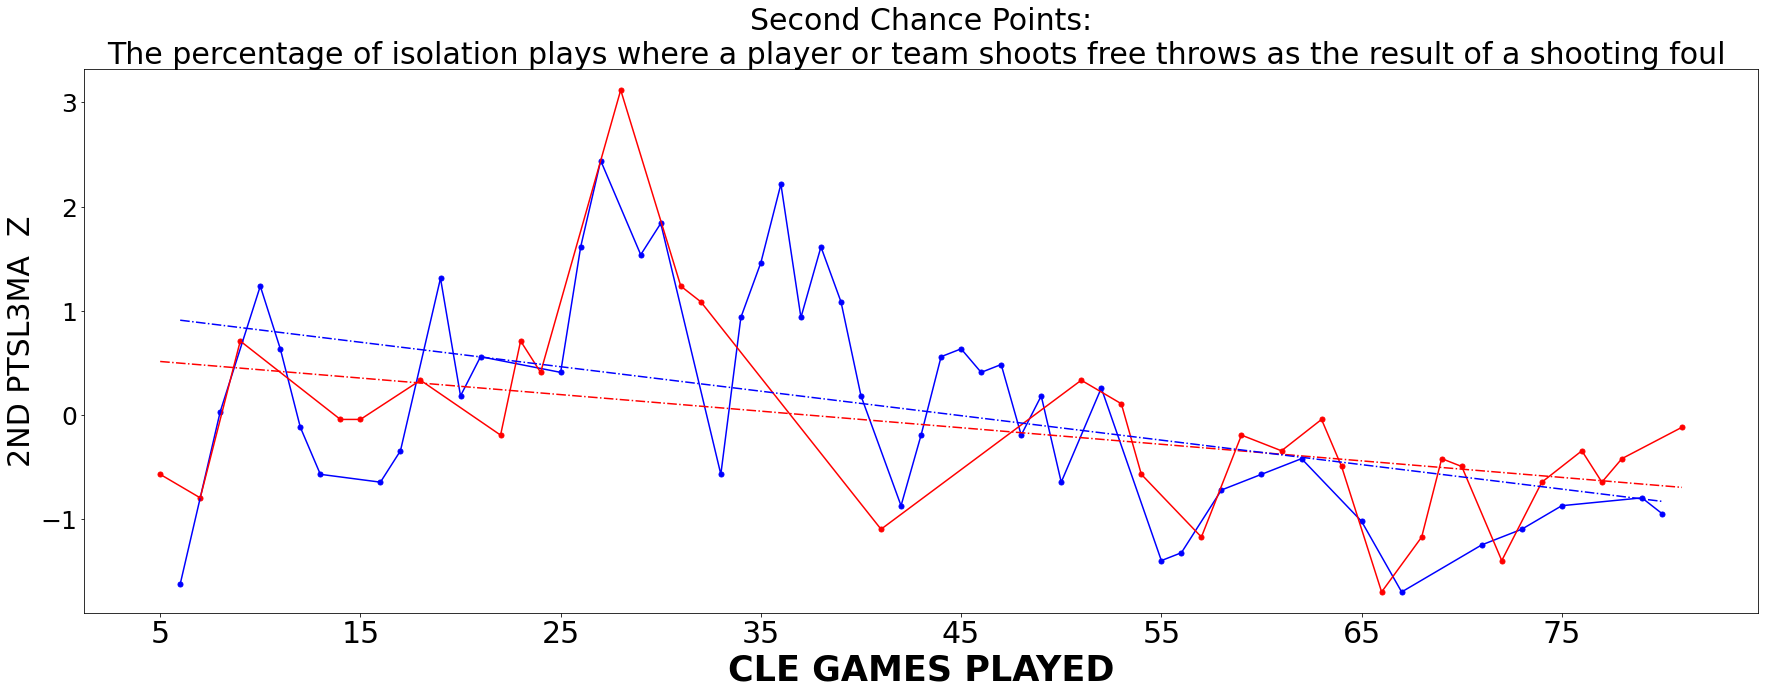

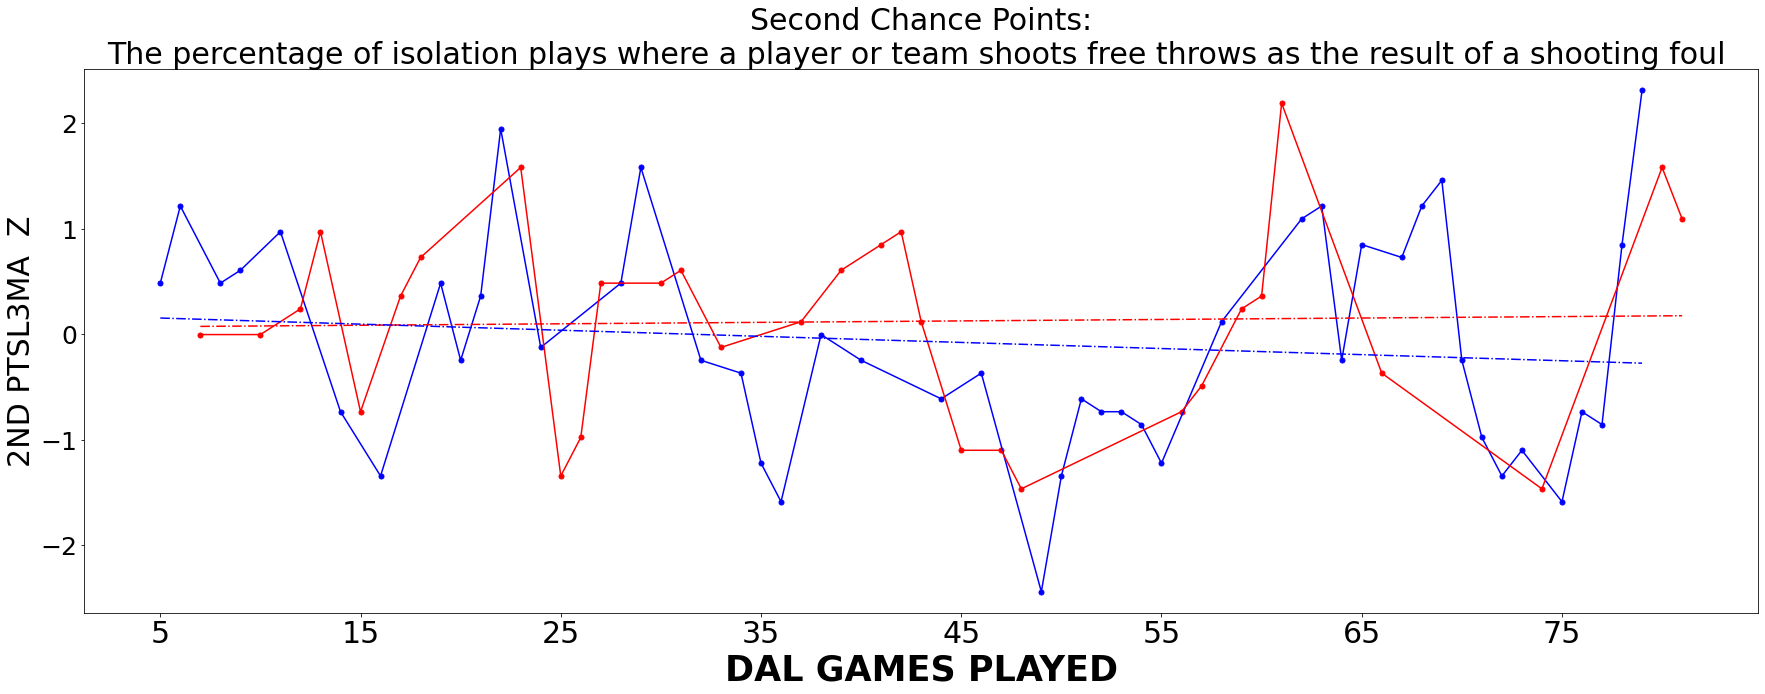

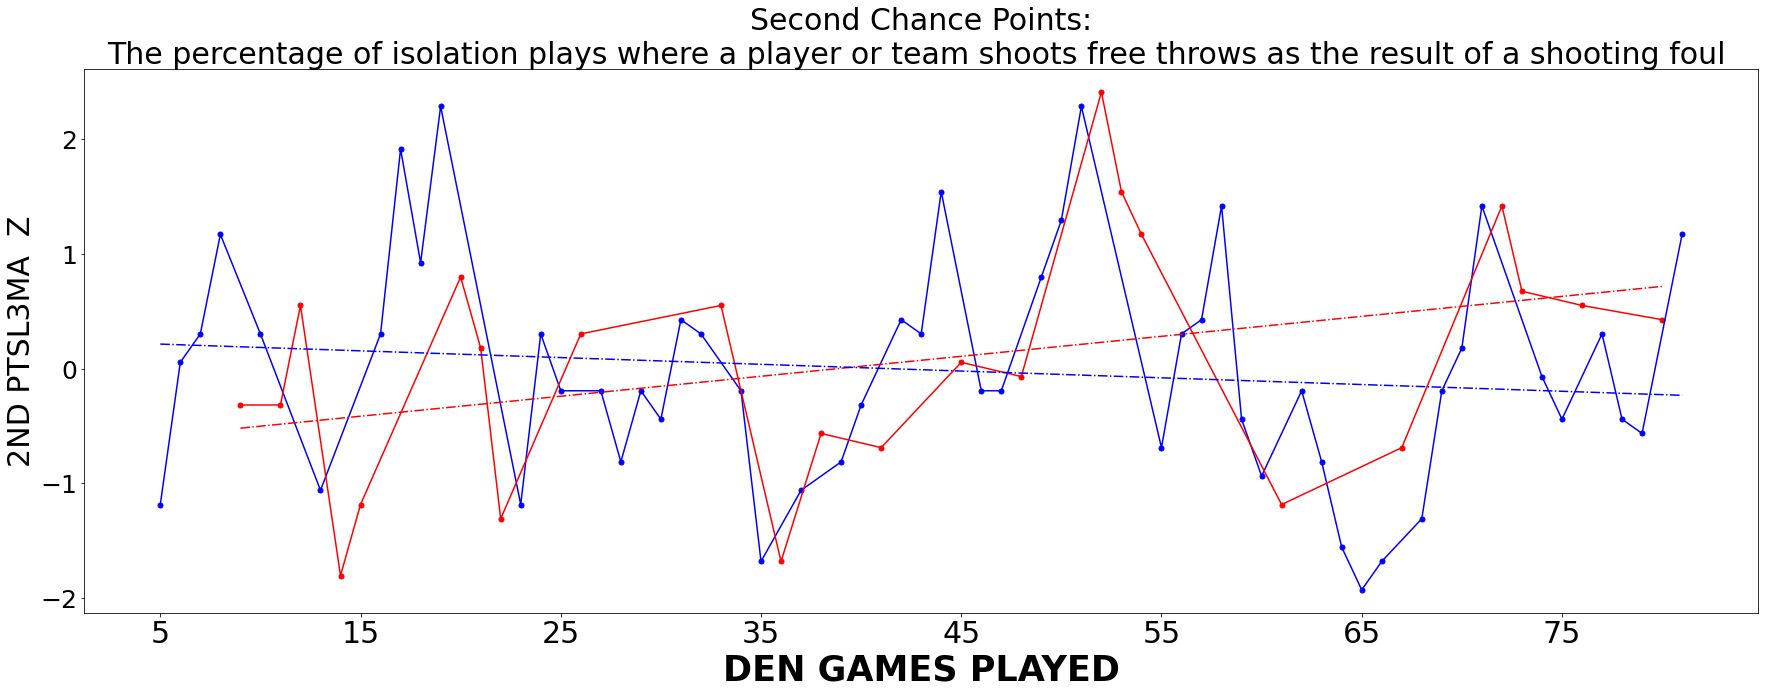

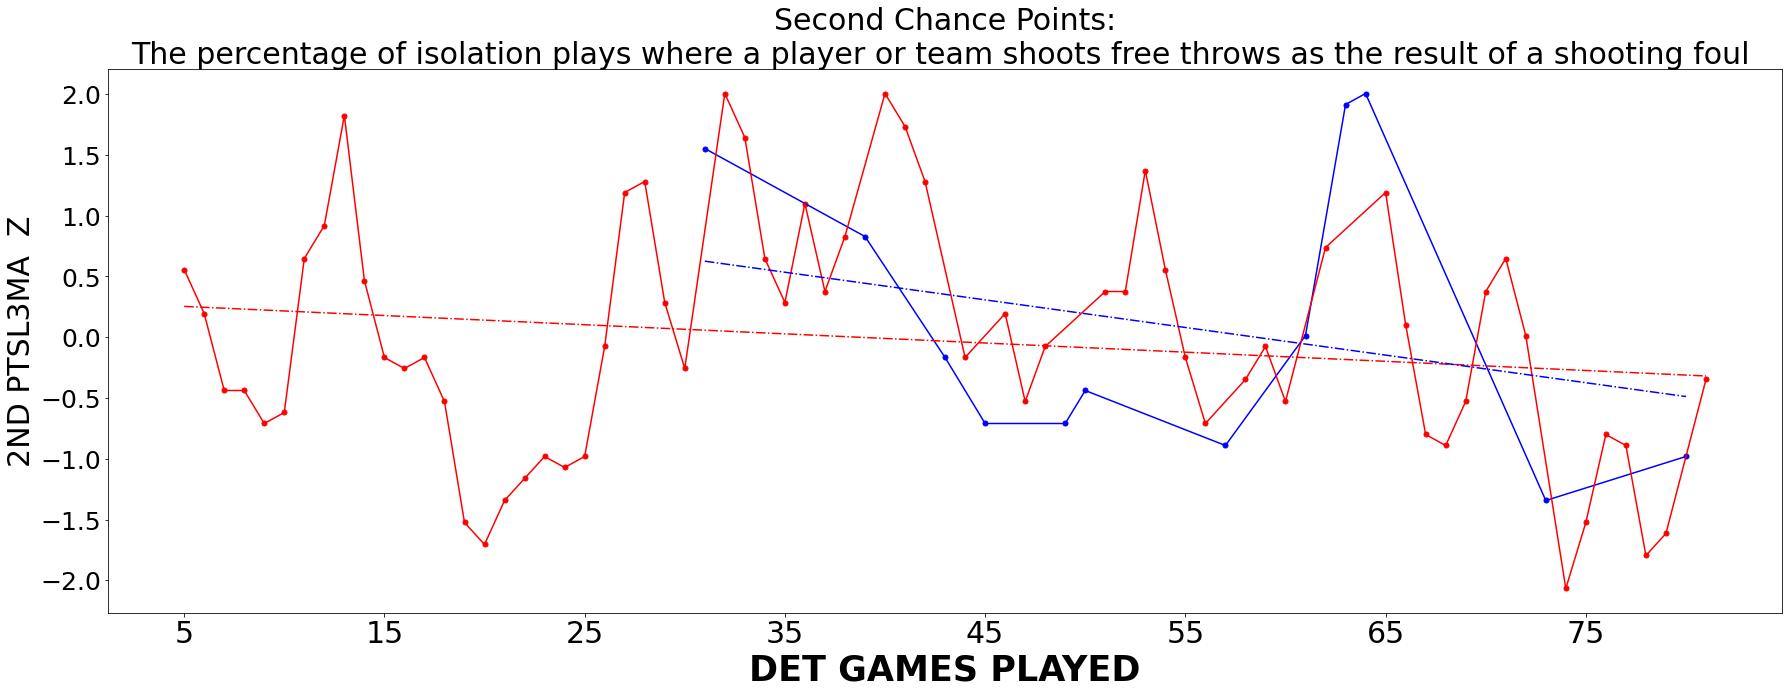

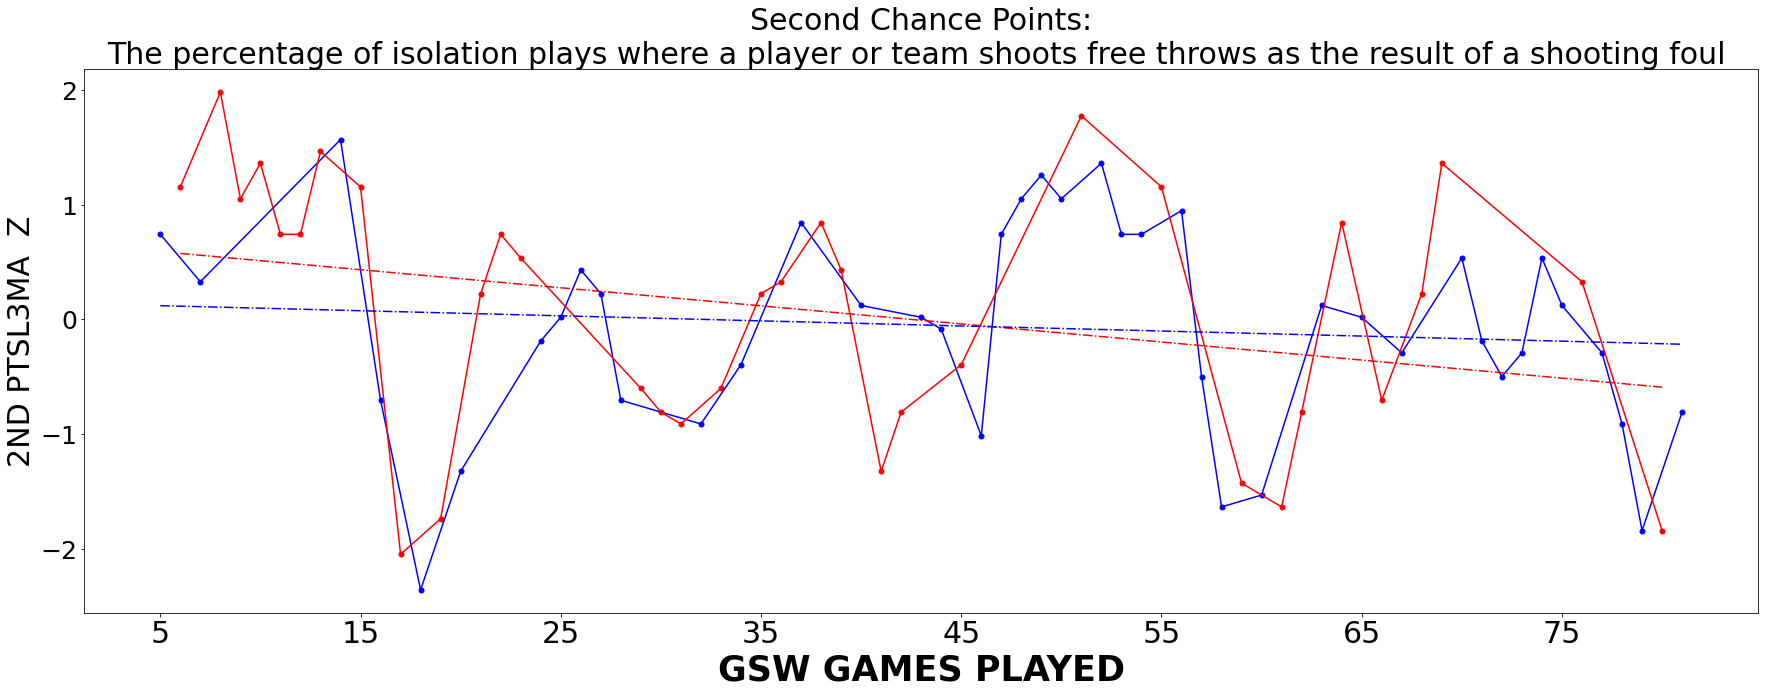

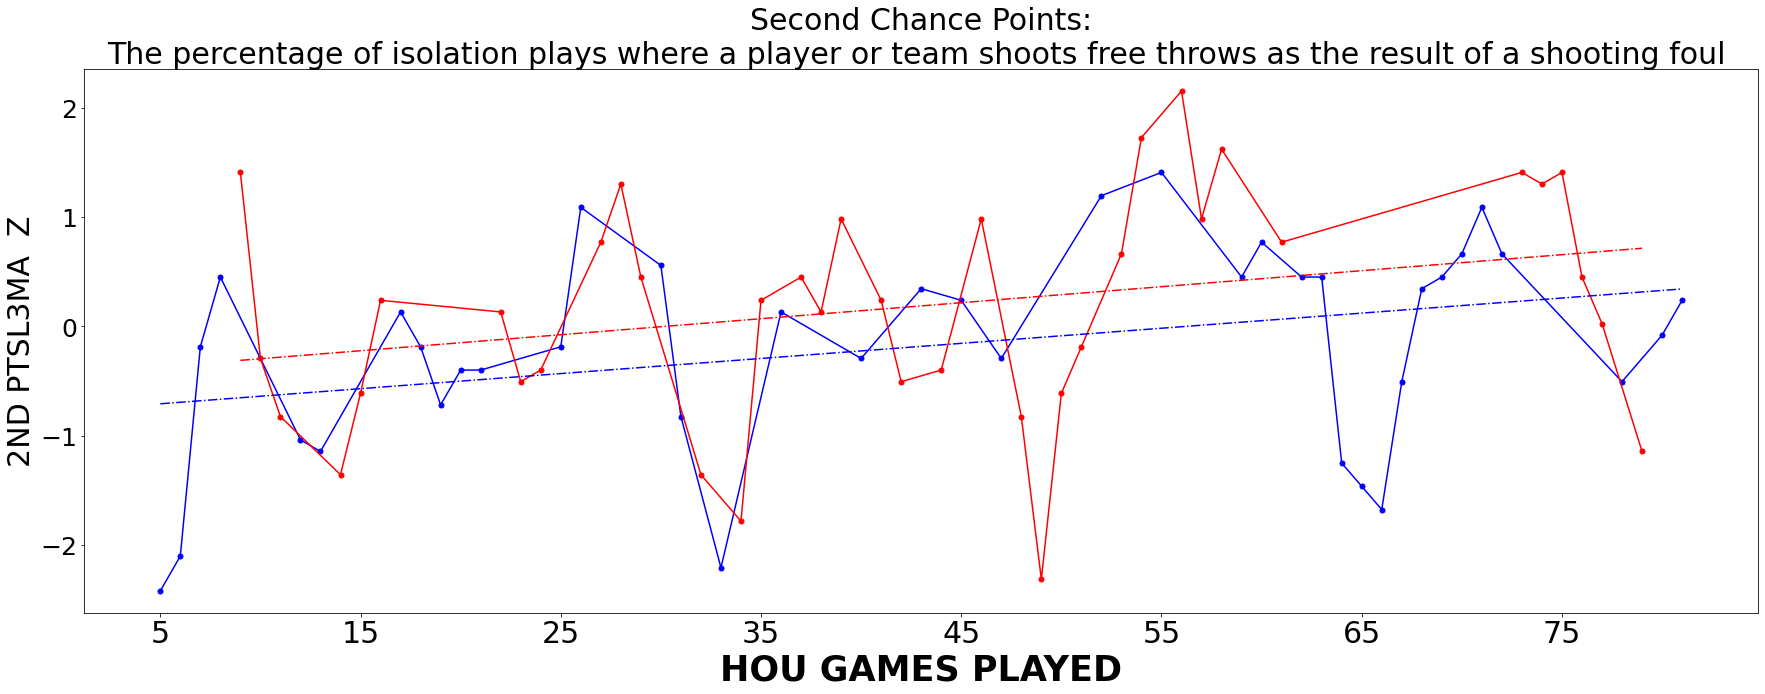

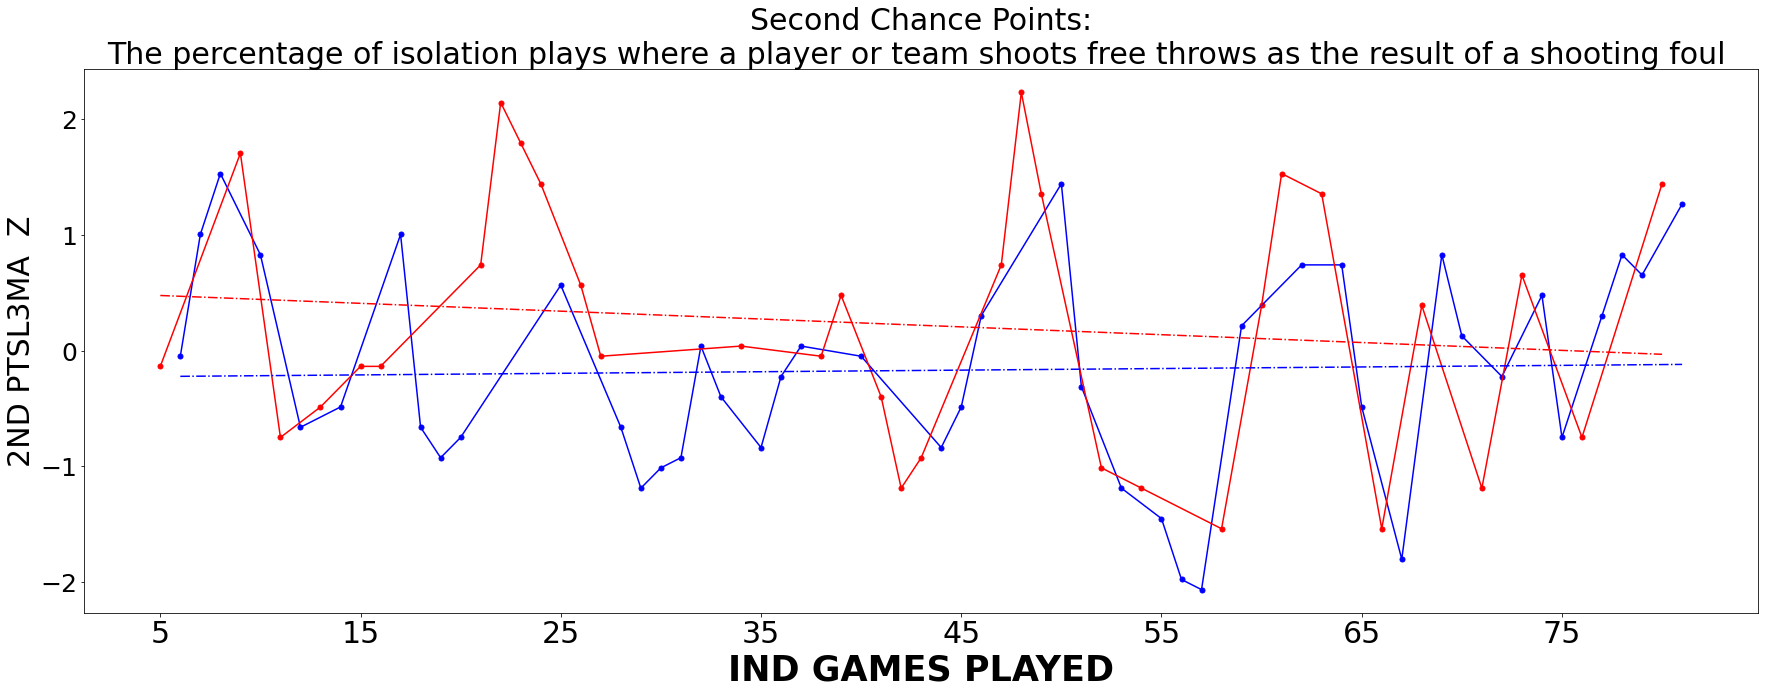

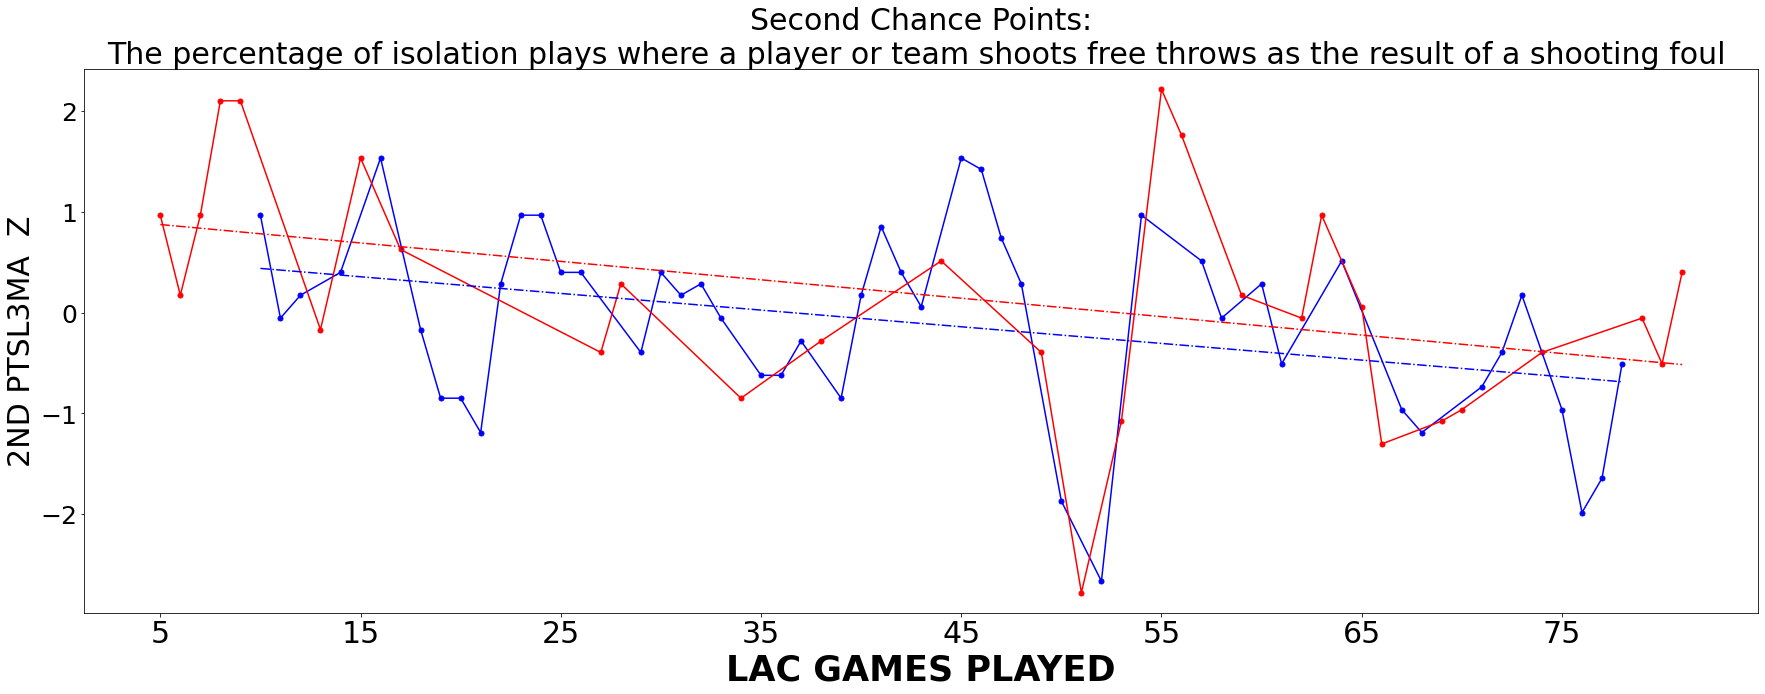

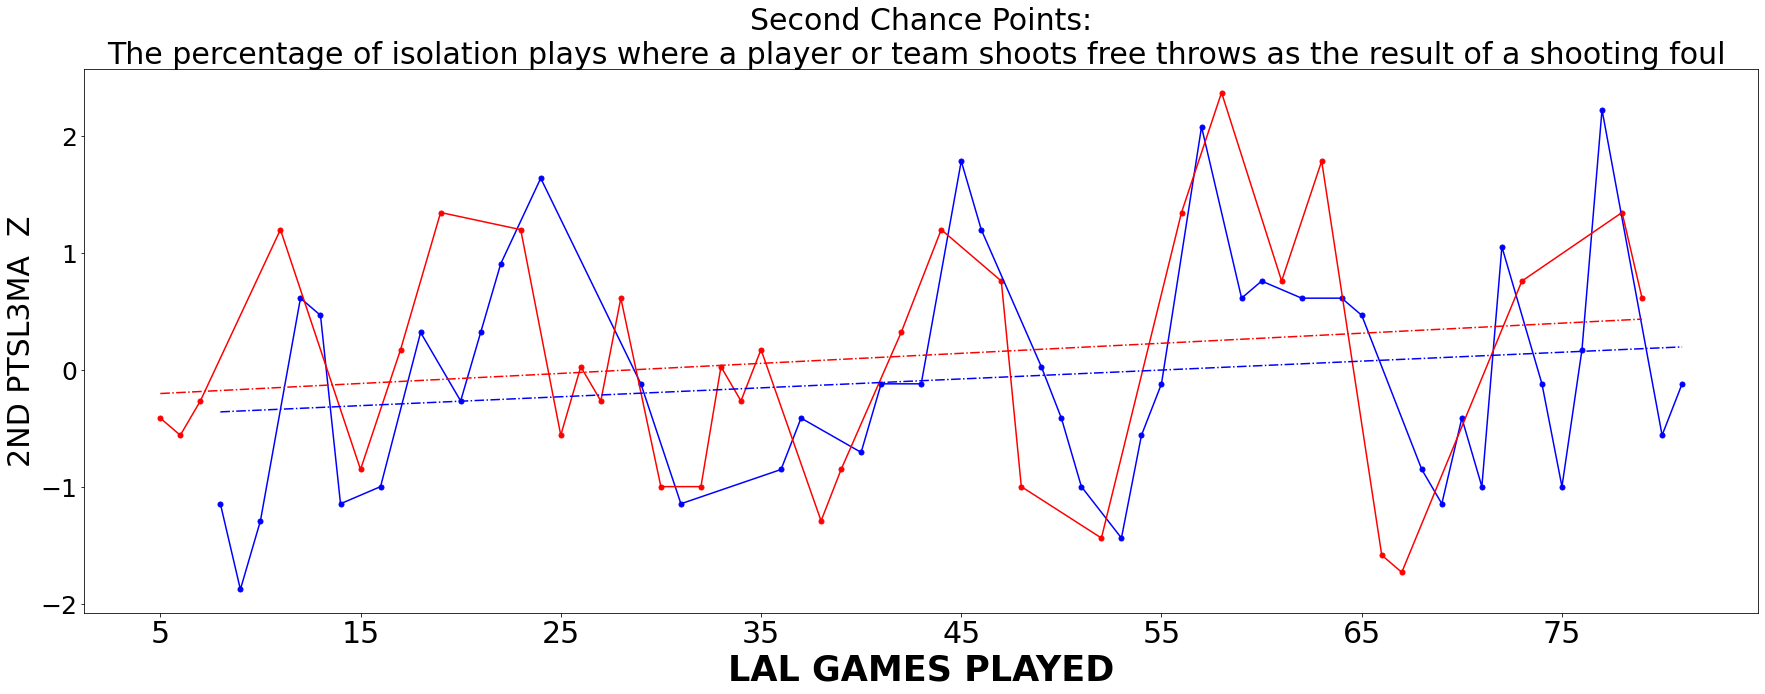

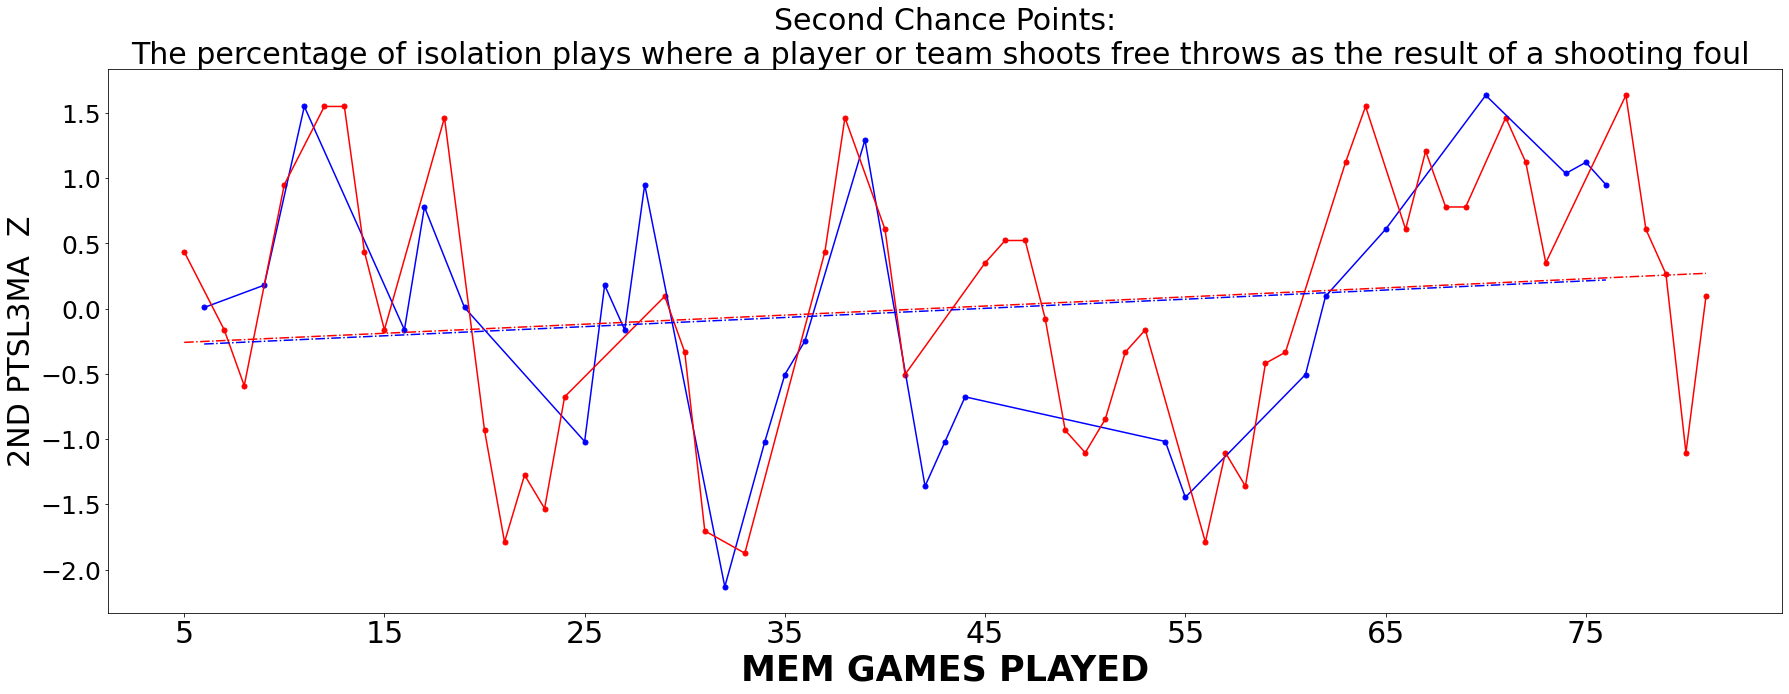

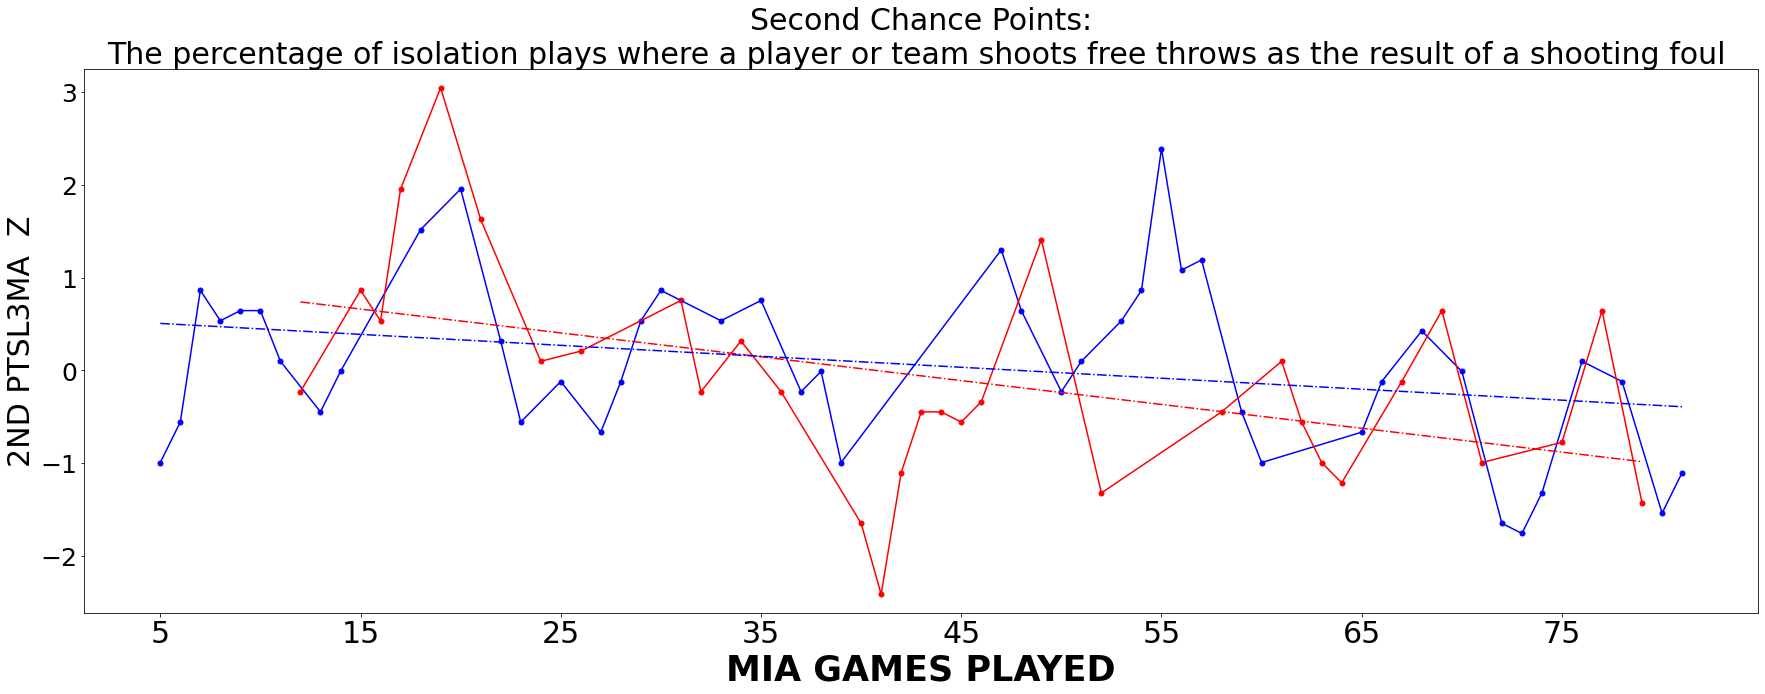

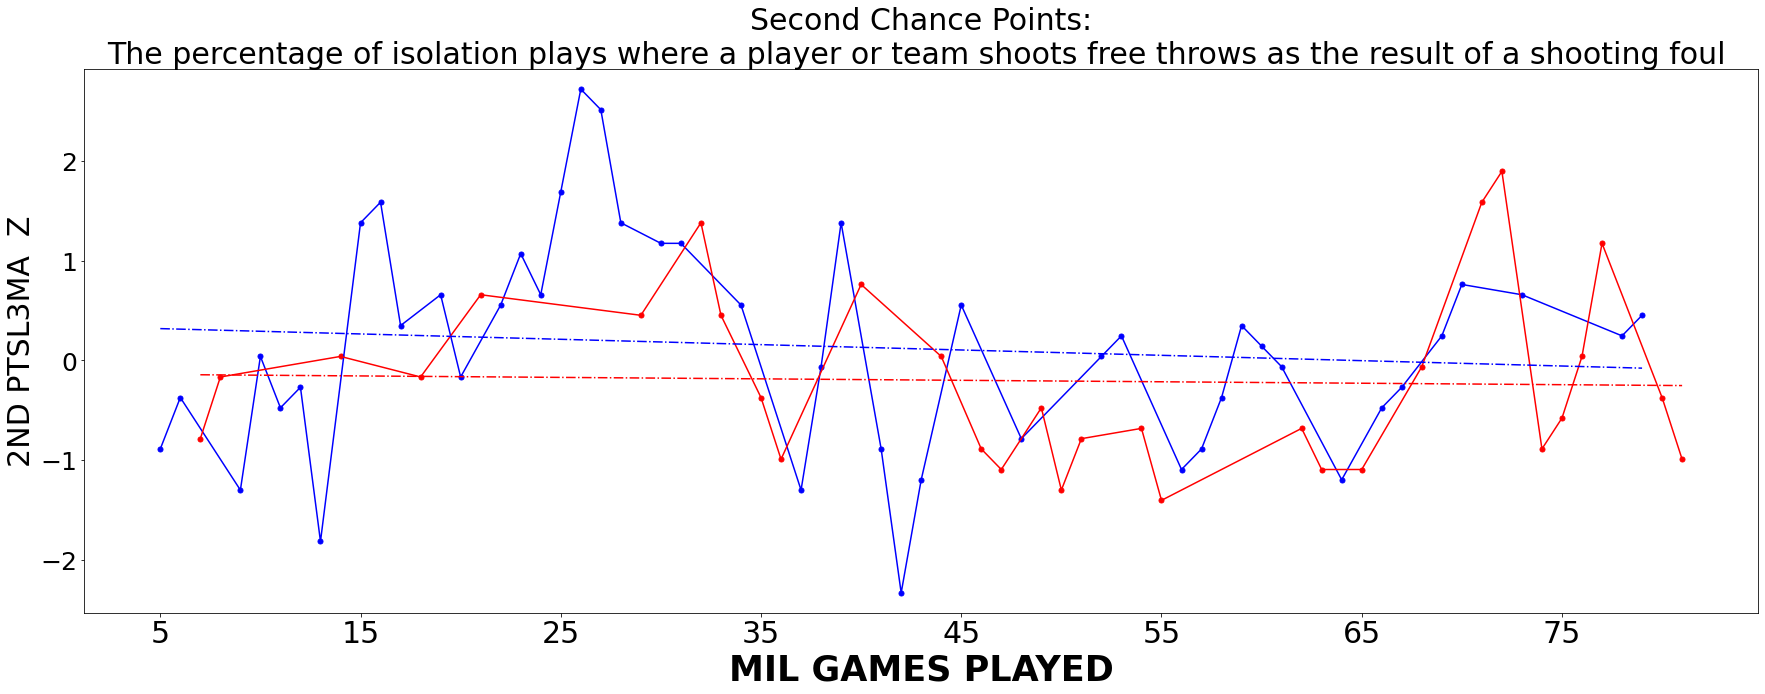

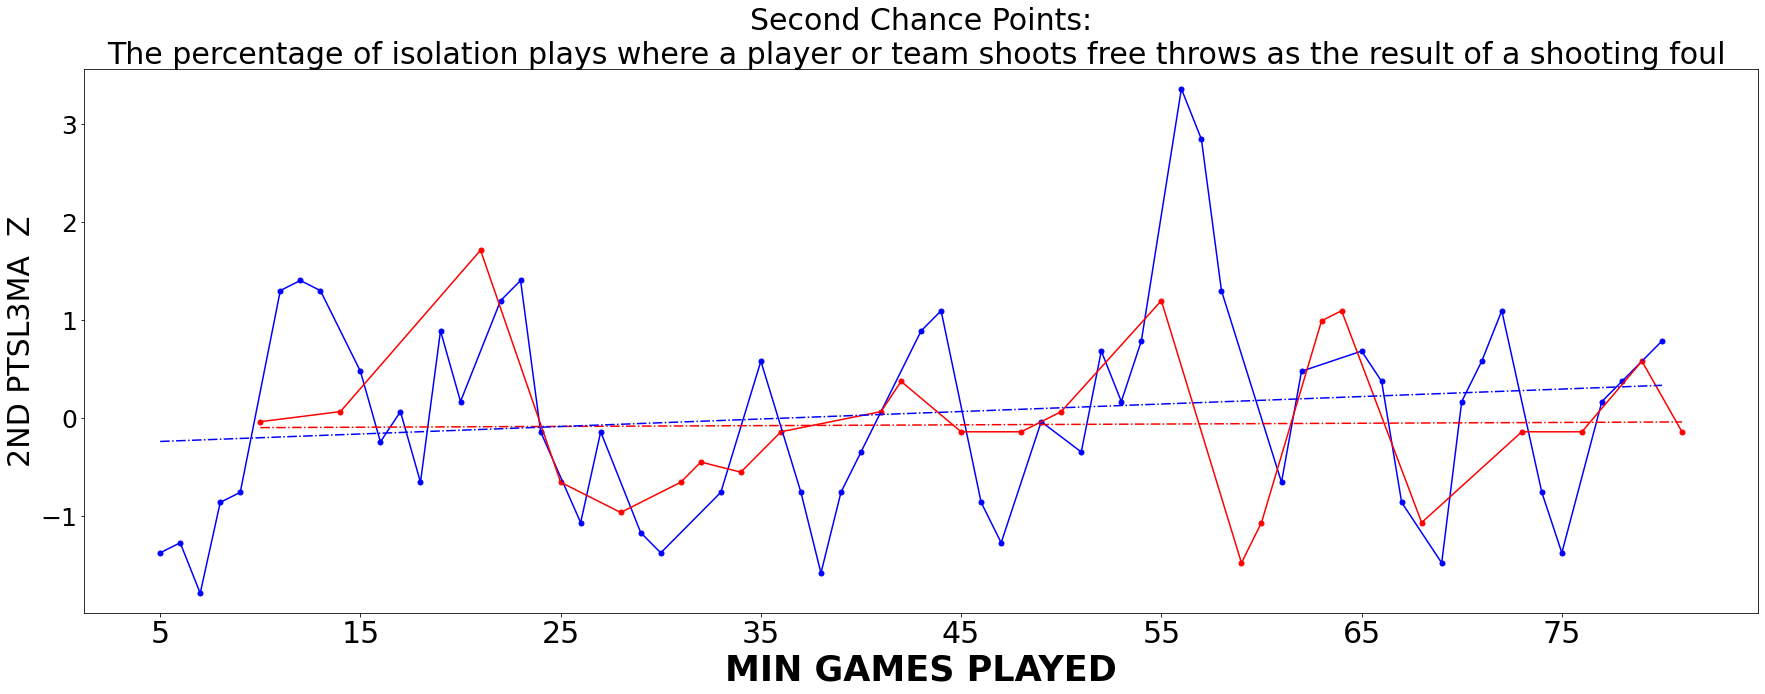

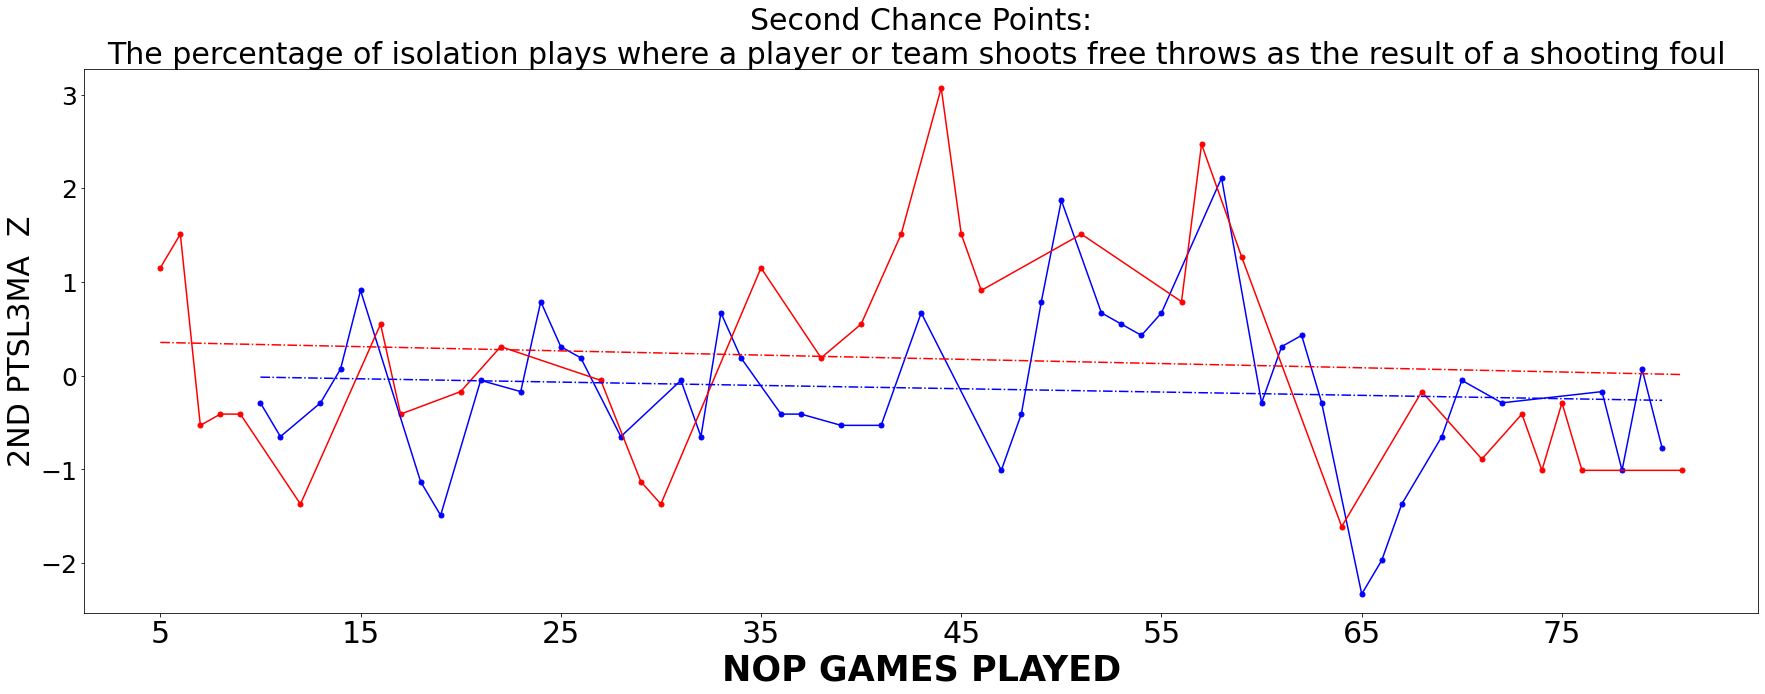

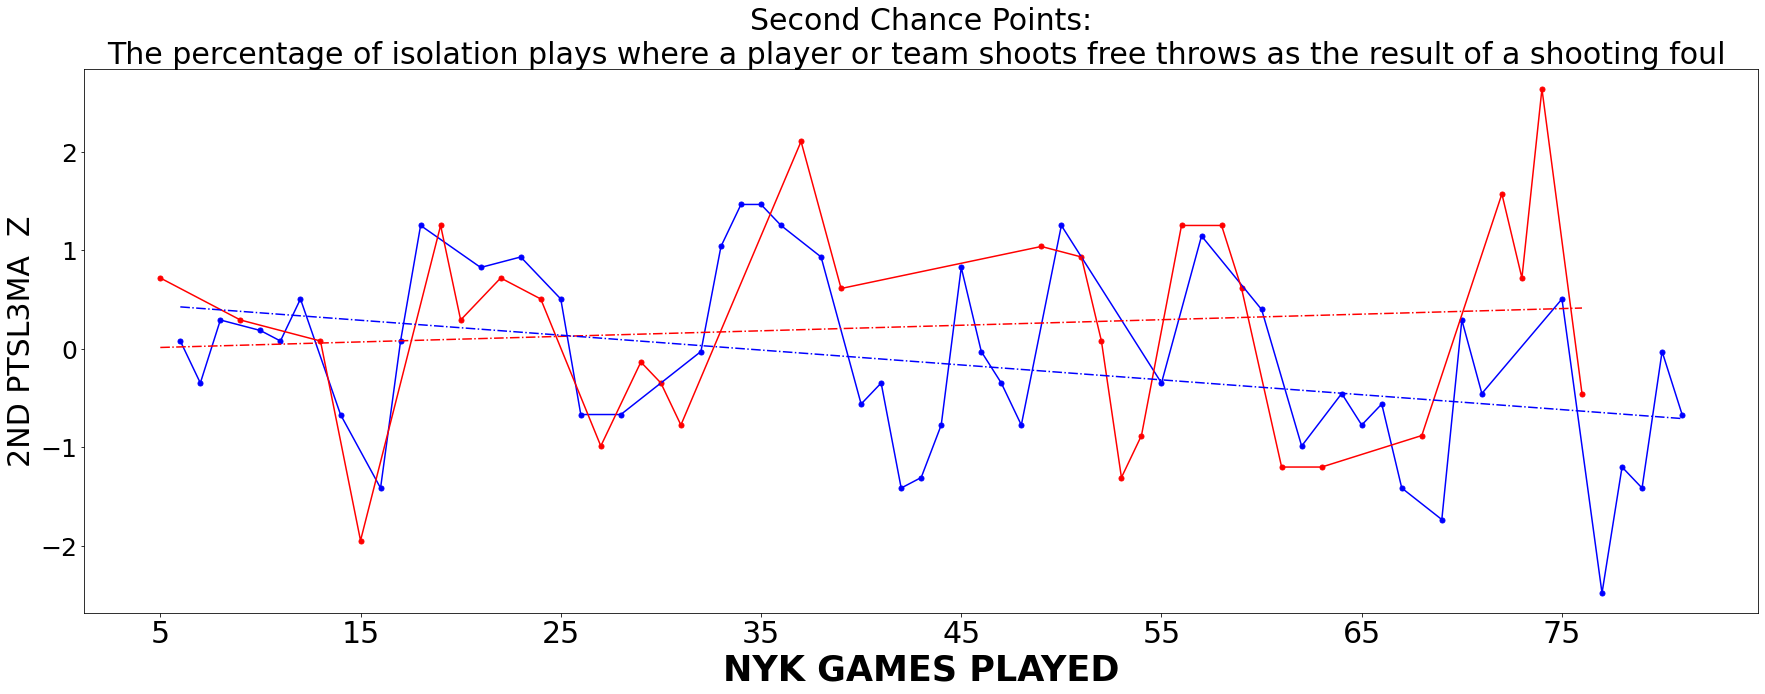

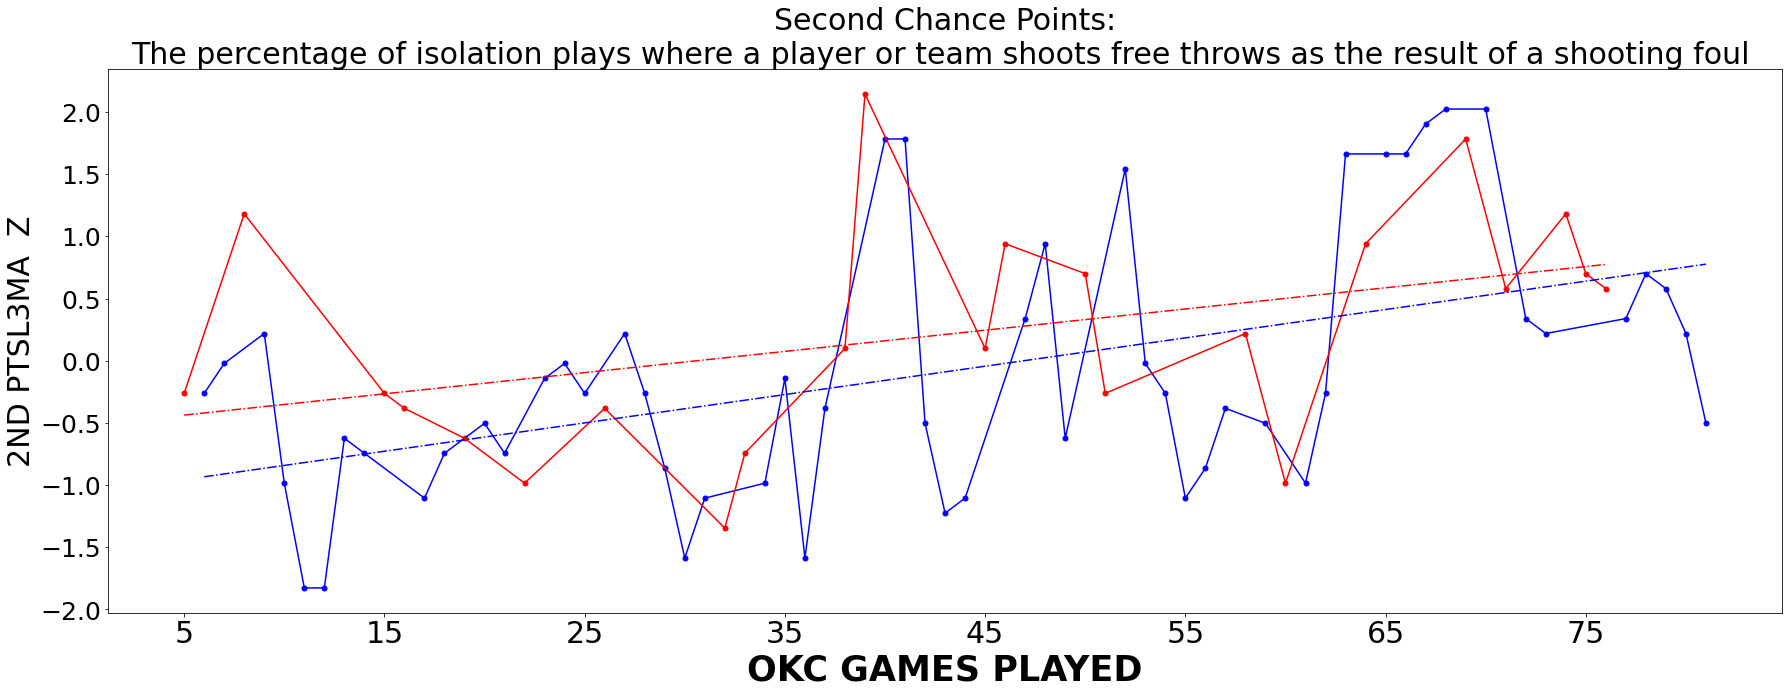

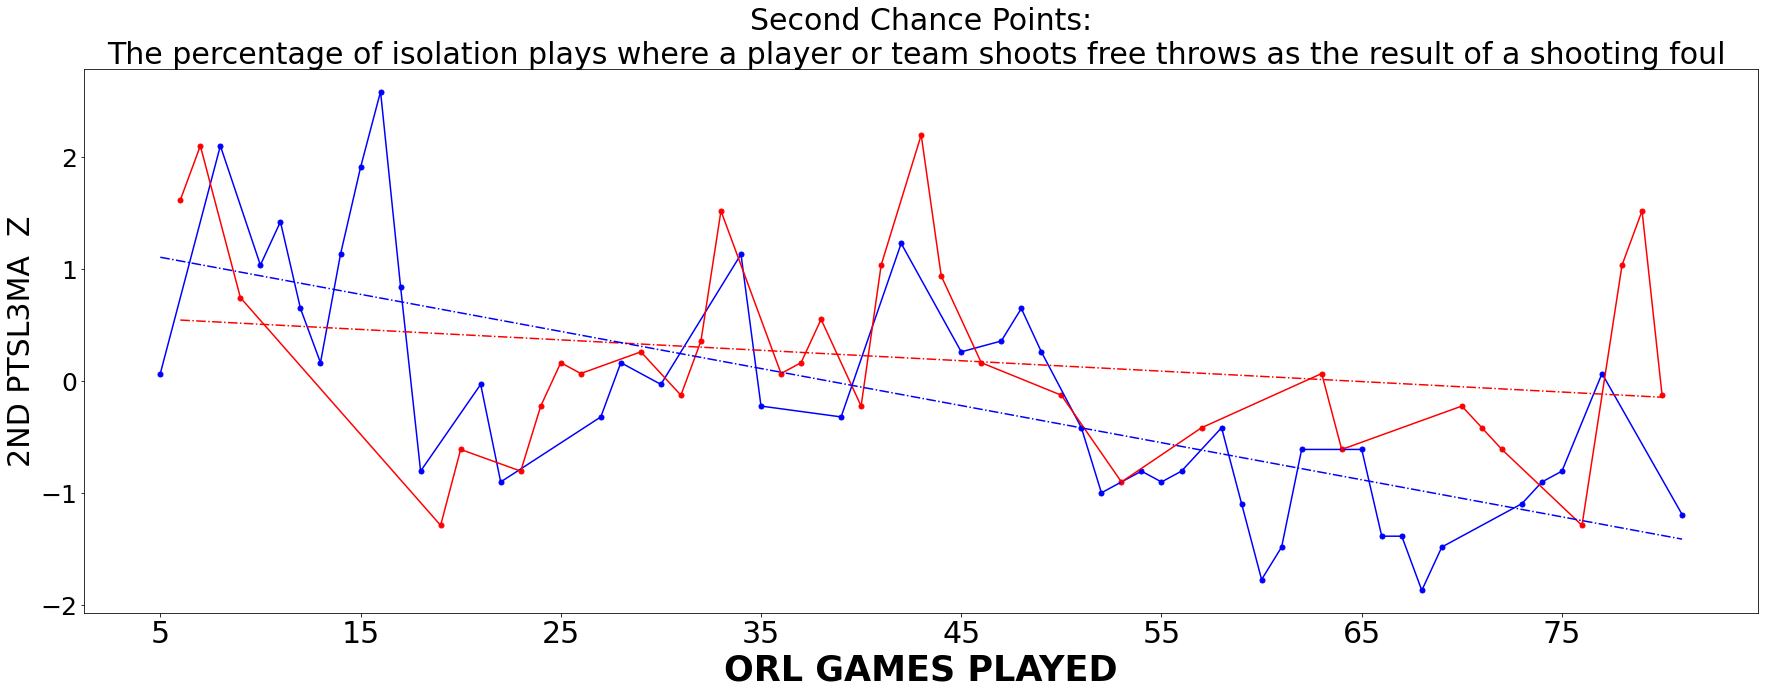

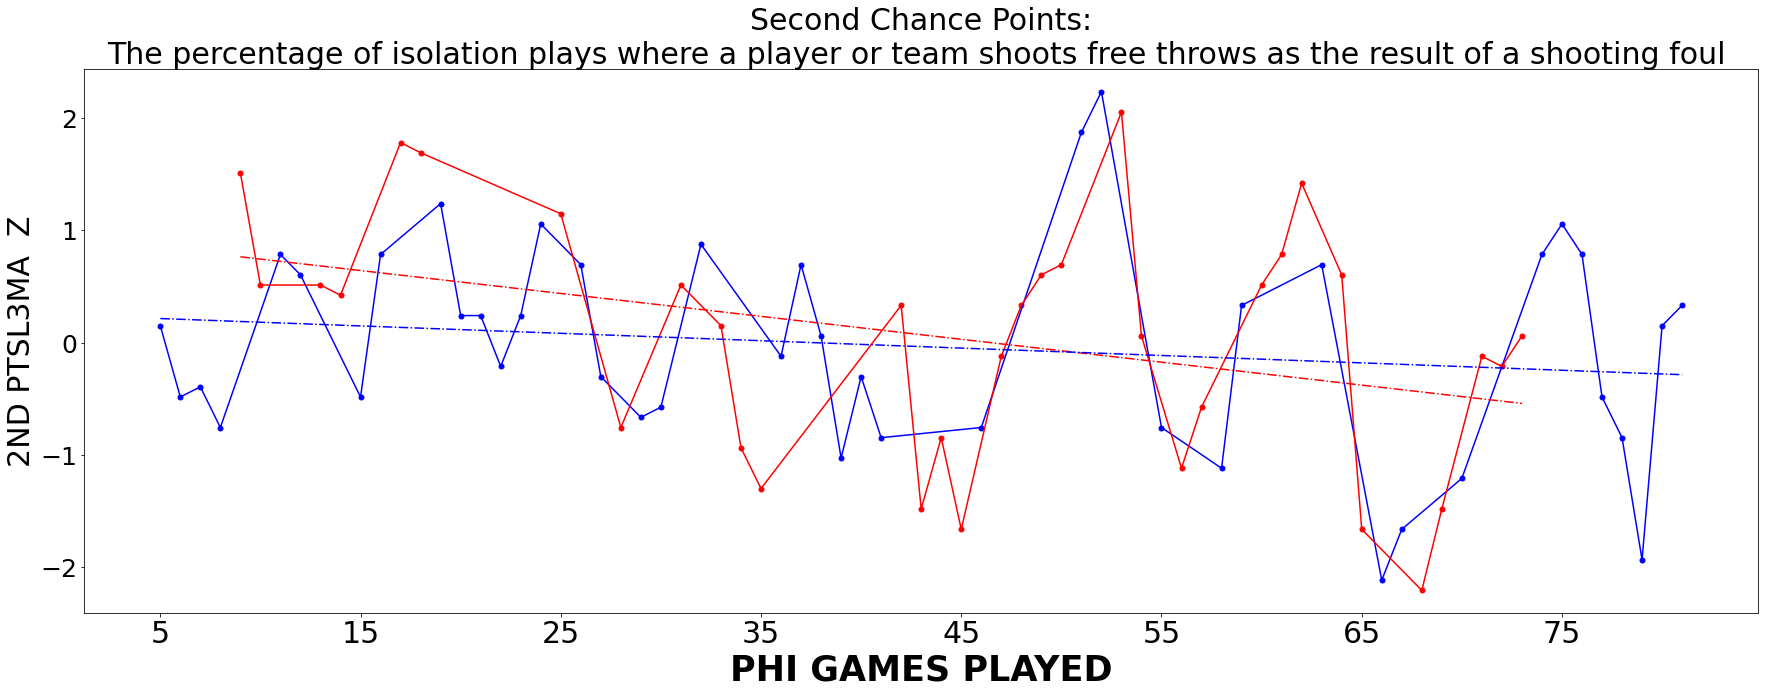

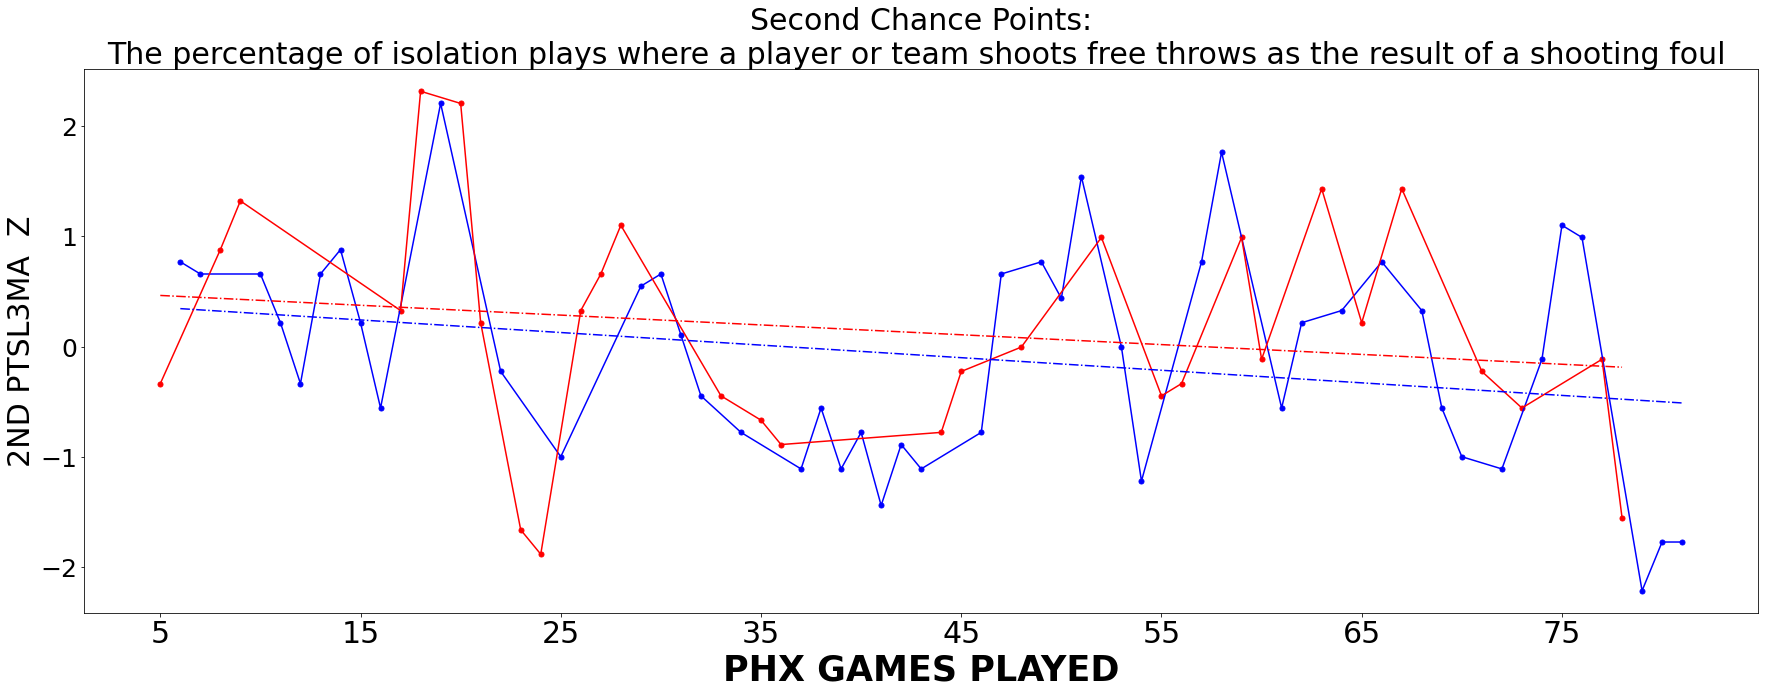

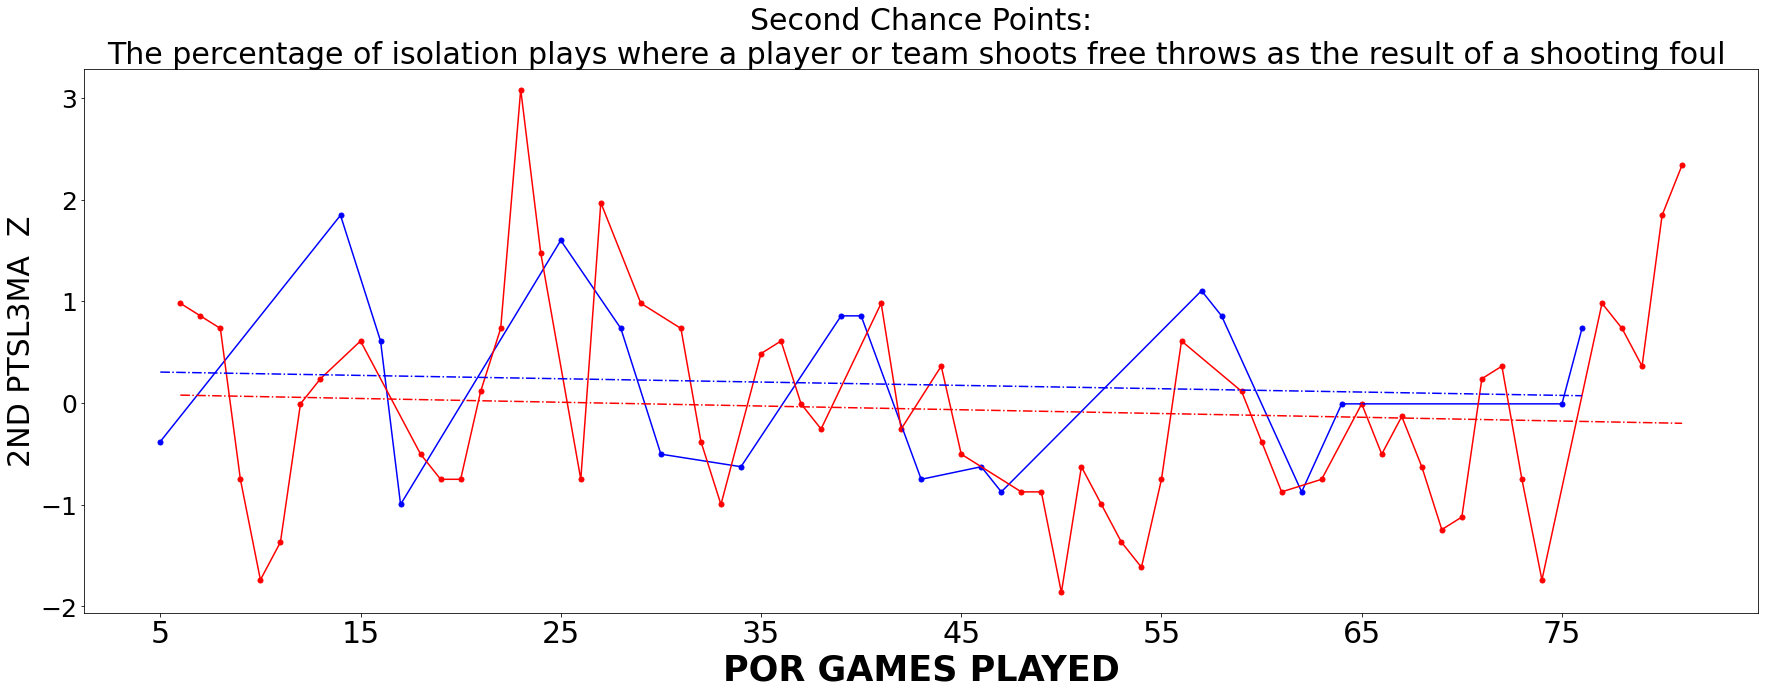

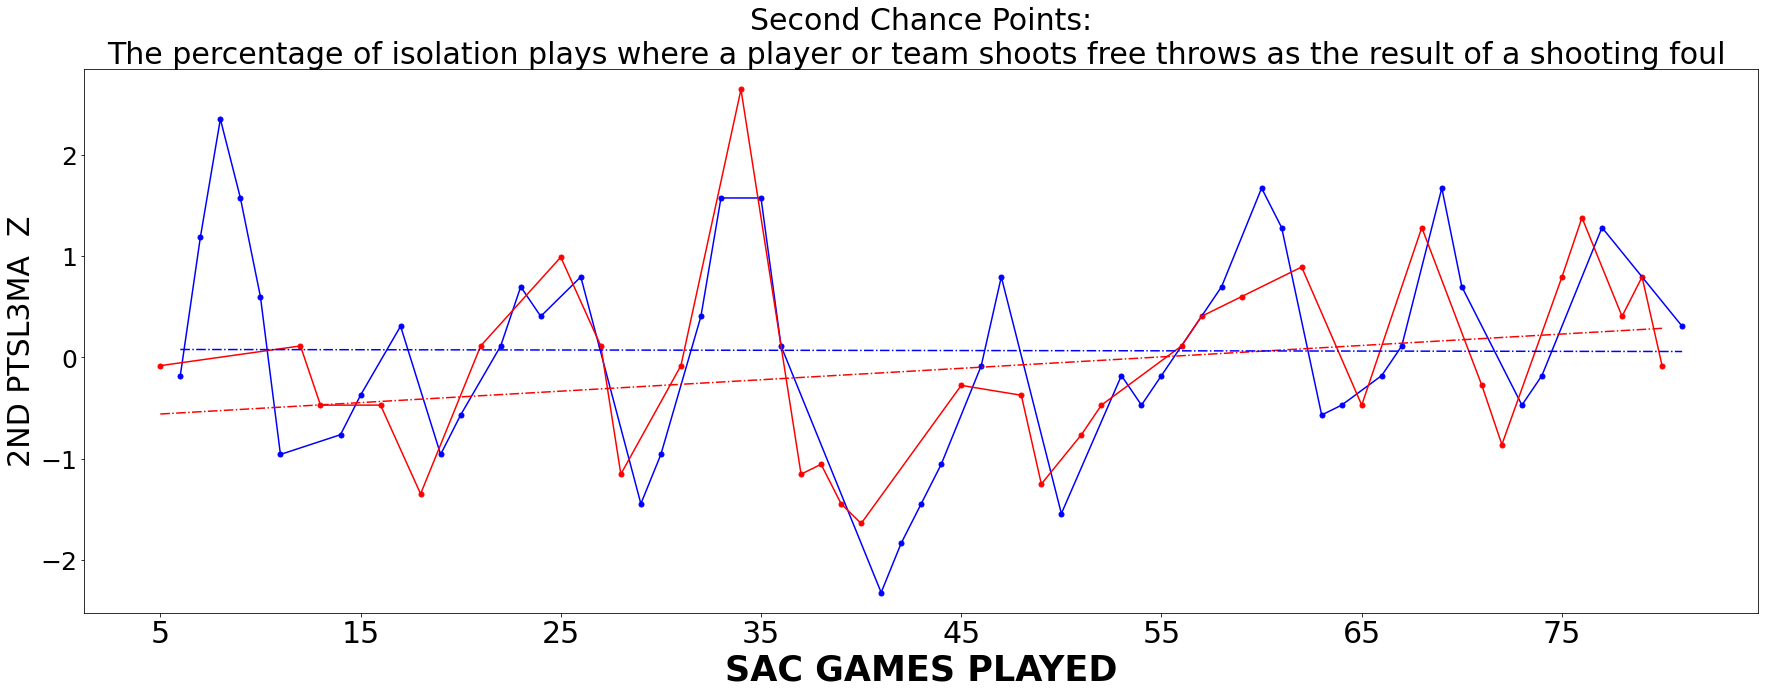

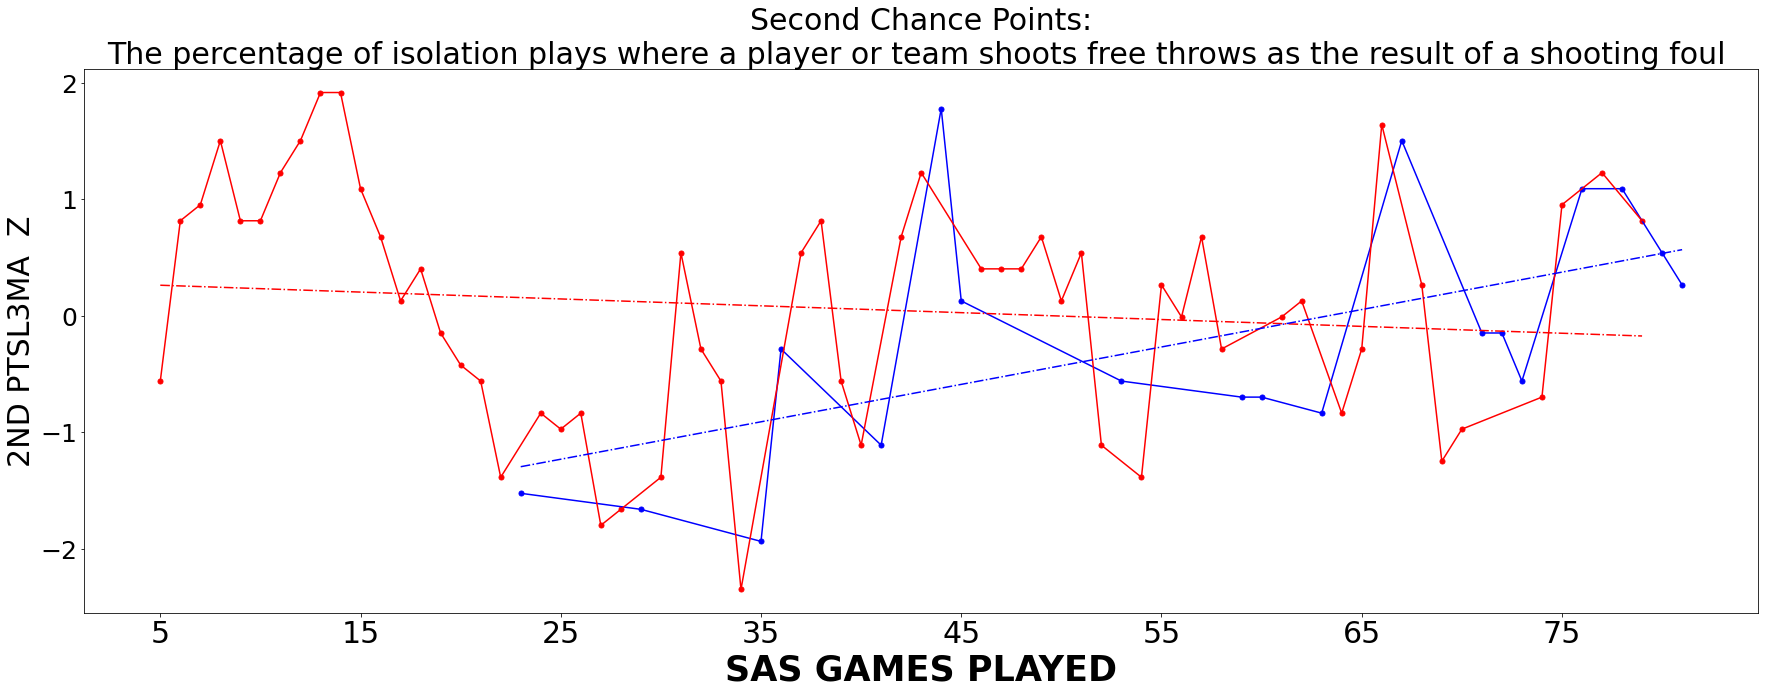

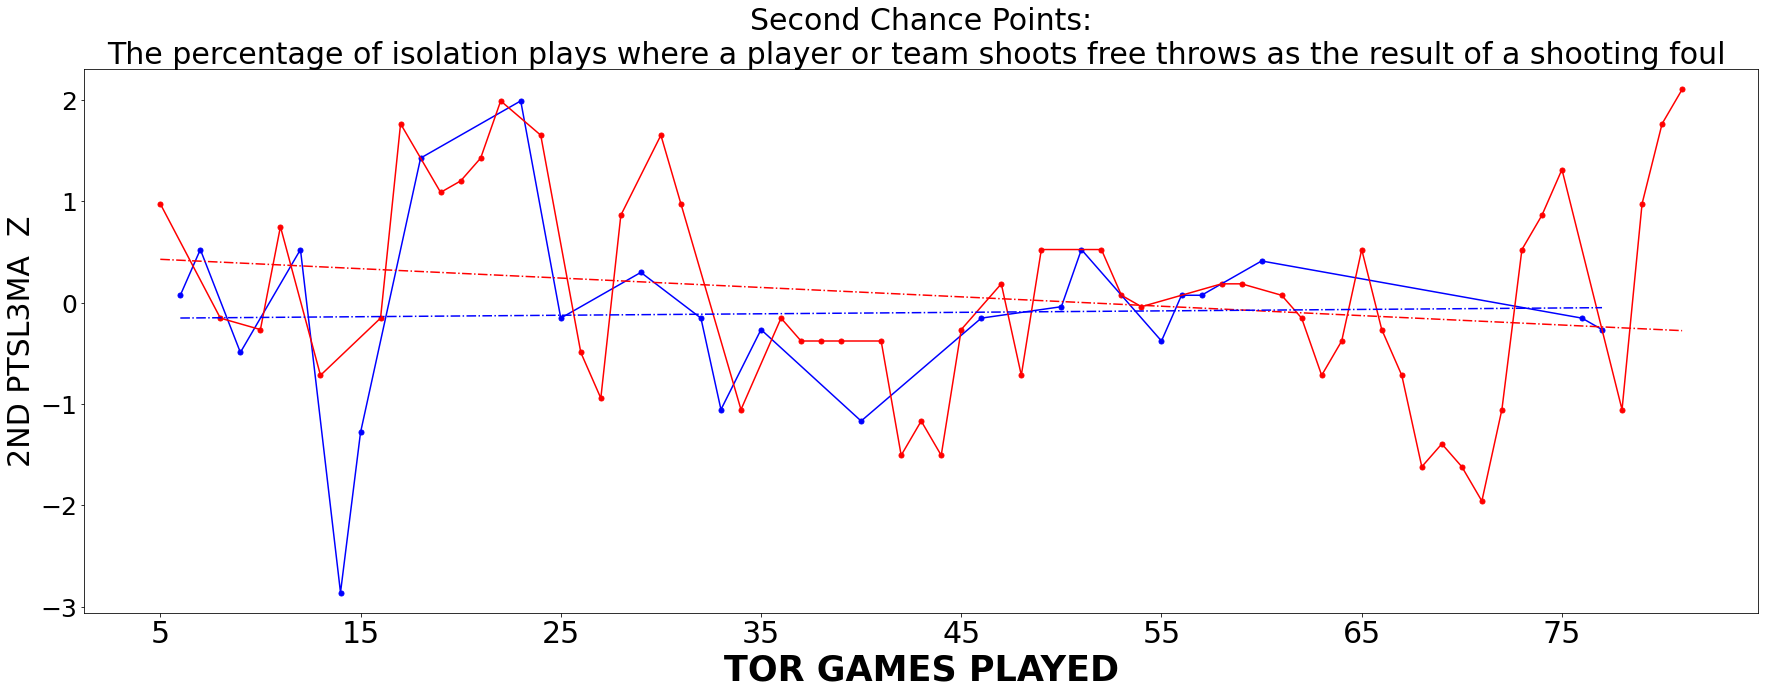

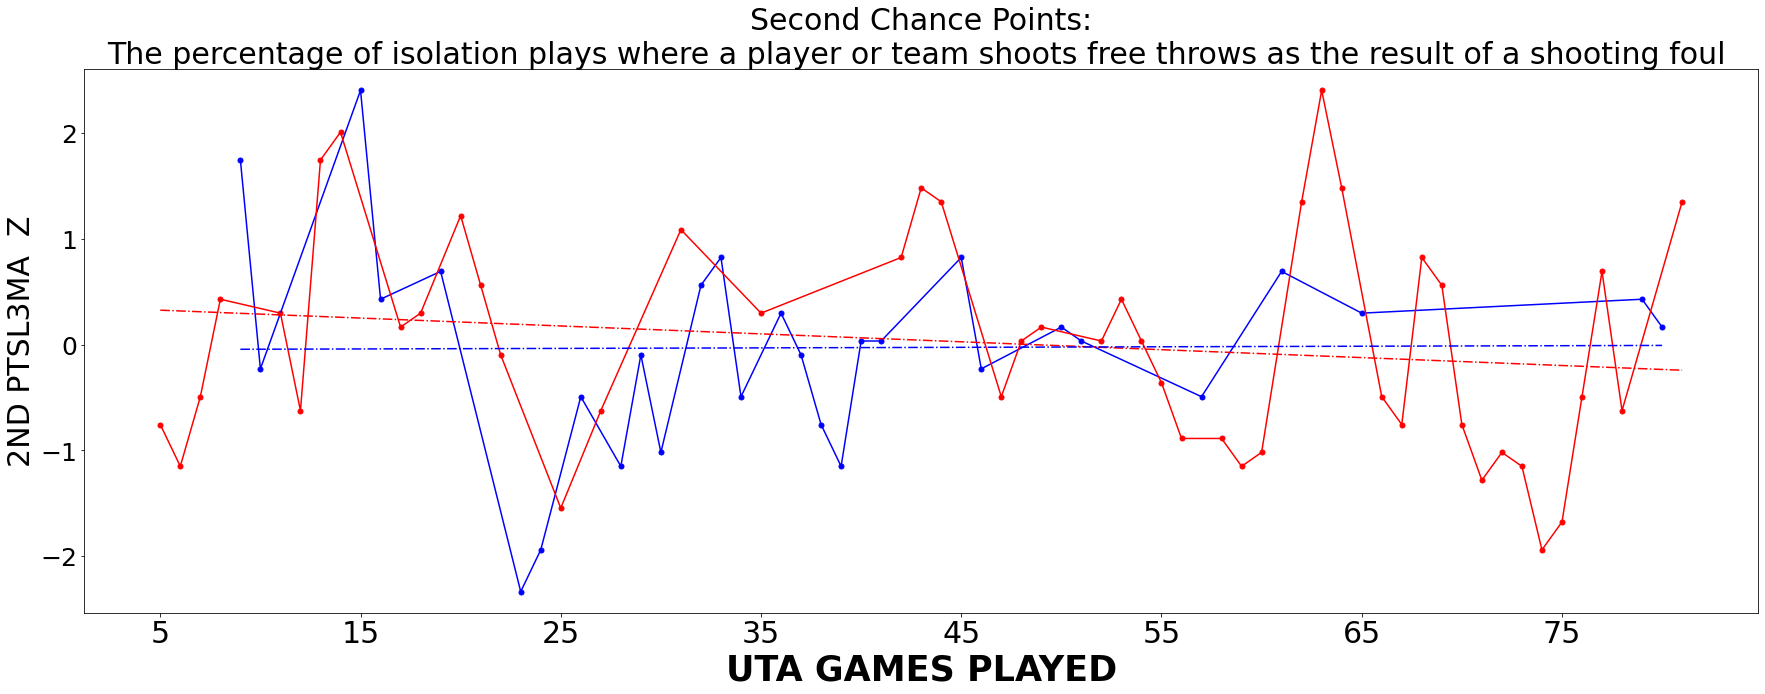

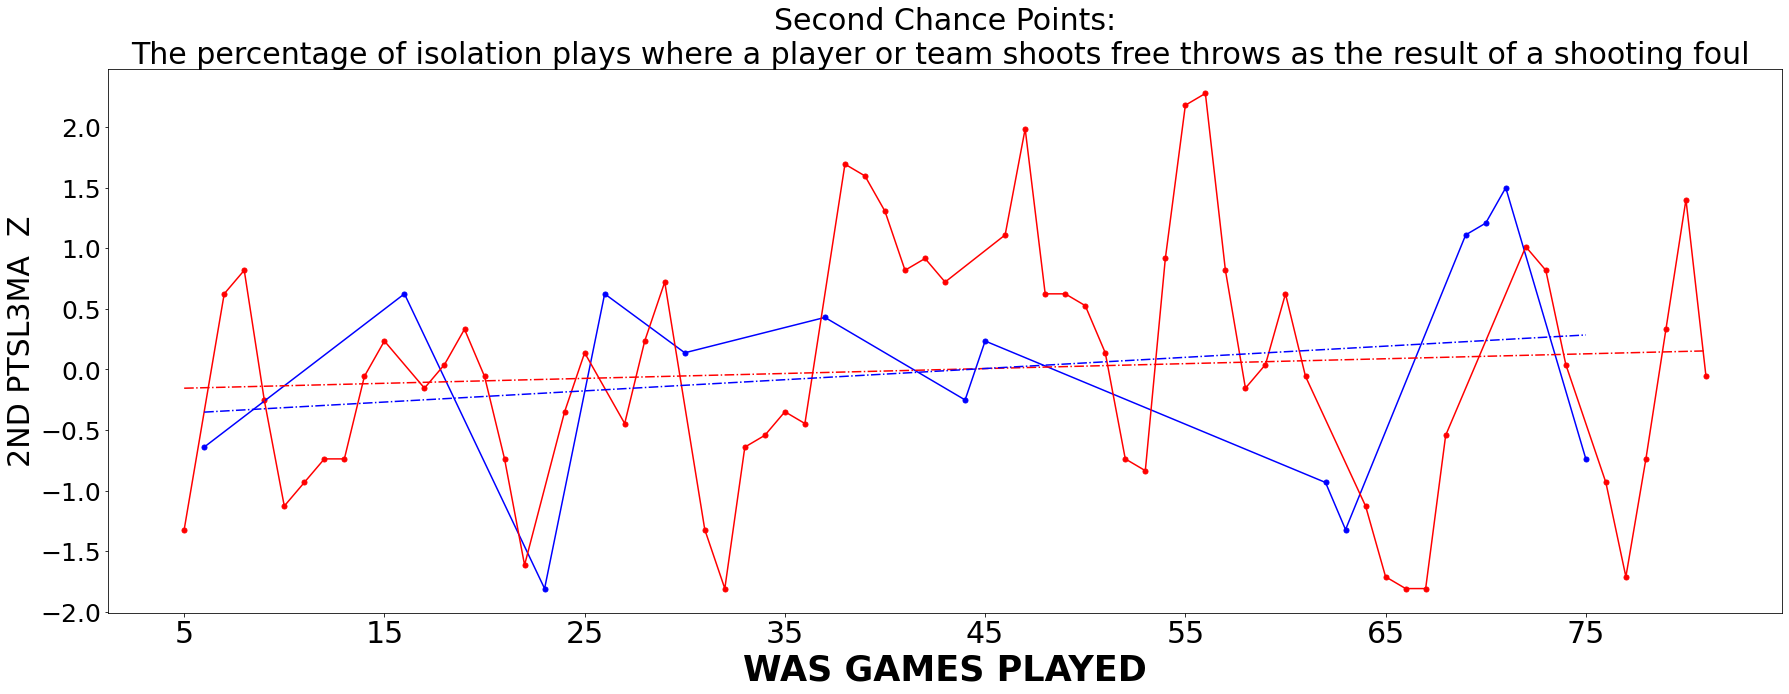

In [70]:
for team in list(np.unique(miscDF['TEAM'])):
    plt.figure(figsize=(30,10))
    feature = '2ND PTSL3MA'
    teamDF = miscDF[miscDF['TEAM'] == team]
    teamDF = teamDF[teamDF['DATE'] < datetime.date(2024,4,15)]
    teamDF = teamDF.reset_index(drop=True)
    teamDF = teamDF.dropna()
    
    teamDF['X_test'] = stats.zscore(teamDF[feature])
    
    plt.scatter(teamDF[teamDF['RESULT'] == 0].index,
                teamDF[teamDF['RESULT'] == 0]['X_test'].values,color='red',marker='.',s=100)

    plt.scatter(teamDF[teamDF['RESULT'] == 1].index,
                teamDF[teamDF['RESULT'] == 1]['X_test'].values,color='blue',marker='.',s=100)
    
    plt.plot(teamDF[teamDF['RESULT'] == 1].index, teamDF[teamDF['RESULT'] == 1]['X_test'].values,color='b')
    plt.plot(teamDF[teamDF['RESULT'] == 0].index, teamDF[teamDF['RESULT'] == 0]['X_test'].values,color='r')
    
    res = stats.linregress(teamDF[teamDF['RESULT'] == 0].index,teamDF[teamDF['RESULT'] == 0]['X_test'])
    plt.plot(teamDF[teamDF['RESULT'] == 0].index, res.intercept + res.slope*teamDF[teamDF['RESULT'] == 0].index, 'r-.')
    
    res = stats.linregress(teamDF[teamDF['RESULT'] == 1].index,teamDF[teamDF['RESULT'] == 1]['X_test'])
    plt.plot(teamDF[teamDF['RESULT'] == 1].index, res.intercept + res.slope*teamDF[teamDF['RESULT'] == 1].index, 'b-.')
    
    defintion = getFeatureDefintion(feature)
    plt.title(defintion,fontsize=30)
    plt.xlabel(team+' GAMES PLAYED',fontsize=35,fontweight='bold')
    plt.ylabel(feature+'  Z',fontsize=30)
    
    plt.ylim(top=np.max(teamDF['X_test'])+.2)     # adjust the top leaving bottom unchanged
    plt.ylim(bottom=np.min(teamDF['X_test'])-.2)  # adjust the bottom leaving top unchanged
   
    plt.yticks(fontsize=25)
    
    ticks = []
    for i in range (0,len(list(teamDF.index)),10): ticks.append(list(teamDF.index)[i])
        
    plt.xticks(ticks)
    plt.xticks(fontsize=30)
    plt.show()
    
#https://stackoverflow.com/questions/2176424/hiding-axis-text-in-matplotlib-plots

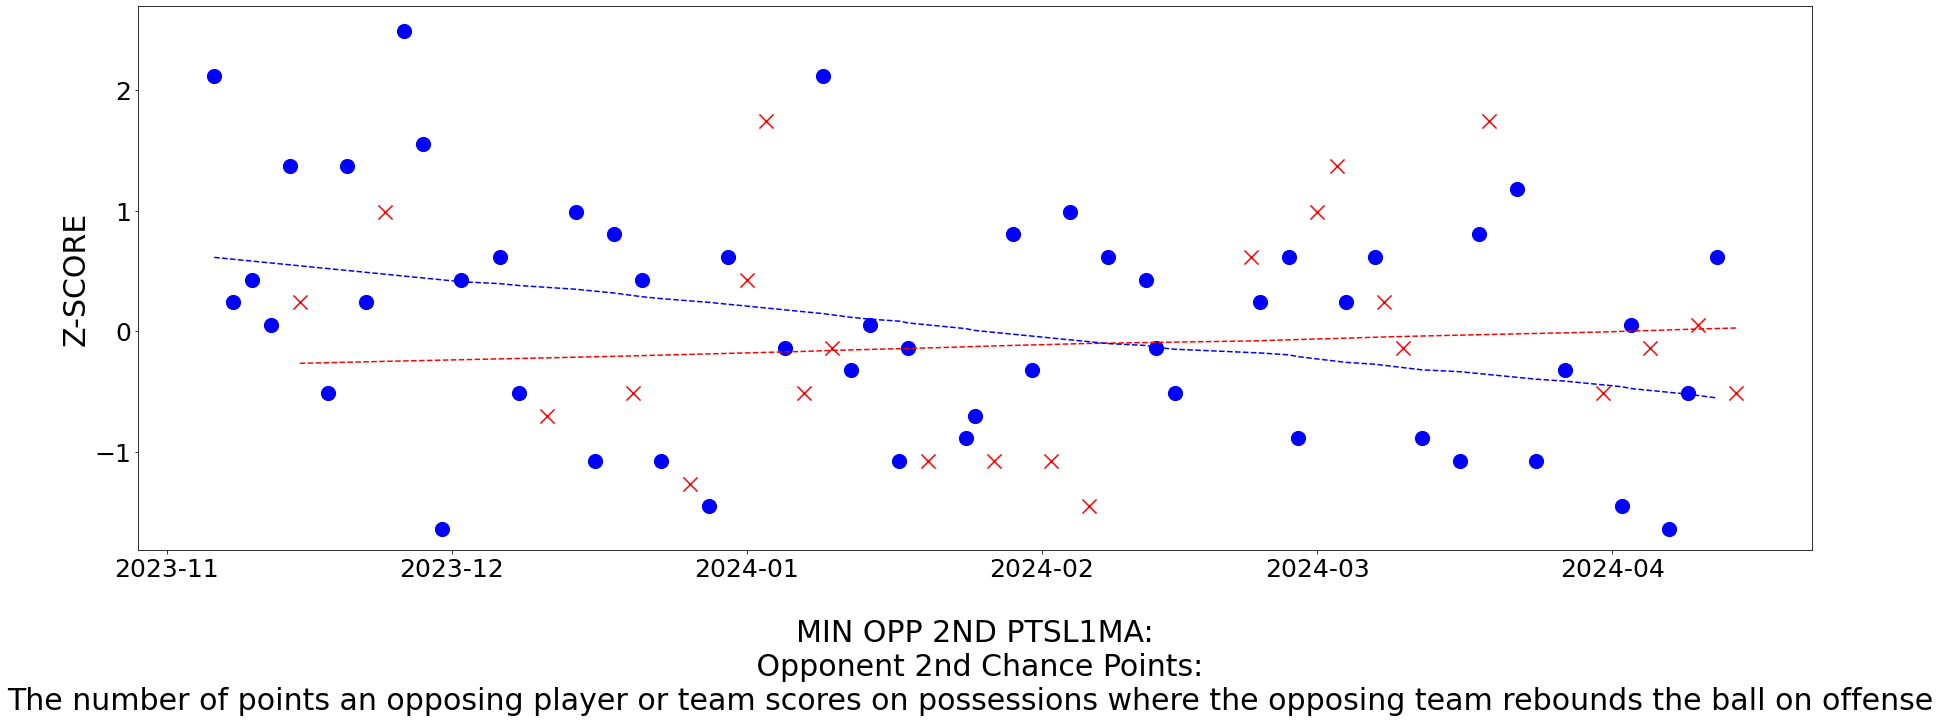

In [71]:
team = 'MIN'
plt.figure(figsize=(30,10))
feature = 'OPP 2ND PTSL1MA'
teamDF = miscDF[miscDF['TEAM'] == team]
teamDF = teamDF[teamDF['DATE'] < datetime.date(2024,4,15)]
teamDF = teamDF.dropna()
teamDF = teamDF.reset_index(drop=True)
teamDF['X_test'] = stats.zscore(teamDF[feature])

plt.scatter(teamDF[teamDF['RESULT'] == 0]['DATE'],
            teamDF[teamDF['RESULT'] == 0]['X_test'].values,color='red',marker='x',s=200)

plt.scatter(teamDF[teamDF['RESULT'] == 1]['DATE'],
            teamDF[teamDF['RESULT'] == 1]['X_test'].values,color='blue',marker='o',s=200)


res = stats.linregress(teamDF[teamDF['RESULT'] == 0].index,teamDF[teamDF['RESULT'] == 0]['X_test'])
plt.plot(teamDF[teamDF['RESULT'] == 0]['DATE'], res.intercept + res.slope*teamDF[teamDF['RESULT'] == 0].index, 'r--')

res = stats.linregress(teamDF[teamDF['RESULT'] == 1].index,teamDF[teamDF['RESULT'] == 1]['X_test'])
plt.plot(teamDF[teamDF['RESULT'] == 1]['DATE'], res.intercept + res.slope*teamDF[teamDF['RESULT'] == 1].index, 'b--')

defintion = getFeatureDefintion(feature)
plt.xlabel('\n'+team+' '+feature+':\n '+defintion,fontsize=30)
plt.ylabel('Z-SCORE',fontsize=30)

plt.ylim(top=np.max(teamDF['X_test'])+.2)     # adjust the top leaving bottom unchanged
plt.ylim(bottom=np.min(teamDF['X_test'])+.2)  # adjust the bottom leaving top unchanged
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()
#https://stackoverflow.com/questions/2176424/hiding-axis-text-in-matplotlib-plots

In [72]:
#plt.plot([52,52],[0,52])

In [73]:
#type(awayTeamDF[awayTeamDF['RESULT'] == 0]['GAMEID'][2])

In [74]:
# awayTeamDF = miscDF[miscDF['TEAM'] == 'BKN']
# pd.DataFrame(trainOnPreviousGames(awayTeamDF,miscFeatures,datetime.date(2024,3,17),1)[datetime.date(2024,3,17)]['BKN']).sort_values(by='ODDS RATIO',ascending=False)

In [75]:
# plt.figure(figsize=(25,5))
# ATL = copy.deepcopy(miscDF[miscDF['TEAM'] == 'ATL'])
# ATL = ATL.reset_index(drop=True)
# plt.plot(ATL[ATL['RESULT'] == 0]['2ND PTSL3MA'],color='red',marker='o',linestyle='dashed')
# plt.plot(ATL[ATL['RESULT'] == 1]['2ND PTSL3MA'],marker='o',linestyle='dashed')
# plt.show()

In [76]:
# ATL[ATL['RESULT'] == 0]['2ND PTSL3MA'].describe()

In [77]:
# ATL[ATL['RESULT'] == 1]['2ND PTSL3MA'].describe()

In [78]:
#modelTypeResultsDict['misc']['typeResults'][datetime.date(2024, 2, 22)]['standardized']['oddsRatio']['testDetailsDF']

In [79]:
# grouped = leagueFeaturesDF.groupby('FEATURE')
# grouped 
# #https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html

In [80]:
maxFeatureDF = pd.DataFrame()
for team in np.unique(miscDF['TEAM']):
    teamDF = leagueFeaturesDF[leagueFeaturesDF['TEAM'] == team]
    if len(teamDF) == 1:
        maxFeatureDF = maxFeatureDF.append(teamDF)

In [81]:
maxFeatureDF

TEAM             FEATURE COUNT  TOTAL
0   ATL         2ND PTSL3MA    27     27
8   CHA  OPP PTS OFF TOL1MA    28     28
36  LAC      PTS OFF TOL1MA    29     29
40  MEM            FBPSL1MA    26     26
55  OKC            FBPSL1MA    28     28

In [82]:
# for i in range(len(df)):
#     team = maxFeatureDF.iloc[i]['TEAM']
#     plt.figure(figsize=(7,7))
#     teamDF = miscDF[miscDF['TEAM'] == team]
#     teamDF = teamDF.reset_index(drop=True)
    
#     plt.scatter(teamDF[teamDF['RESULT'] == 0][maxFeatureDF.iloc[i]['FEATURE']],
#                 teamDF[teamDF['RESULT'] == 0][maxFeatureDF.iloc[i]['FEATURE']],color='red',marker='x',s=150,linewidth=3,alpha=.4)
    
#     plt.scatter(teamDF[teamDF['RESULT'] == 1][maxFeatureDF.iloc[i]['FEATURE']],
#                 teamDF[teamDF['RESULT'] == 1][maxFeatureDF.iloc[i]['FEATURE']],marker='o',s=150,linewidth=3,alpha=.4)

# #     plt.plot(teamDF[teamDF['RESULT'] == 0][maxFeatureDF.iloc[i]['FEATURE']],color='red',linestyle='dashdot')
# #     plt.plot(teamDF[teamDF['RESULT'] == 1][maxFeatureDF.iloc[i]['FEATURE']],linestyle='dashdot')
#     plt.xlabel(team,size=18)
#     plt.ylabel(maxFeatureDF.iloc[i]['FEATURE'],size=20)
#     plt.yticks(fontsize=20)
#     plt.xticks(fontsize=20)
#     plt.show()

In [83]:
# feature = '2ND PTSL3MA'
# for team in NBATeams:
#     plt.figure(figsize=(7,7))
#     teamDF = miscDF[miscDF['TEAM'] == team]
#     teamDF = teamDF.reset_index(drop=True)
    
#     plt.scatter(teamDF[teamDF['RESULT'] == 0][feature],
#                 teamDF[teamDF['RESULT'] == 0][feature],color='red',marker='x',s=150,linewidth=3,alpha=.4)
    
#     plt.scatter(teamDF[teamDF['RESULT'] == 1][feature],
#                 teamDF[teamDF['RESULT'] == 1][feature],marker='o',s=150,linewidth=3,alpha=.4)

#     plt.xlabel(team,size=18)
#     plt.ylabel(feature,size=20)
#     plt.yticks(fontsize=20)
#     plt.xticks(fontsize=20)
#     plt.show()

In [225]:
#defintions
def printFeatureDefintion(feature):
    import textwrap
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    definiton = glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
    return textwrap.fill(definiton,80)
def getFeatureDefintion(feature):
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    definiton = glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
    return definiton

TEAM         MAX FEATURE FREQUENCY  \
0   ATL         2ND PTSL3MA     27/27   
1   BKN     OPP 2ND PTSL5MA     23/28   
2   BOS     OPP 2ND PTSL2MA      8/27   
3   CHA  OPP PTS OFF TOL1MA     28/28   
4   CHI  OPP PTS OFF TOL5MA     11/27   
5   CLE        OPP PITPL1MA     27/29   
6   DAL     OPP 2ND PTSL1MA     21/27   
7   DEN        OPP FBPSL4MA     24/27   
8   DET         2ND PTSL2MA      9/28   
9   GSW        OPP FBPSL1MA     17/29   
10  HOU     OPP 2ND PTSL5MA     20/28   
11  IND        OPP PITPL1MA     16/26   
12  LAC      PTS OFF TOL1MA     29/29   
13  LAL        OPP FBPSL1MA     19/26   
14  MEM            FBPSL1MA     26/26   
15  MIA      PTS OFF TOL5MA     12/27   
16  MIL  OPP PTS OFF TOL4MA     21/26   
17  MIN     OPP 2ND PTSL1MA     15/27   
18  NOP      PTS OFF TOL1MA     20/27   
19  NYK      PTS OFF TOL2MA     11/27   
20  OKC            FBPSL1MA     28/28   
21  ORL            FBPSL1MA     26/27   
22  PHI  OPP PTS OFF TOL5MA     19/28   
23  PHX     OPP 2ND PTSL1MA     14/27   
24  POR         2ND PTSL4MA     21/28   
25  SAC     OPP 2ND PTSL1MA     20/28   
26  SAS        OPP FBPSL2MA     18/27   
27  TOR            FBPSL2MA     15/27   
28  UTA            PITPL5MA     22/26   
29  WAS  OPP PTS OFF TOL3MA     13/28   

                                                                                                                                          FEATURE DEFINTION  
0                       Second Chance Points: The percentage of isolation plays where a player or team shoots free throws as the result of a shooting foul   
1   Opponent 2nd Chance Points: The number of points an opposing player or team scores on possessions where the opposing team rebounds the ball on offense   
2   Opponent 2nd Chance Points: The number of points an opposing player or team scores on possessions where the opposing team rebounds the ball on offense   
3                                            Opponent Points off Turnovers: The number of points scored by an opposing player or team following a turnover   
4                                            Opponent Points off Turnovers: The number of points scored by an opposing player or team following a turnover   
5                                                     Opponent Points in the Paint: The number of points scored by an opposing player or team in the paint   
6   Opponent 2nd Chance Points: The number of points an opposing player or team scores on possessions where the opposing team rebounds the ball on offense   
7                                              Opponent Fast Break Points: The number of points scored by an opposing player or team while on a fast break   
8                       Second Chance Points: The percentage of isolation plays where a player or team shoots free throws as the result of a shooting foul   
9                                              Opponent Fast Break Points: The number of points scored by an opposing player or team while on a fast break   
10  Opponent 2nd Chance Points: The number of points an opposing player or team scores on possessions where the opposing team rebounds the ball on offense   
11                                                    Opponent Points in the Paint: The number of points scored by an opposing player or team in the paint   
12                                                  Points off Turnovers: The number of points scored by a player or team following an opponent's turnover   
13                                             Opponent Fast Break Points: The number of points scored by an opposing player or team while on a fast break   
14                                                                Fast Break Points: The number of points scored by a player or team while on a fast break   
15                                                  Points off Turnovers: The number of points scored by a player or team following an opponent's turnover   
16                                           

In [86]:
# team = 'ATL'
# feature = '2ND PTSL3MA'
# plt.figure(figsize=(7,7))
# teamDF = miscDF[miscDF['TEAM'] == team]
# teamDF = teamDF.reset_index(drop=True)
# plt.scatter(teamDF[teamDF['RESULT'] == 0][feature],
#             teamDF[teamDF['RESULT'] == 0][feature],color='red',marker='x',s=150,linewidth=3,alpha=.4)
# plt.scatter(teamDF[teamDF['RESULT'] == 1][feature],
#             teamDF[teamDF['RESULT'] == 1][feature],marker='o',s=150,linewidth=3,alpha=0.4)
# plt.xlabel(team,size=25)
# plt.ylabel(feature,size=25)
# plt.yticks(fontsize=20)
# plt.xticks(fontsize=20)
# plt.show()
# # print(teamDF[teamDF['RESULT'] == 0][feature].describe())
# # print()
# # print(teamDF[teamDF['RESULT'] == 1][feature].describe())

In [201]:
# for i in range(len(maxFeatureDF)):

#     team = maxFeatureDF.iloc[i]['TEAM']
#     plt.figure(figsize=(25,5))
#     teamDF = miscDF[miscDF['TEAM'] == team]
#     teamDF = teamDF.reset_index(drop=True)
#     plt.plot(teamDF[teamDF['RESULT'] == 0][maxFeatureDF.iloc[i]['MAX FEATURE']],color='red',linestyle='dashdot')
#     plt.plot(teamDF[teamDF['RESULT'] == 1][maxFeatureDF.iloc[i]['MAX FEATURE']],linestyle='dashdot')
#     plt.xlabel(team,size=18)
#     plt.ylabel(maxFeatureDF.iloc[i]['MAX FEATURE'],size=20)
#     plt.yticks(fontsize=20)
#     plt.xticks(fontsize=20)
#     plt.show()

In [88]:
#teamDF[maxFeatureDF.iloc[i]['MAX FEATURE']]
len(teamDF[teamDF['RESULT'] == 0][maxFeatureDF.iloc[i]['MAX FEATURE']])

KeyError: 'MAX FEATURE'

In [89]:
len(teamDF[teamDF['RESULT'] == 1][maxFeatureDF.iloc[i]['MAX FEATURE']])

KeyError: 'MAX FEATURE'

In [90]:
# for i in range(len(maxFeatureDF)):
#     team = maxFeatureDF.iloc[i]['TEAM']
#     plt.figure(figsize=(7,7))
#     teamDF = miscDF[miscDF['TEAM'] == team]
#     teamDF = teamDF.reset_index(drop=True)
#     plt.scatter(teamDF[teamDF['RESULT'] == 0][maxFeatureDF.iloc[i]['MAX FEATURE']],
#                 teamDF[teamDF['RESULT'] == 0][maxFeatureDF.iloc[i]['MAX FEATURE']],
#                 color='red',marker='x',s=300,linewidth=3,alpha=.4)
    
#     plt.scatter(teamDF[teamDF['RESULT'] == 1][maxFeatureDF.iloc[i]['MAX FEATURE']],
#                 teamDF[teamDF['RESULT'] == 1][maxFeatureDF.iloc[i]['MAX FEATURE']],
#                 marker='o',color='blue',s=150,linewidth=3,alpha=.4)
    
#     plt.xlabel(team,size=25)
#     plt.ylabel(maxFeatureDF.iloc[i]['MAX FEATURE'],size=25)
#     plt.yticks(fontsize=20)
#     plt.xticks(fontsize=20)
#     plt.show()

In [91]:
## features = []
for feature in maxFeatureDF['MAX FEATURE']:
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    features.append(feature)

KeyError: 'MAX FEATURE'

In [92]:
leagueMaxFeaturesDF = pd.DataFrame(np.unique(features,return_counts=True)).T.rename(columns={0:'MAX FEATURE',1:'COUNT'})
leagueMaxFeaturesDF = leagueMaxFeaturesDF.sort_values(by='COUNT',ascending=False).reset_index(drop=True)
leagueMaxFeaturesDF 

MAX FEATURE COUNT
0      %FGA 2PT     1
1      %FGA 3PT     1
2      %PTS 2PT     1
3   %PTS 2PT MR     1
4      %PTS 3PT     1
5     %PTS FBPS     1
6       %PTS FT     1
7   %PTS OFF TO     1
8     %PTS PITP     1
9     2FGM %AST     1
10   2FGM %UAST     1
11    3FGM %AST     1
12   3FGM %UAST     1
13     FGM %AST     1
14    FGM %UAST     1

In [93]:
defintions = []
for i in range(len(leagueMaxFeaturesDF)):
    defintions.append(glossaryDict[leagueMaxFeaturesDF.iloc[i]['MAX FEATURE']]['Name']+': '+glossaryDict[leagueMaxFeaturesDF.iloc[i]['MAX FEATURE']]['Definition'])
# leagueMaxFeaturesDF['NAME'] = names
leagueMaxFeaturesDF['DEFINTION'] = defintions
leagueMaxFeaturesDF

MAX FEATURE COUNT  \
0      %FGA 2PT     1   
1      %FGA 3PT     1   
2      %PTS 2PT     1   
3   %PTS 2PT MR     1   
4      %PTS 3PT     1   
5     %PTS FBPS     1   
6       %PTS FT     1   
7   %PTS OFF TO     1   
8     %PTS PITP     1   
9     2FGM %AST     1   
10   2FGM %UAST     1   
11    3FGM %AST     1   
12   3FGM %UAST     1   
13     FGM %AST     1   
14    FGM %UAST     1   

                                                                                                                                                                                             DEFINTION  
0                                                                      Percent of Field Goals Attempted (2 Pointers): The percentage of field goals attempted by a player or team that are 2 pointers   
1                                                                      Percent of Field Goals Attempted (3 Pointers): The percentage of field goals attempted by a player or team that are 3 pointers   
2                                                                      Percent of Points (2-Point Field Goals): The percentage of points scored by a player or team that are from 2 point field goals   
3   Percent of Points (2-Point Field Goals: Mid Range): The percentage of points scored by a player or team that are that are from mid-range field goals (2 point field goals from outside the paint)   
4                                                                      Percent of Points (3-Point Field Goals): The percentage of points scored by a player or team that are from 3 point field goals   
5                                                                   Percent of Points (Fast Break Points): The percentage of points scored by a player or team that are from fast break opportunities   
6                                                                                      Percent of Points (Free Throws): The percentage of points scored by a player or team that are from free throws   
7                                         Percent of Points (Off Turnovers): The percentage of points scored by a player or team that are scored on the possession after forcing an opponent turnover   
8                                                                           Percent of Points (Points in the Paint): The percentage of points scored by a player or team that are scored in the paint   
9                                                        Percent of 2 Point Field Goals Made Assisted: The percentage of 2 point field goals made by a player or team that are assisted by a teammate   
10                                                 Percent of 2 Point Field Goals Made Unassisted: The percentage of 2 point field goals made by a player or team that are not assisted by a teammate   
11                                                                                     3 Pointers Made (Percent Assisted): The percentage of 3 point field goals made that are assisted by a teammate   
12                                                                               3 Pointers Made (Percent Unassisted): The percentage of 3 point field goals made that are not assisted by a teammate   
13                                                                 Percent of Field Goals Made Assisted: The percentage of total field goals made by a player or team that are assisted by a teammate   
14                                                                                              Field Goals Made (Unassisted): The percentage of field goals made that are not assisted by a teammate

In [94]:
#sum(leagueMaxFeatures['COUNT'])

In [95]:
# def printFeatureDefintion(feature):
#     import textwrap
#     subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
#     for subString in subStringsToRemove:
#         feature = feature.replace(subString, '')
#     definiton = glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
#     print(textwrap.fill(definiton,80))
# def getFeatureDefintion(feature):
#     subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
#     for subString in subStringsToRemove:
#         feature = feature.replace(subString, '')
#     definiton = glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
#     return definiton

## advancedDF+RAWODDSRATIO WHEN FEATURE IS USED >= 25

In [96]:
# leagueFeaturesDF = getFeaturesByTeam(advancedDF,advancedModelTypeResults,'standardized','oddsRatio')
# leagueFeaturesDF
# leagueFeaturesDF.sort_values(by=['COUNT','FEATURE'],ascending=False)
# leagueFeaturesDF = leagueFeaturesDF[leagueFeaturesDF['COUNT'] >= 25]
# leagueFeaturesDF.reset_index(drop=True)

In [97]:
# for i in range(len(leagueFeaturesDF)):
#     team = leagueFeaturesDF.iloc[i]['TEAM']
#     feature = leagueFeaturesDF.iloc[i]['FEATURE']
#     plt.figure(figsize=(15,5))
#     plt.xlabel(feature+' Z-SCORE',size=14)
#     plt.ylabel(team,size=14)
#     date = datetime.date(2024, 4, 15)
#     plot_decision_regions(getStandardizedTrainData(advancedDF,team,date,feature)[0],
#                           np.array(getStandardizedTrainData(advancedDF,team,date,feature)[1]).astype('int'),
#                           getModel(getStandardizedTrainData(advancedDF,team,date,feature)[0],getStandardizedTrainData(advancedDF,team,date,feature)[1]));
#     teamDF = advancedDF[advancedDF['TEAM'] == team]
#     teamDF = teamDF[teamDF['GP'] > 5]
#     teamDF = teamDF.reset_index(drop=True)
#     teamDF = pd.concat([pd.DataFrame(StandardScaler().fit_transform(np.reshape(teamDF[feature].values,(len(teamDF[feature].values),1))),columns=[feature]),
#                         teamDF['RESULT']],axis=1)
#     plt.scatter(teamDF[teamDF['RESULT'] == 0][feature],np.zeros_like(teamDF[teamDF['RESULT'] == 0][feature]),c='r',marker='x',s=100)
#     plt.scatter(teamDF[teamDF['RESULT'] == 1][feature],np.zeros_like(teamDF[teamDF['RESULT'] == 1][feature]),c='b',marker='o',s=100)
#     plt.show()
#     seasonTestDetailsDF = getSeasonTestDetailsDF(advancedDF,advancedModelTypeResults,'standardized','oddsRatio')
#     seasonTestDetailsDF[seasonTestDetailsDF['TEAM'] == team].reset_index(drop=True)

# ODDS RATIO PROFF

In [98]:
CLE_byOddsRatioRaw = proveFeatureSelections(traditionalDF,'CLE',traditionalFeatures,datetime.date(2024, 2, 22),0,'oddsRatio')
CLE_byOddsRatioStandardized = proveFeatureSelections(traditionalDF,'CLE',traditionalFeatures,datetime.date(2024, 2, 22),1,'oddsRatio')
CLE_byLogLossRaw = proveFeatureSelections(traditionalDF,'CLE',traditionalFeatures,datetime.date(2024, 2, 22),0,'logLoss')
CLE_byLogLossStandardized = proveFeatureSelections(traditionalDF,'CLE',traditionalFeatures,datetime.date(2024, 2, 22),1,'logLoss')

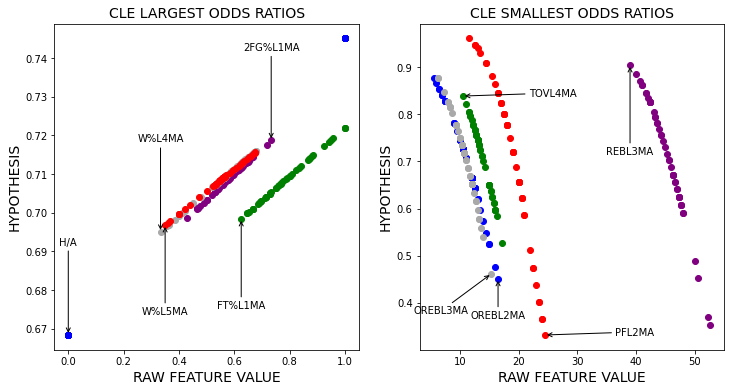

ODDS RATIO PROFF:
 -LARGEST ODDS RATIOS:
   AS FEATURE RAW VALUES INCREASE BY RAW VALUE
   HYPOTHESIS INCREASEAS
 -SMALLEST ODDS RATIOS:
   AS FEATURE RAW VALUES INCREASE BY RAW VALUE
   HYPOTHESIS DECREASES

CLE LARGEST ODDS RATIOS:
          date  trainSize   feature  intercept      coef  oddsRatio   logLoss        sd
0  2024-02-22         48       H/A   0.700726  0.372022   1.450665  0.597194  0.499566
1  2024-02-22         48  2FG%L1MA   0.703405  0.320123   1.377297  0.601453  0.068153
2  2024-02-22         48   FT%L1MA   0.648544  0.305931   1.357888  0.601588  0.101515
3  2024-02-22         48    W%L4MA   0.725667  0.294175   1.342019  0.601769  0.085457
4  2024-02-22         48    W%L5MA   0.734972  0.278222   1.320779  0.601968  0.083651
CLE SMALLEST ODDS RATIOS:
            date  trainSize   feature  intercept      coef  oddsRatio   logLoss        sd
117  2024-02-22         48  OREBL2MA   3.030155 -0.195505   0.822419  0.576368  2.685784
118  2024-02-22         48   REBL3MA  

In [99]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
ax0,ax1 = axes.flatten()
maxCorr = []
minCorr = []
colors = ['blue','purple','green','darkgrey','red']
features = CLE_byOddsRatioRaw.head()['feature'].values
colorsIter = 0
for feature in CLE_byOddsRatioRaw.head()['feature']:
    proffDF = buildFeatureDF(traditionalDF,'CLE',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    minCorr.append((proffDF.head(1)[feature].values[0],proffDF.head(1)['HYPO'].values[0]))
    maxCorr.append((proffDF.tail(1)[feature].values[0],proffDF.tail(1)['HYPO'].values[0]))
    ax0.scatter(proffDF[feature],proffDF['HYPO'],c=colors[colorsIter]);
    colorsIter = colorsIter+1
ax0.annotate(features[0],xy=(minCorr[0]),xytext=(0,90), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax0.annotate(features[1],(maxCorr[1]),xytext=(0,90), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax0.annotate(features[2],(minCorr[2]),xytext=(0,-90), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax0.annotate(features[3],(minCorr[3]),xytext=(0,90), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax0.annotate(features[4],(minCorr[4]),xytext=(0,-90), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax0.set_title('CLE LARGEST ODDS RATIOS',size=14)
ax0.set_xlabel('RAW FEATURE VALUE',size=14);
ax0.set_ylabel('HYPOTHESIS',size=14);


maxCorr = []
minCorr = []
features = CLE_byOddsRatioRaw.tail()['feature'].values
colorsIter = 0
for feature in CLE_byOddsRatioRaw.tail()['feature']:
    proffDF = buildFeatureDF(traditionalDF,'CLE',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    minCorr.append((proffDF.head(1)[feature].values[0],proffDF.head(1)['HYPO'].values[0]))
    maxCorr.append((proffDF.tail(1)[feature].values[0],proffDF.tail(1)['HYPO'].values[0]))
    ax1.scatter(proffDF[feature],proffDF['HYPO'],c=colors[colorsIter]);
    colorsIter = colorsIter+1
ax1.annotate(features[0],xy=(maxCorr[0]),xytext=(0,-40), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax1.annotate(features[1],(minCorr[1]),xytext=(0,-90), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax1.annotate(features[2],(minCorr[2]),xytext=(90,0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax1.annotate(features[3],(maxCorr[3]),xytext=(-50,-40), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax1.annotate(features[4],(maxCorr[4]),xytext=(90,0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax1.set_title('CLE SMALLEST ODDS RATIOS',size=14)
ax1.set_xlabel('RAW FEATURE VALUE',size=14);
ax1.set_ylabel('HYPOTHESIS',size=14);
plt.show()

print('ODDS RATIO PROFF:\n',
      '-LARGEST ODDS RATIOS:\n   AS FEATURE RAW VALUES INCREASE BY RAW VALUE\n   HYPOTHESIS INCREASEAS\n',
      '-SMALLEST ODDS RATIOS:\n   AS FEATURE RAW VALUES INCREASE BY RAW VALUE\n   HYPOTHESIS DECREASES\n')

print('CLE LARGEST ODDS RATIOS:\n',CLE_byOddsRatioRaw.head())
print('CLE SMALLEST ODDS RATIOS:\n',CLE_byOddsRatioRaw.tail())

# IMPACT OF STANDARDIZETON

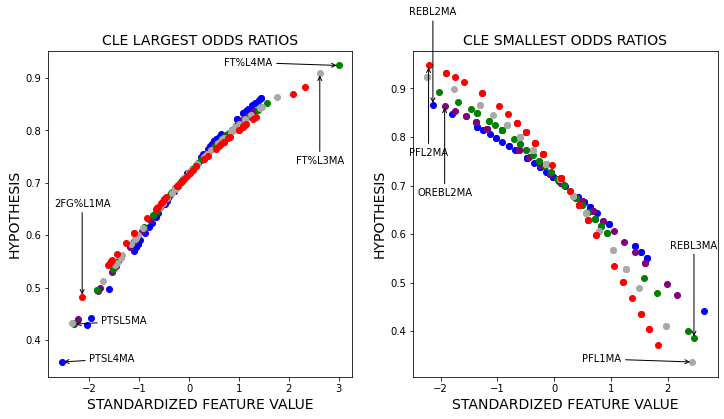

ODDS RATIO PROFF:
 -LARGEST ODDS RATIOS:
   AS FEATURE STANDARDIZED VALUES INCREASE BY STANDARD DEVIATION
   HYPOTHESIS INCREASEAS
 -SMALLEST ODDS RATIOS:
   AS FEATURE STANDARDIZED VALUES INCREASE BY STANDARD DEVIATION
   HYPOTHESIS DECREASES

CLE LARGEST ODDS RATIOS:
          date  trainSize   feature  intercept      coef  oddsRatio   logLoss   sd
0  2024-02-22         48   PTSL4MA   0.955784  0.603452   1.828419  0.559553  1.0
1  2024-02-22         48   PTSL5MA   0.940531  0.529555   1.698177  0.568673  1.0
2  2024-02-22         48   FT%L4MA   0.940392  0.519355   1.680943  0.572679  1.0
3  2024-02-22         48   FT%L3MA   0.940899  0.517762   1.678268  0.572520  1.0
4  2024-02-22         48  2FG%L1MA   0.931257  0.466197   1.593921  0.577922  1.0
CLE SMALLEST ODDS RATIOS:
            date  trainSize   feature  intercept      coef  oddsRatio   logLoss   sd
117  2024-02-22         48   REBL2MA   0.925635 -0.441084   0.643339  0.580012  1.0
118  2024-02-22         48  OREBL2MA   0.9

In [100]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
ax0,ax1 = axes.flatten()
colors = ['blue','purple','green','darkgrey','red']
features = CLE_byOddsRatioStandardized.head()['feature'].values
colorsIter = 0
maxCorr = []
minCorr = []
for feature in CLE_byOddsRatioStandardized.head()['feature']:
    proffDF = buildFeatureDF(traditionalDF,'CLE',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    minCorr.append((proffDF.head(1)['SS'+feature].values[0],proffDF.head(1)['SSHYPO'].values[0]))
    maxCorr.append((proffDF.tail(1)['SS'+feature].values[0],proffDF.tail(1)['SSHYPO'].values[0]))
    ax0.scatter(proffDF['SS'+feature],proffDF['SSHYPO'],c=colors[colorsIter]);
    colorsIter = colorsIter+1
ax0.annotate(features[0],xy=(minCorr[0]),xytext=(50,0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax0.annotate(features[1],(minCorr[1]),xytext=(50,0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax0.annotate(features[2],(maxCorr[2]),xytext=(-90,0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax0.annotate(features[3],(maxCorr[3]),xytext=(0,-90), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax0.annotate(features[4],(minCorr[4]),xytext=(0,90), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax0.set_title('CLE LARGEST ODDS RATIOS',size=14)
ax0.set_xlabel('STANDARDIZED FEATURE VALUE',size=14);
ax0.set_ylabel('HYPOTHESIS',size=14);

features = CLE_byOddsRatioStandardized.tail()['feature'].values
colorsIter = 0
maxCorr = []
minCorr = []
for feature in CLE_byOddsRatioStandardized.tail()['feature']:
    proffDF = buildFeatureDF(traditionalDF,'CLE',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    minCorr.append((proffDF.head(1)['SS'+feature].values[0],proffDF.head(1)['SSHYPO'].values[0]))
    maxCorr.append((proffDF.tail(1)['SS'+feature].values[0],proffDF.tail(1)['SSHYPO'].values[0]))
    ax1.scatter(proffDF['SS'+feature],proffDF['SSHYPO'],c=colors[colorsIter]);
    colorsIter = colorsIter+1
ax1.annotate(features[0],xy=(minCorr[0]),xytext=(0,90), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax1.annotate(features[1],(minCorr[1]),xytext=(0,-90), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax1.annotate(features[2],(maxCorr[2]),xytext=(0,90), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax1.annotate(features[3],(maxCorr[3]),xytext=(-90,0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax1.annotate(features[4],(minCorr[4]),xytext=(0,-90), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax1.set_title('CLE SMALLEST ODDS RATIOS',size=14)
ax1.set_xlabel('STANDARDIZED FEATURE VALUE',size=14);
ax1.set_ylabel('HYPOTHESIS',size=14);
plt.show()

print('ODDS RATIO PROFF:\n',
      '-LARGEST ODDS RATIOS:\n   AS FEATURE STANDARDIZED VALUES INCREASE BY STANDARD DEVIATION\n   HYPOTHESIS INCREASEAS\n',
      '-SMALLEST ODDS RATIOS:\n   AS FEATURE STANDARDIZED VALUES INCREASE BY STANDARD DEVIATION\n   HYPOTHESIS DECREASES\n')
print('CLE LARGEST ODDS RATIOS:\n',CLE_byOddsRatioStandardized.head())
print('CLE SMALLEST ODDS RATIOS:\n',CLE_byOddsRatioStandardized.tail())

In [1718]:
df = pd.concat(getModelPredictions(miscStandardizedOddsRatioMatchResults))
df[df['MODEL PREDICTS'] == 'ATL'].reset_index(drop=True)

DATE      MATCH    GAMEID MODEL PREDICTS ACTUAL WINNER BETTING FAVORITE
0   2024-02-23  TOR @ ATL  22300804            ATL      (TOR, ❌)   (ATL, -7.5, ✅)
1   2024-02-25  ORL @ ATL  22300821            ATL      (ATL, ✅)   (ATL, -2.0, ✅)
2   2024-02-29  ATL @ BKN  22300851            ATL      (BKN, ❌)   (BKN, -1.5, ❌)
3   2024-03-02  ATL @ BKN  22300866            ATL      (BKN, ❌)   (ATL, -1.0, ✅)
4   2024-03-08  ATL @ MEM  22300913            ATL      (ATL, ✅)   (ATL, -3.5, ✅)
5   2024-03-13  ATL @ POR  22300953            ATL      (POR, ❌)   (ATL, -4.0, ✅)
6   2024-03-17  ATL @ LAC  22300982            ATL      (ATL, ✅)   (LAC, -9.5, ❌)
7   2024-03-18  ATL @ LAL  22300990            ATL      (LAL, ❌)   (LAL, -9.0, ❌)
8   2024-03-23  CHA @ ATL  22301021            ATL      (ATL, ✅)   (ATL, -7.5, ✅)
9   2024-03-27  POR @ ATL  22301051            ATL      (ATL, ✅)  (ATL, -12.0, ✅)
10  2024-04-03  DET @ ATL  22301104            ATL      (ATL, ✅)  (ATL, -12.5, ✅)
11  2024-04-10  CHA @ ATL  22301159            ATL      (CHA, ❌)   (ATL, -8.5, ✅)

In [1719]:
NBAteams =['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL','MEM',
               'MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WAS']
def getActualWinnerAccuracyByTeam(predictionsDF):
    predictionsByTeam = {}
    for team in np.unique(NBAteams): predictionsByTeam[team] = {}
    for team in np.unique(NBAteams):
        predictionsByTeam[team]['✅'] = int(len(predictionsDF[predictionsDF['ACTUAL WINNER'] == (team,'✅')]))
        predictionsByTeam[team]['❌'] = len(predictionsDF[predictionsDF['MODEL PREDICTS'] == team]) - int(len(predictionsDF[predictionsDF['ACTUAL WINNER'] == (team,'✅')]))
    predictionsByTeamDF = pd.DataFrame(predictionsByTeam).T
    predictionsByTeamDF['MODEL VS ACTUAL%'] = predictionsByTeamDF['✅'] / (predictionsByTeamDF['✅']+predictionsByTeamDF['❌'])
    return predictionsByTeamDF
def getBettingFavoriteAccuracyByTeam(predictionsDF):
    predictionsByTeam = {}
    for team in np.unique(NBAteams): predictionsByTeam[team] = {'✅':0,'❌':0}
    for i in range (len(predictionsDF)):
        if predictionsDF.iloc[i]['MODEL PREDICTS'] != ' ':
            if predictionsDF.iloc[i]['MODEL PREDICTS'] == predictionsDF.iloc[i]['BETTING FAVORITE'][0]:
                predictionsByTeam[predictionsDF.iloc[i]['MODEL PREDICTS']]['✅'] = predictionsByTeam[predictionsDF.iloc[i]['MODEL PREDICTS']]['✅']+1
            else: predictionsByTeam[predictionsDF.iloc[i]['MODEL PREDICTS']]['❌'] = predictionsByTeam[predictionsDF.iloc[i]['MODEL PREDICTS']]['❌']+1
    predictionsByTeamDF = pd.DataFrame(predictionsByTeam).T
    predictionsByTeamDF['MODEL VS BETTING FAVORITE%'] = predictionsByTeamDF['✅'] / (predictionsByTeamDF['✅']+predictionsByTeamDF['❌'])
    return predictionsByTeamDF

actualWinnerAccuracyByTeam = getActualWinnerAccuracyByTeam(pd.concat(getModelPredictions(miscStandardizedOddsRatioMatchResults)))
bettingFavoriteAccuracyByTeam = getBettingFavoriteAccuracyByTeam(pd.concat(getModelPredictions(miscStandardizedOddsRatioMatchResults)))

In [1720]:
actualWinnerAccuracyByTeam

✅   ❌  MODEL VS ACTUAL%
ATL   6   6          0.500000
BKN   5   5          0.500000
BOS  21   6          0.777778
CHA   1   2          0.333333
CHI   5   8          0.384615
CLE   9  12          0.428571
DAL  10   5          0.666667
DEN  15   4          0.789474
DET   0   0               NaN
GSW  14   3          0.823529
HOU   9   4          0.692308
IND  11   6          0.647059
LAC  12   8          0.600000
LAL   9   3          0.750000
MEM   5   5          0.500000
MIA  12   6          0.666667
MIL   7   7          0.500000
MIN  15   8          0.652174
NOP  10   5          0.666667
NYK  12   7          0.631579
OKC  17   7          0.708333
ORL  14   4          0.777778
PHI  10   6          0.625000
PHX  10   5          0.666667
POR   2   2          0.500000
SAC  10   8          0.555556
SAS   1   0          1.000000
TOR   2   3          0.400000
UTA   3   5          0.375000
WAS   1   2          0.333333

In [1721]:
bettingFavoriteAccuracyByTeam

✅  ❌  MODEL VS BETTING FAVORITE%
ATL   9  3                    0.750000
BKN   6  4                    0.600000
BOS  26  1                    0.962963
CHA   0  3                    0.000000
CHI   6  7                    0.461538
CLE  15  6                    0.714286
DAL  13  2                    0.866667
DEN  18  1                    0.947368
DET   0  0                         NaN
GSW  15  2                    0.882353
HOU  10  3                    0.769231
IND  13  4                    0.764706
LAC  15  5                    0.750000
LAL   8  4                    0.666667
MEM   1  9                    0.100000
MIA  15  3                    0.833333
MIL  10  4                    0.714286
MIN  17  6                    0.739130
NOP  13  2                    0.866667
NYK  12  7                    0.631579
OKC  20  4                    0.833333
ORL  16  2                    0.888889
PHI  10  6                    0.625000
PHX  12  3                    0.800000
POR   0  4                    0.000000
SAC  14  4                    0.777778
SAS   1  0                    1.000000
TOR   3  2                    0.600000
UTA   4  4                    0.500000
WAS   3  0                    1.000000

In [1722]:
pd.concat([actualWinnerAccuracyByTeam,
          bettingFavoriteAccuracyByTeam],axis=1) 

✅   ❌  MODEL VS ACTUAL%   ✅  ❌  MODEL VS BETTING FAVORITE%
ATL   6   6          0.500000   9  3                    0.750000
BKN   5   5          0.500000   6  4                    0.600000
BOS  21   6          0.777778  26  1                    0.962963
CHA   1   2          0.333333   0  3                    0.000000
CHI   5   8          0.384615   6  7                    0.461538
CLE   9  12          0.428571  15  6                    0.714286
DAL  10   5          0.666667  13  2                    0.866667
DEN  15   4          0.789474  18  1                    0.947368
DET   0   0               NaN   0  0                         NaN
GSW  14   3          0.823529  15  2                    0.882353
HOU   9   4          0.692308  10  3                    0.769231
IND  11   6          0.647059  13  4                    0.764706
LAC  12   8          0.600000  15  5                    0.750000
LAL   9   3          0.750000   8  4                    0.666667
MEM   5   5          0.500000   1  9                    0.100000
MIA  12   6          0.666667  15  3                    0.833333
MIL   7   7          0.500000  10  4                    0.714286
MIN  15   8          0.652174  17  6                    0.739130
NOP  10   5          0.666667  13  2                    0.866667
NYK  12   7          0.631579  12  7                    0.631579
OKC  17   7          0.708333  20  4                    0.833333
ORL  14   4          0.777778  16  2                    0.888889
PHI  10   6          0.625000  10  6                    0.625000
PHX  10   5          0.666667  12  3                    0.800000
POR   2   2          0.500000   0  4                    0.000000
SAC  10   8          0.555556  14  4                    0.777778
SAS   1   0          1.000000   1  0                    1.000000
TOR   2   3          0.400000   3  2                    0.600000
UTA   3   5          0.375000   4  4                    0.500000
WAS   1   2          0.333333   3  0                    1.000000

In [1723]:
# Using List Comprehension
# np.min([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])

In [1724]:
# plt.figure(figsize=(20,5))
# plt.title('VS ACTUAL (PURPLE), VS BETTING FAVORITE  (GREEN)',size=16)
# plt.xlabel('TEAM',size=16)
# plt.ylabel('ACCURACY')
# plt.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['ACCURACY'].values,marker='o',c='purple');
# plt.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['ACCURACY'],marker='o',c='green');  
# plt.show()

# plt.figure(figsize=(20,5))
# plt.title('VS ACTUAL (PURPLE), VS BETTING FAVORITE  (GREEN)',size=16)
# plt.xlabel('TEAM',size=16)
# plt.ylabel('# OF PREDICTIONS CORRECT',size=16)
# plt.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['✅'],marker='o',c='purple');
# plt.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['✅'],marker='o',c='green');
# plt.show()

# plt.figure(figsize=(20,5))
# plt.title('VS ACTUAL (PURPLE), VS BETTING FAVORITE  (GREEN)',size=16)
# plt.xlabel('TEAM',size=16)
# plt.ylabel('# OF PREDICTIONS INCORRECT',size=16)
# plt.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['❌'],marker='x',c='purple');
# plt.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['❌'],marker='x',c='green');
# plt.show()

In [1725]:
# logo_ATL = img=mpimg.imread('/Users/olutosinfashusi/jupyter/git/predict2023-24NBARegularSeasonGames/nba_logos/ATL.png') 
# imgplot = plt.imshow(logo_ATL)

In [1726]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.ticker as mtick 
from matplotlib.ticker import PercentFormatter 

def getImage(path, zoom=1): return OffsetImage(plt.imread(path), zoom=zoom)
NBATeams =['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL','MEM',
           'MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WAS']

paths = []
for team in NBATeams:
    paths.append('/Users/olutosinfashusi/jupyter/git/predict2023-24NBARegularSeasonGames/images/'+team+'.png')

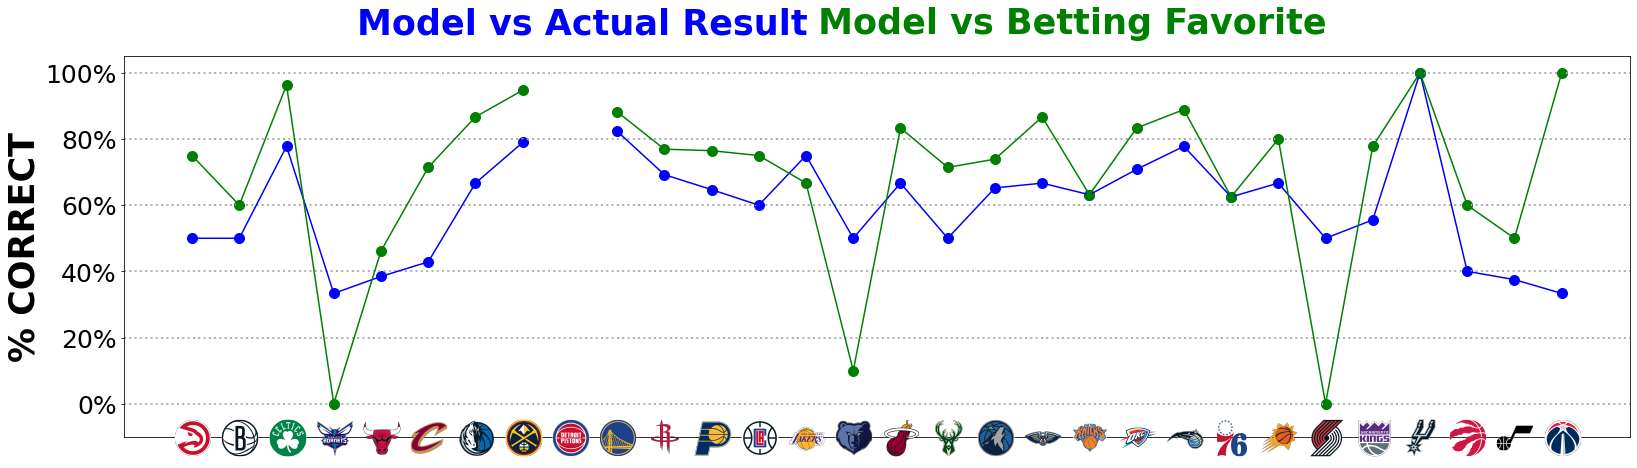

In [1730]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])
ymin = ymin - .1
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])
ymax = ymax + .05
ax.set_ylim(ymin,ymax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))  

# plt.title('Model vs Actual Result in blue & Model vs Betting Favorite in green',size=25,fontweight='bold')

# plt.title('Model vs Actual Result',size=25,fontweight='bold',color='blue')
# plt.title('Model vs Betting Favorite',size=25,fontweight='bold',color='green')
plt.ylabel('% CORRECT',size=35,fontweight='bold')
plt.yticks(fontsize=25)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ymin),paths):
    ab = AnnotationBbox(getImage(path),(x,ymin), frameon=False)
    ax.add_artist(ab)
    
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])
ax.annotate('Model vs Actual Result\n',(3.5,ymax),fontsize=35,fontweight ='bold',color='blue')
ax.annotate(' Model vs Betting Favorite\n',(13,ymax),fontsize=35,fontweight ='bold',color='green')
plt.grid(linestyle=':',linewidth=2)
plt.show()

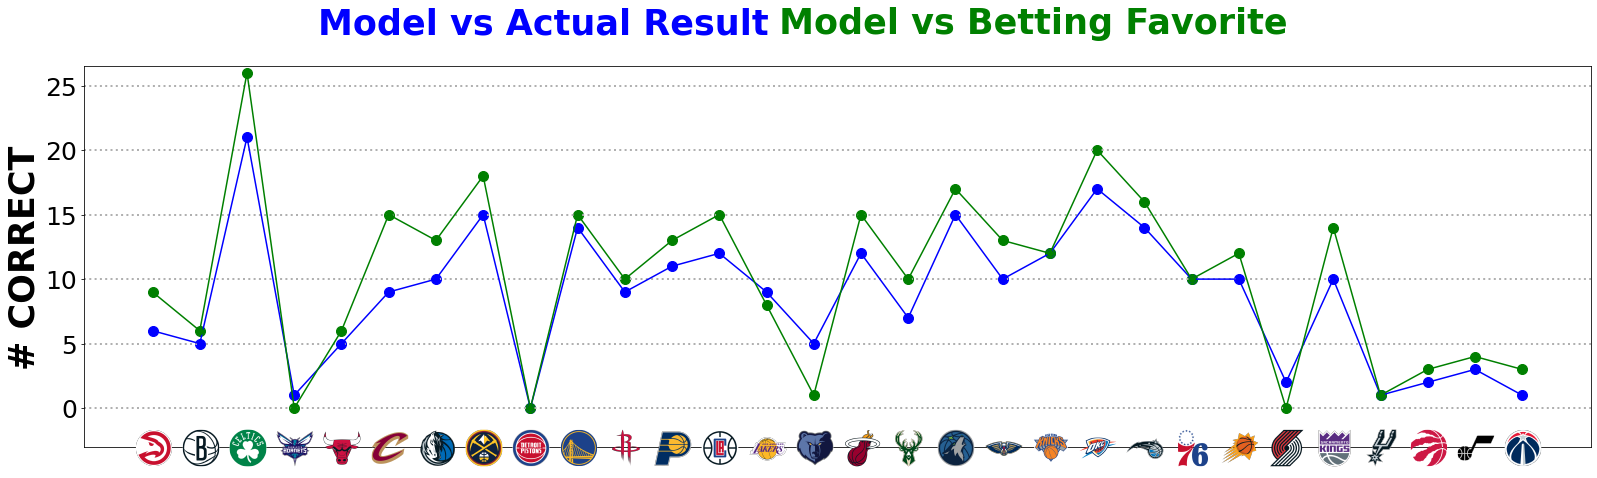

In [1731]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['✅'].values)+ list(bettingFavoriteAccuracyByTeam['✅'].values) if not math.isnan(x)])
ymin = ymin - 3
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['✅'].values)+ list(bettingFavoriteAccuracyByTeam['✅'].values) if not math.isnan(x)])
ymax = ymax + .5
ax.set_ylim(ymin,ymax)
#plt.title('Model vs Actual Result in blue & Model vs Betting Favorite in green',size=25,fontweight='bold')
plt.ylabel('# CORRECT',size=35,fontweight='bold')
plt.yticks(fontsize=25)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['✅'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['✅'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['✅'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['✅'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ymin),paths):
    ab = AnnotationBbox(getImage(path),(x,ymin), frameon=False)
    ax.add_artist(ab)
    
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['✅'].values)+ list(bettingFavoriteAccuracyByTeam['✅'].values) if not math.isnan(x)])
ax.annotate('Model vs Actual Result\n',(3.5,ymax),fontsize=35,fontweight ='bold',color='blue')
ax.annotate(' Model vs Betting Favorite\n',(13,ymax),fontsize=35,fontweight ='bold',color='green')
plt.grid(linestyle=':',linewidth=2)
plt.show()

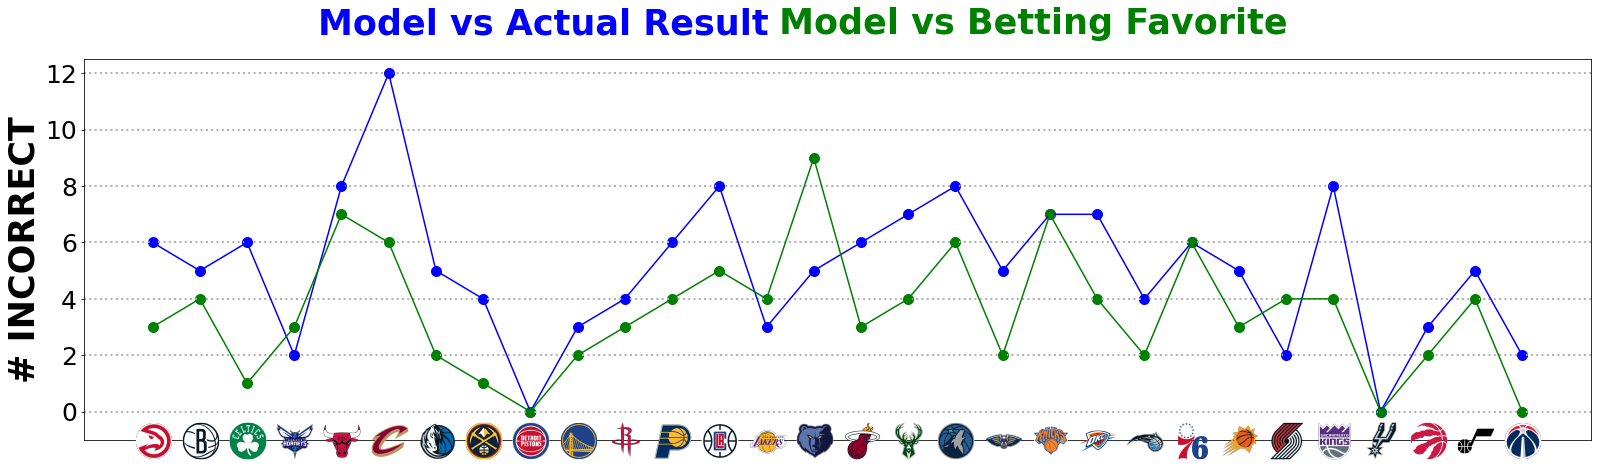

In [1732]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['❌'].values)+ list(bettingFavoriteAccuracyByTeam['❌'].values) if not math.isnan(x)])
ymin = ymin - 1
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['❌'].values)+ list(bettingFavoriteAccuracyByTeam['❌'].values) if not math.isnan(x)])
ymax = ymax + .5
ax.set_ylim(ymin,ymax)
# plt.title('Model vs Actual Result in blue & Model vs Betting Favorite in green',size=25,fontweight='bold')
plt.ylabel('# INCORRECT',size=35,fontweight='bold')
plt.yticks(fontsize=25)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['❌'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['❌'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['❌'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['❌'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ymin),paths):
    ab = AnnotationBbox(getImage(path),(x,ymin), frameon=False)
    ax.add_artist(ab)

ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['❌'].values)+ list(bettingFavoriteAccuracyByTeam['❌'].values) if not math.isnan(x)])
ax.annotate('Model vs Actual Result\n',(3.5,ymax),fontsize=35,fontweight ='bold',color='blue')
ax.annotate(' Model vs Betting Favorite\n',(13,ymax),fontsize=35,fontweight ='bold',color='green')

plt.grid(linestyle=':',linewidth=2)
plt.show()

NameError: name 'ylim' is not defined

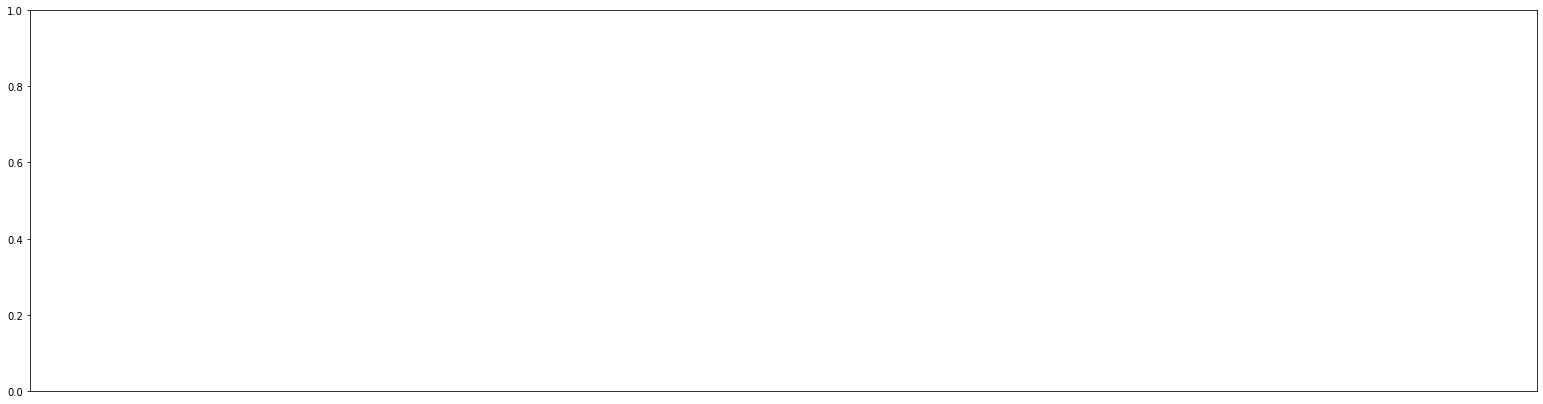

In [1670]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])
ymin = ymin - .1
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])
ymax = ymax + .05
ax.set_ylim(ylim,ymax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))  

plt.title('Model vs Actual Result in blue & Model vs Betting Favorite in green',size=25,fontweight='bold')
plt.ylabel('% CORRECT',size=25,fontweight='bold')
plt.yticks(fontsize=20)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ylim),paths):
    ab = AnnotationBbox(getImage(path),(x,ylim), frameon=False)
    ax.add_artist(ab)
plt.grid(linestyle=':',linewidth=2)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['✅'].values)+ list(bettingFavoriteAccuracyByTeam['✅'].values) if not math.isnan(x)])
ymin = ymin - 3
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['✅'].values)+ list(bettingFavoriteAccuracyByTeam['✅'].values) if not math.isnan(x)])
ymax = ymax + .5
ax.set_ylim(ymin,ymax)
plt.title('Model vs Actual Result in blue & Model vs Betting Favorite in green',size=25,fontweight='bold')
plt.ylabel('# CORRECT',size=25,fontweight='bold')
plt.yticks(fontsize=20)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['✅'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['✅'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['✅'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['✅'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ymin),paths):
    ab = AnnotationBbox(getImage(path),(x,ymin), frameon=False)
    ax.add_artist(ab)
plt.grid(linestyle=':',linewidth=2)
plt.show()

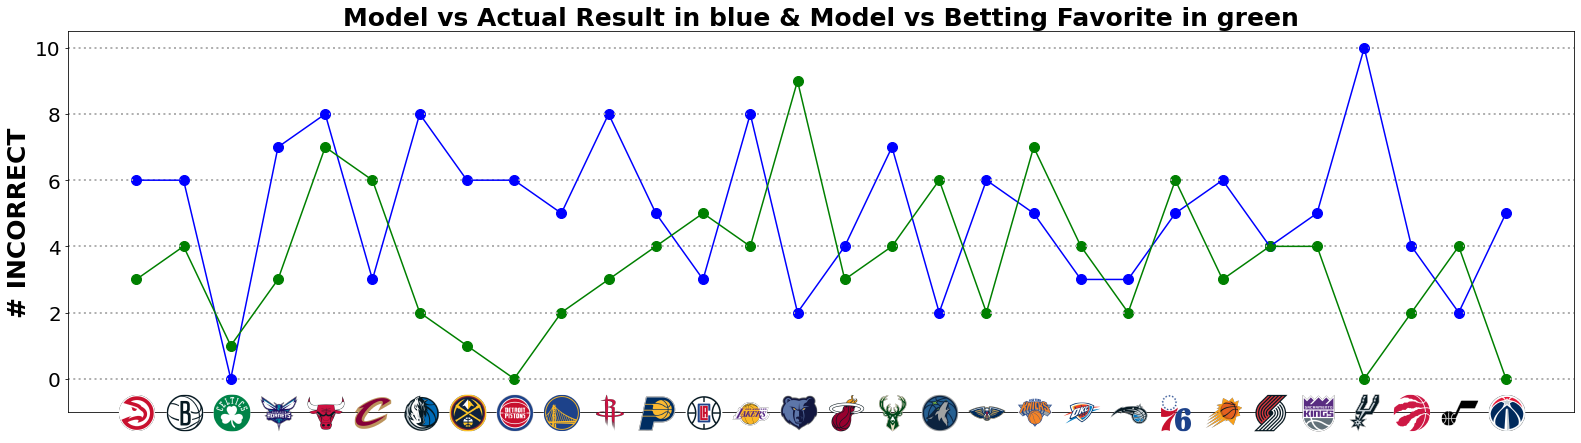

In [1671]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['❌'].values)+ list(bettingFavoriteAccuracyByTeam['❌'].values) if not math.isnan(x)])
ymin = ymin - 1
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['❌'].values)+ list(bettingFavoriteAccuracyByTeam['❌'].values) if not math.isnan(x)])
ymax = ymax + .5
ax.set_ylim(ymin,ymax)
plt.title('Model vs Actual Result in blue & Model vs Betting Favorite in green',size=25,fontweight='bold')
plt.ylabel('# INCORRECT',size=25,fontweight='bold')
plt.yticks(fontsize=20)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['❌'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['❌'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['❌'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['❌'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ymin),paths):
    ab = AnnotationBbox(getImage(path),(x,ymin), frameon=False)
    ax.add_artist(ab)
plt.grid(linestyle=':',linewidth=2)
plt.show()

In [1758]:
2460/2

1230.0

In [ ]:
# DET = miscDF[miscDF['TEAM'] == 'DET']